# CES Accuracy Analysis - Figures

This notebook generates all figures and tables for the CES Accuracy Analysis results section.

## Setup

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy import stats
import seaborn as sns
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Ensure output directory exists
os.makedirs('output', exist_ok=True)

## Color Schemes

In [239]:
# # =============================================================================
# # COLOR SCHEME — Pastel-consistent revision
# # =============================================================================

# # -------------------------------------------------------------------------
# # PRIMARY vs SECONDARY variable analyses
# # (desaturated, lightened versions of existing hues)
# # -------------------------------------------------------------------------
# VARIABLE_TYPE_COLORS = {
#     'Primary': '#B8C7CF',      # Soft blue-grey (pastel grey)
#     'Secondary': '#6FAFB7'     # Pastel teal
# }

# # -------------------------------------------------------------------------
# # Delta values
# # (pastel red; still clearly "change")
# # -------------------------------------------------------------------------
# DELTA_COLOR = '#E6A1A1'        # Soft coral-red

# # -------------------------------------------------------------------------
# # Three-class categorical variables
# # (kept as anchor palette — already pastel-safe)
# # -------------------------------------------------------------------------
# CLASS_COLORS = {
#     'Demographic': '#4477AA',            # Muted blue
#     'Voting Administration': '#EE6677',  # Soft coral
#     'Candidate Choice': '#228833'        # Muted green
# }

# # -------------------------------------------------------------------------
# # U.S. House plots
# # (lighter version of existing teal)
# # -------------------------------------------------------------------------
# US_HOUSE_COLOR = '#7FC6D0'     # Pastel teal-blue

# # -------------------------------------------------------------------------
# # Competitiveness plots
# # (already pastel; slight harmonization)
# # -------------------------------------------------------------------------
# COMPETITIVENESS_COLORS = {
#     'safe': '#E3A6A0',          # Soft red-pink
#     'leaning': '#EBD2B8',      # Light tan
#     'competitive': '#D9EAC6'   # Pale green
# }

# # -------------------------------------------------------------------------
# # Method comparison colors
# # (pastel analogs of original hues)
# # -------------------------------------------------------------------------
# WEIGHTING_COLORS = {
#     'CES-Unweighted': '#8FA3BF',        # Pastel navy-blue
#     'CES-Provided Weights': '#7FC6D0',  # Pastel teal
#     'ANESRake-Full': '#F2B8A2',         # Pastel orange
#     'ANESRake-Restricted': '#F2B8A2'    # Same as Full
# }

# # -------------------------------------------------------------------------
# # Specificity colors
# # -------------------------------------------------------------------------
# SPECIFICITY_COLORS = {
#     'Candidate': '#6FBF8A',     # Pastel green
#     'Party': '#D8CF7A'          # Soft pastel gold
# }


In [ ]:
# =============================================================================
# COLOR SCHEME - Standardized color mappings for all visualizations
# =============================================================================

# -------------------------------------------------------------------------
# PRIMARY vs SECONDARY variable analyses
# -------------------------------------------------------------------------
VARIABLE_TYPE_COLORS = {
    'Primary': '#9FB3BD',                # Grey (RGB 120, 144, 156)
    'Secondary': '#006C7A'               # Dark Teal (RGB 0, 108, 122)
}

# -------------------------------------------------------------------------
# Delta values
# -------------------------------------------------------------------------
DELTA_COLOR = '#E53935'                  # Red

# -------------------------------------------------------------------------
# Three-class categorical variables (Demographic / Voting Admin / Candidate)
# "Good" 3-class color scheme
# -------------------------------------------------------------------------
CLASS_COLORS = {
    'Demographic': '#4477AA',            # Muted blue
    'Voting Administration': '#EE6677',  # Soft coral
    'Candidate Choice': '#228833'        # Forest green
}

# -------------------------------------------------------------------------
# U.S. House plots
# -------------------------------------------------------------------------
US_HOUSE_COLOR = '#0095A8'               # Teal (RGB 0, 149, 168)

# -------------------------------------------------------------------------
# Competitiveness plots - "Good" competitiveness color scheme
# -------------------------------------------------------------------------
COMPETITIVENESS_COLORS = {
    'safe': '#d9867d',                   # Red-pink (0-20%, 90-100%)
    'leaning': '#e8b89d',                # Tan (20-40%, 60-90%)
    'competitive': '#d4e8b8'             # Soft green (40-60%)
}

# -------------------------------------------------------------------------
# Method comparison colors
# -------------------------------------------------------------------------
WEIGHTING_COLORS = {
    'CES-Unweighted': '#112E51',         # Navy (RGB 17, 46, 81) - Matching only
    'CES-Provided Weights': '#0095A8',   # Teal (RGB 0, 149, 168) - Matching + post-strat
    'ANESRake-Full': '#FF7043',          # Orange (RGB 255, 112, 67)
    'ANESRake-Restricted': '#FF7043'     # Orange (same as Full)
}
# FF7043
# #E76F51
# Specificity colors
SPECIFICITY_COLORS = {
    'Candidate': '#228833',              # Forest green
    'Party': '#CCBB44'                   # Olive gold
}

# Legend labels (display names for figures)
WEIGHTING_LABELS = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Stratification',
    'ANESRake-Full': 'ANESRake',
    'ANESRake-Restricted': 'ANESRake'
}

# Print color scheme for reference
print("Color scheme loaded:")
print(f"  Variable Types: {list(VARIABLE_TYPE_COLORS.keys())}")
print(f"  Classes: {list(CLASS_COLORS.keys())}")
print(f"  Weighting: {list(WEIGHTING_COLORS.keys())}")
print(f"  U.S. House: {US_HOUSE_COLOR}")
print(f"  Delta: {DELTA_COLOR}")

Color scheme loaded:
  Variable Types: ['Primary', 'Secondary']
  Classes: ['Demographic', 'Voting Administration', 'Candidate Choice']
  Weighting: ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']
  U.S. House: #0095A8
  Delta: #E53935


In [241]:
# =============================================================================
# HELPER FUNCTION: DataFrame to LaTeX table
# =============================================================================
def escape_latex(text):
    """Escape special LaTeX characters in text."""
    if pd.isna(text):
        return "-"
    text = str(text)
    # Escape special characters (order matters - backslash first)
    text = text.replace('\\', '\\textbackslash{}')
    text = text.replace('_', '\\_')
    text = text.replace('%', '\\%')
    text = text.replace('$', '\\$')
    text = text.replace('#', '\\#')
    text = text.replace('&', '\\&')
    text = text.replace('~', '\\textasciitilde{}')
    text = text.replace('^', '\\textasciicircum{}')
    return text

def df_to_latex_table(df, caption, label, note=None, float_format=".2f"):
    """Convert DataFrame to LaTeX table with threeparttable formatting."""
    latex = []
    latex.append(r"\begin{table}[!htbp]")
    latex.append(r"\centering")
    latex.append(r"\footnotesize")
    latex.append(f"\\caption{{{escape_latex(caption)}}}")
    latex.append(f"\\label{{tab:{label}}}")
    latex.append(r"\begin{threeparttable}")
    
    # Determine column format
    has_index = df.index.name or not df.index.equals(pd.RangeIndex(len(df)))
    n_cols = len(df.columns) + (1 if has_index else 0)
    col_format = "l" + "c" * (n_cols - 1)
    latex.append(r"\begin{tabular}{" + col_format + "}")
    latex.append(r"\toprule")
    
    # Header - escape column names
    escaped_cols = [escape_latex(str(c)) for c in df.columns]
    if has_index:
        header = escape_latex(df.index.name or "") + " & " + " & ".join(escaped_cols) + r" \\"
    else:
        header = " & ".join(escaped_cols) + r" \\"
    latex.append(header)
    latex.append(r"\midrule")
    
    # Rows
    for idx, row in df.iterrows():
        if has_index:
            vals = [escape_latex(str(idx))]
        else:
            vals = []
        for v in row:
            if pd.isna(v):
                vals.append("-")
            elif isinstance(v, float):
                vals.append(f"{v:{float_format}}")
            else:
                vals.append(escape_latex(str(v)))
        latex.append(" & ".join(vals) + r" \\")
    
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    
    if note:
        latex.append(r"\begin{tablenotes}")
        latex.append(r"\footnotesize")
        latex.append(f"\\item \\textit{{Note:}} {escape_latex(note)}")
        latex.append(r"\end{tablenotes}")
    
    latex.append(r"\end{threeparttable}")
    latex.append(r"\end{table}")
    
    return "\n".join(latex)

def save_latex_table(content, filename):
    """Save LaTeX table to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(content)


In [242]:
# Load input tables
# most_specific: contains the most specific level for each observation (candidate when available, party otherwise)
# metrics_base: contains ALL data including both party and candidate level for same races

most_specific = pd.read_excel('input_tables/most_specific.xlsx')
metrics_base = pd.read_excel('input_tables/metrics_base.xlsx')

print("Data loaded successfully!")
print(f"most_specific: {most_specific.shape}")
print(f"metrics_base: {metrics_base.shape}")
print()
print("Columns in most_specific:")
print(most_specific.columns.tolist())
print()
print("Unique Weighting_Method values:")
print(most_specific['Weighting_Method'].unique())
print()
print("Unique Validity_Scheme values:")
print(most_specific['Validity_Scheme'].unique())

Data loaded successfully!
most_specific: (71822, 24)
metrics_base: (81002, 24)

Columns in most_specific:
['Year', 'State', 'Class', 'Variable', 'District', 'Category', 'Variable_Type', 'Used_in_ANESRake_Full', 'Used_in_ANESRake_Restricted', 'Valid_for_Accuracy_Full', 'Valid_for_Accuracy_Restricted', 'CES_Candidate', 'True_Candidate', 'Match_Score', 'Benchmark', 'CES_Unweighted', 'CES_Weighted', 'CES_ANESRake_Full', 'CES_ANESRake_Restricted', 'n_respondents', 'Specificity', 'Weighting_Method', 'Error', 'Validity_Scheme']

Unique Weighting_Method values:
['CES-Unweighted' 'CES-Provided Weights' 'ANESRake-Full'
 'ANESRake-Restricted']

Unique Validity_Scheme values:
['All' 'ANESRake - Full' 'ANESRake - Restricted']


## Helper Functions

In [243]:
def calculate_rmse(errors):
    """Calculate RMSE from a series of errors."""
    return np.sqrt(np.mean(errors**2))

def style_axis(ax, title=None, xlabel='', ylabel='RMSE (%)', ylim=None):
    """Apply consistent styling to an axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)
    return ax

def save_figure(fig, filename, tight=True):
    """Save figure to output directory."""
    if tight:
        fig.tight_layout(pad=2.0)
    fig.savefig(f'output/{filename}', dpi=300, bbox_inches='tight')
    print(f"Saved: output/{filename}")


# Define sensible variable ordering
VARIABLE_ORDER = {
    'Age Group': 1, 'Sex': 2, 'Hispanic Origin': 3, 'Education': 4,
    'Family Income': 5, 'Employment Status': 6, 'Union Membership': 7,
    'Veteran Status': 8, 'State of Residence': 9, 'Residence Duration': 10,
    'Voter Registration': 20, 'Voting Turnout': 21, 'Voting Method': 22,
    'President': 30, 'U.S. Senate': 31, 'U.S. House': 32, 'Governor': 33,
    'Attorney General': 34, 'Secretary of State': 35, 'State Senator': 36,
    'State Representative': 37
}

# Map variables to their class
VARIABLE_CLASS = {
    'Age Group': 'Demographic', 'Education': 'Demographic', 'Sex': 'Demographic',
    'Hispanic Origin': 'Demographic', 'Employment Status': 'Demographic',
    'Family Income': 'Demographic', 'Union Membership': 'Demographic',
    'Veteran Status': 'Demographic', 'Residence Duration': 'Demographic',
    'State of Residence': 'Demographic',
    'Voter Registration': 'Voting Administration', 'Voting Turnout': 'Voting Administration',
    'Voting Method': 'Voting Administration',
    'President': 'Candidate Choice', 'U.S. Senate': 'Candidate Choice',
    'U.S. House': 'Candidate Choice', 'Governor': 'Candidate Choice',
    'Attorney General': 'Candidate Choice', 'Secretary of State': 'Candidate Choice',
    'State Senator': 'Candidate Choice', 'State Representative': 'Candidate Choice'
}

def sort_variables(df, var_col='Variable'):
    """Sort DataFrame by sensible variable ordering."""
    df = df.copy()
    df['_sort_order'] = df[var_col].map(VARIABLE_ORDER)
    df['_sort_order'] = df['_sort_order'].fillna(999)
    df = df.sort_values('_sort_order').drop(columns=['_sort_order'])
    return df

def get_variable_class(var_name):
    """Get the class for a variable."""
    return VARIABLE_CLASS.get(var_name, 'Unknown')

def save_latex(latex_str, filename):
    """Save LaTeX string to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(latex_str)
    print(f"Saved: output/{filename}")

---
# CES Sample Description

In [244]:
# =============================================================================
# CES SAMPLE DESCRIPTION TABLE
# =============================================================================

print("="*100)
print("CES SAMPLE DESCRIPTION TABLE")
print("="*100)

# Sample description data (hardcoded from CES documentation)
sample_data = [
    (2006, "36,421", "No", "not published", "November 7 -- November 21"),
    (2008, "32,800", "No", r"46.8\%", "November 4 -- November 18"),
    (2010, "55,400", "No", r"40.4\%", "November 2 -- November 16"),
    (2012, "54,535", "No", r"34.5\%", "November 6 -- November 20"),
    (2014, "56,200", "No", r"23.4\%", "November 4 -- November 18"),
    (2016, "64,600", "No", r"13.9\%", "November 9 -- December 14"),
    (2018, "60,000", "No", r"30.0\%", "November 7 -- December 3"),
    (2020, "61,000", "No", r"61.2\%", "November 8 -- December 14"),
    (2022, "60,000", "No", r"47.6\%", "November 10 -- December 15"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{CES Sample Description, 2006 -- 2022}")
latex.append(r"\label{tab:sample_description}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{lcccc}")
latex.append(r"\toprule")
latex.append(r"Year & Sample Size & Probability Sample? & Response Rate & Field Dates \\")
latex.append(r"\midrule")

for year, n, prob, rate, dates in sample_data:
    latex.append(f"{year} & {n} & {prob} & {rate} & {dates}" + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Source:} Cooperative Election Study Common Content documentation for each year.")
latex.append(r"\item \textit{Note:} All samples are non-probability samples recruited from online panels. Response rates calculated as completed interviews divided by initial invitations.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'sample_description.tex')

print("\nTable saved to output/sample_description.tex")


CES SAMPLE DESCRIPTION TABLE
Saved: output/sample_description.tex

Table saved to output/sample_description.tex


---
# CPS Sample Description

In [245]:
# =============================================================================
# CPS SAMPLE DESCRIPTION TABLE
# =============================================================================

print("="*100)
print("CPS SAMPLE DESCRIPTION TABLE")
print("="*100)

# CPS sample description data (hardcoded from BLS)
cps_data = [
    (2006, "1,221,832", "Yes", r"91.7\%", "Monthly"),
    (2008, "1,209,862", "Yes", r"91.7\%", "Monthly"),
    (2010, "1,230,780", "Yes", r"92.0\%", "Monthly"),
    (2012, "1,215,614", "Yes", r"90.4\%", "Monthly"),
    (2014, "1,218,742", "Yes", r"88.9\%", "Monthly"),
    (2016, "1,202,067", "Yes", r"86.7\%", "Monthly"),
    (2018, "1,150,355", "Yes", r"84.4\%", "Monthly"),
    (2020, "1,001,837", "Yes", r"74.3\%", "Monthly"),
    (2022, "964,927", "Yes", r"72.9\%", "Monthly"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{CPS Sample Description, 2006 -- 2022}")
latex.append(r"\label{tab:cps_sample_description}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{lcccc}")
latex.append(r"\toprule")
latex.append(r"Year & Sample Size & Probability Sample? & Completion Rate & Field Dates \\")
latex.append(r"\midrule")

for year, n, prob, rate, dates in cps_data:
    latex.append(f"{year} & {n} & {prob} & {rate} & {dates}" + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Source:} U.S. Bureau of Labor Statistics. \url{https://www.bls.gov/cps/methods/response_rates.htm}")
latex.append(r"\item \textit{Note:} Sample sizes are annual totals across all monthly surveys. Completion rates are annual averages.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'cps_sample_description.tex')

print("\nTable saved to output/cps_sample_description.tex")


CPS SAMPLE DESCRIPTION TABLE
Saved: output/cps_sample_description.tex

Table saved to output/cps_sample_description.tex


---
# Non-YouGov Panelist Providers

In [246]:
# =============================================================================
# NON-YOUGOV PANELIST PROVIDERS TABLE
# =============================================================================

print("="*100)
print("NON-YOUGOV PANELIST PROVIDERS TABLE")
print("="*100)

# Hardcoded data
providers = [
    (2006, "None"),
    (2008, "E-Rewards, Western Wats"),
    (2010, "E-Rewards, Western Wats"),
    (2012, "E-Rewards, Western Wats"),
    (2014, "MyPoints, Research Now, Survey Sampling International"),
    (2016, "MyPoints, Research Now, Survey Sampling International, Global Market Insights"),
    (2018, "Dynata, Prodege, Critical Mix"),
    (2020, "Dynata, Prodege, Critical Mix"),
    (2022, "Dynata, Prodege, Disqo, Generation Lab"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\begin{threeparttable}")
latex.append(r"\caption{Non-YouGov Panelist Providers}")
latex.append(r"\label{tab:externalproviders}")
latex.append(r"\begin{tabular}{l>{\raggedright\arraybackslash}p{10cm}}")
latex.append(r"\toprule")
latex.append(r"Year & External Providers \\")
latex.append(r"\midrule")

for year, provider_list in providers:
    latex.append(f"{year} & {provider_list} \\\\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item Source: \href{https://cces.gov.harvard.edu/}{Publicly-available} CES data guides")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'external_providers.tex')

print("\nTable saved to output/external_providers.tex")


NON-YOUGOV PANELIST PROVIDERS TABLE
Saved: output/external_providers.tex

Table saved to output/external_providers.tex


---
# CES Target Sample Strata

In [247]:
# =============================================================================
# CES TARGET SAMPLE STRATA TABLE
# =============================================================================

print("="*100)
print("CES TARGET SAMPLE STRATA TABLE")
print("="*100)

# Hardcoded strata by year
strata_data = [
    (2006, "Registration Status x State Size x District Competitiveness"),
    (2008, "Age x Race x Gender x Education"),
    (2010, "Age x Race x Gender x Education"),
    (2012, "Age x Race x Gender x Education"),
    (2014, "Age x Race x Gender x Education x Voter Registration"),
    (2016, "Age x Race x Gender x Education x Voter Registration"),
    (2018, "Not published"),
    (2020, "Not published"),
    (2022, "Not published"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{Strata Used to Construct CES Target Sample}")
latex.append(r"\label{tab:ces_target_sample_strata}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{lp{10cm}}")
latex.append(r"\toprule")
latex.append(r"\textbf{Year} & \textbf{Strata} \\")
latex.append(r"\midrule")

for year, strata in strata_data:
    latex.append(f"{year} & {strata}" + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Source:} Publicly-available CES data guides (\url{https://cces.gov.harvard.edu/}), published alongside primary datasets and which detail year-specific processes for sampling and weighting.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'ces_target_sample_strata.tex')

print("\nTable saved to output/ces_target_sample_strata.tex")


CES TARGET SAMPLE STRATA TABLE
Saved: output/ces_target_sample_strata.tex

Table saved to output/ces_target_sample_strata.tex


---
# Figure 1: RMSE by Variable and Year (Matching + Post-Stratification)

Two versions:
- Version A: All variables with class labels and within-class averages
- Version B: Primary and Secondary sections with Class labels and averages

In [248]:
# Filter for Matching + Post-Strat., Validity_Scheme All
df_ces_weighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type (Primary/Secondary) for each cell
type_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

# Class for each variable
class_map = rmse_by_var_year.groupby('Variable')['Class'].first().to_dict()

# Sort by variable ordering
rmse_pivot = sort_variables(rmse_pivot.reset_index()).set_index('Variable')
type_pivot = sort_variables(type_pivot.reset_index()).set_index('Variable')

years = sorted([c for c in rmse_pivot.columns if isinstance(c, (int, float))])

# Add Average column
rmse_pivot['Average'] = rmse_pivot[years].mean(axis=1)

# Add Average row at BOTTOM
avg_row = rmse_pivot.mean(axis=0)
avg_row.name = 'Average'
rmse_pivot_with_avg = pd.concat([rmse_pivot, avg_row.to_frame().T])

print("="*100)
print("FIGURE 1: RMSE by Variable and Year (Matching + Post-Stratification)")
print("="*100)

FIGURE 1: RMSE by Variable and Year (Matching + Post-Stratification)


/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/2068975567.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')


In [249]:
# ============================================================
# VERSION A: All variables with class subtotals
# ============================================================
print("\n" + "="*80)
print("VERSION A: All variables with class labels and within-class averages")
print("="*80)

# Calculate within-class averages
class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
class_values_a = {cls: {year: [] for year in years} for cls in class_order}
class_row_avgs_a = {cls: [] for cls in class_order}
class_row_sds_a = {cls: [] for cls in class_order}

# Calculate row-wise standard deviation for each variable
rmse_pivot_with_sd = rmse_pivot.copy()
rmse_pivot_with_sd['SD'] = rmse_pivot[years].std(axis=1, skipna=True)

for var in rmse_pivot.index:
    var_class = class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years:
        val = rmse_pivot.loc[var, year]
        if not pd.isna(val):
            class_values_a[var_class][year].append(val)
    row_avg = rmse_pivot_with_avg.loc[var, 'Average']
    row_sd = rmse_pivot_with_sd.loc[var, 'SD']
    if not pd.isna(row_avg):
        class_row_avgs_a[var_class].append(row_avg)
    if not pd.isna(row_sd):
        class_row_sds_a[var_class].append(row_sd)

class_subtotals_a = {}
for cls in class_order:
    class_subtotals_a[cls] = {}
    for year in years:
        vals = class_values_a[cls][year]
        class_subtotals_a[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_a[cls][y] for y in years if not pd.isna(class_subtotals_a[cls][y])]
    class_subtotals_a[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')
    class_subtotals_a[cls]['row_sd'] = np.mean(class_row_sds_a[cls]) if class_row_sds_a[cls] else float('nan')

# Build LaTeX for Version A
latex_a = []
latex_a.append(r"\begin{table}[!htbp]")
latex_a.append(r"\centering")
latex_a.append(r"\footnotesize")
latex_a.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year}")
latex_a.append(r"\label{tab:rmse_ces_weighted_all}")
latex_a.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 2)  # +2 for Mean and SD
latex_a.append(r"\begin{tabular}{" + col_format + "}")
latex_a.append(r"\toprule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Mean & SD \\"
latex_a.append(header)
latex_a.append(r"\midrule")

current_class = None
for cls in class_order:
    if current_class is not None:
        latex_a.append(r"\addlinespace[0.3em]")
    latex_a.append(r"\multicolumn{" + str(len(years) + 3) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_a.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_pivot.index:
        var_class = class_map.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row_vals = ["~~" + var]
        for year in years:
            val = rmse_pivot.loc[var, year]
            if pd.isna(val):
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else None
                if var_type == 'Primary':
                    row_vals.append(f"{val:.1f}" + r"\dag")
                else:
                    row_vals.append(f"{val:.1f}")
        # Add row average
        var_avg = rmse_pivot_with_avg.loc[var, 'Average']
        if pd.isna(var_avg):
            row_vals.append("")
        else:
            row_vals.append(f"{var_avg:.1f}")
        # Add row SD
        var_sd = rmse_pivot_with_sd.loc[var, 'SD']
        if pd.isna(var_sd):
            row_vals.append("")
        else:
            row_vals.append(f"{var_sd:.1f}")
        latex_a.append(" & ".join(row_vals) + r" \\")
    
    # Within-class average
    latex_a.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in years:
        val = class_subtotals_a[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = class_subtotals_a[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    row_sd = class_subtotals_a[cls]['row_sd']
    if pd.isna(row_sd):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_sd:.1f}" + "}}")
    latex_a.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_a.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_rmse_values = []
for year in years:
    val = rmse_pivot_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append(r"-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_rmse_values.append(val)
annual_avg = np.mean(yearly_rmse_values) if yearly_rmse_values else float('nan')
annual_sd = np.std(yearly_rmse_values) if yearly_rmse_values else float('nan')
if pd.isna(annual_avg):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg:.1f}" + "}")
if pd.isna(annual_sd):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_sd:.1f}" + "}")
latex_a.append(" & ".join(row_vals) + r" \\")

latex_a.append(r"\bottomrule")
latex_a.append(r"\end{tabular}")
latex_a.append(r"\begin{tablenotes}")
latex_a.append(r"\footnotesize")
latex_a.append(r"\item \dag~indicates Primary variables (used in CES post-stratification weighting for that year).")
latex_a.append(r"\item * indicates office not on ballot that year.")
latex_a.append(r"\item - indicates CES did not measure vote choice for that office that year.")
latex_a.append(r"\item \textit{Note:} Means and standard deviations are computed across years for each variable.")
latex_a.append(r"\end{tablenotes}")
latex_a.append(r"\end{threeparttable}")
latex_a.append(r"\end{table}")

latex_a_str = "\n".join(latex_a)
print("\n" + "="*80)
print("LaTeX Table Code (Version A):")
print("="*80)
print(latex_a_str)

save_latex(latex_a_str, 'rmse_ces_weighted_all.tex')



VERSION A: All variables with class labels and within-class averages

LaTeX Table Code (Version A):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching + Post-Stratification RMSE by Variable and Year}
\label{tab:rmse_ces_weighted_all}
\begin{threeparttable}
\begin{tabular}{lccccccccccc}
\toprule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Mean & SD \\
\midrule
\multicolumn{12}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 6.9 & 3.3\dag & 4.8\dag & 2.8\dag & 2.8\dag & 2.6\dag & 4.0\dag & 4.7\dag & 5.2\dag & 4.1 & 1.4 \\
~~Sex & 5.2 & 6.8\dag & 5.0\dag & 1.5\dag & 2.0\dag & 1.3\dag & 2.9\dag & 2.5\dag & 3.1\dag & 3.4 & 1.9 \\
~~Hispanic Origin & - & - & 7.6 & 8.1 & 7.5 & 7.6 & 7.8 & 7.0 & 2.7 & 6.9 & 1.9 \\
~~Education & 13.0 & 3.3\dag & 6.1\dag & 3.5\dag & 3.9\dag & 5.7\dag & 4.4\dag & 4.5\dag & 3.8\dag & 5.3 & 3.0 \\
~~Family Income & 4.5 & 3.5 & 3.9 & 3.9 & 4.4 & 4.9 & 5.3 & 6.8 & 8.8 & 5.1 & 1.7 \\
~~Employment Status & 7.0 

In [250]:
# ============================================================
# OBSERVATION COUNTS TABLE BY VARIABLE AND YEAR
# ============================================================

# Filter for CES-Weighted, All validity - ALL variables
df_counts = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

years_count = sorted(df_counts['Year'].unique())

# Count observations per variable per year
count_pivot = df_counts.groupby(['Variable', 'Year']).size().unstack(fill_value=0)

# Add Sum column
count_pivot['Sum'] = count_pivot.sum(axis=1)

# Calculate totals per year
year_totals = count_pivot[years_count].sum(axis=0)
grand_total = count_pivot['Sum'].sum()

# Variable to class mapping
class_map_counts = df_counts.groupby('Variable')['Class'].first().to_dict()

# Define variable order by class
class_order_counts = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Sort variables using the same ordering as the RMSE tables
count_pivot_sorted = sort_variables(count_pivot.reset_index(), 'Variable').set_index('Variable')

# Group variables by class in sorted order
var_by_class = {cls: [] for cls in class_order_counts}
for var in count_pivot_sorted.index:
    cls = class_map_counts.get(var, 'Unknown')
    if cls in var_by_class:
        var_by_class[cls].append(var)

# Build LaTeX table
latex_counts = []
latex_counts.append(r"\begin{table}[!htbp]")
latex_counts.append(r"\centering")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\caption{Number of Error Observations by Variable and Year}")
latex_counts.append(r"\label{tab:observation_counts}")
latex_counts.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years_count) + 1)
latex_counts.append(r"\begin{tabular}{" + col_format + "}")
latex_counts.append(r"\toprule")

# Header
header = "Variable & " + " & ".join([str(int(y)) for y in years_count]) + r" & Sum \\"
latex_counts.append(header)
latex_counts.append(r"\midrule")

# Variables by class in the specified order
for cls in class_order_counts:
    if cls != class_order_counts[0]:
        latex_counts.append(r"\addlinespace[0.3em]")
    latex_counts.append(r"\multicolumn{" + str(len(years_count) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_counts.append(r"\addlinespace[0.2em]")
    
    # Use the ordered variables from var_by_class
    for var in var_by_class[cls]:
        row_vals = ["~~" + var]
        for year in years_count:
            val = count_pivot.loc[var, year]
            if val == 0:
                # Use * for President in non-presidential years, - otherwise
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                row_vals.append(f"{int(val):,}")
        # Sum
        row_sum = count_pivot.loc[var, 'Sum']
        row_vals.append(f"{int(row_sum):,}")
        latex_counts.append(" & ".join(row_vals) + r" \\")

# Total row
latex_counts.append(r"\midrule")
row_vals = [r"\textbf{Total Errors per Year}"]
for year in years_count:
    val = year_totals[year]
    row_vals.append(r"\textbf{" + f"{int(val):,}" + "}")
row_vals.append(r"\textbf{" + f"{int(grand_total):,}" + "}")
latex_counts.append(" & ".join(row_vals) + r" \\")

latex_counts.append(r"\bottomrule")
latex_counts.append(r"\end{tabular}")
latex_counts.append(r"\begin{tablenotes}")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\item * Office not on ballot that year.")
latex_counts.append(r"\item - CES did not measure that variable that year.")
latex_counts.append(r"\item \textit{Note:} Shows number of state-level observations (errors) for each variable by year. Washington D.C. is counted as the 51st state.")
latex_counts.append(r"\end{tablenotes}")
latex_counts.append(r"\end{threeparttable}")
latex_counts.append(r"\end{table}")

latex_counts_str = "\n".join(latex_counts)

# Save to file
with open('output/observation_counts.tex', 'w') as f:
    f.write(latex_counts_str)
print("Saved: output/observation_counts.tex")

# Print summary
print("\n" + "="*70)
print("OBSERVATION COUNTS SUMMARY")
print("="*70)
print(f"\nTotal observations: {grand_total:,}")
print(f"\nPer year:")
for year in years_count:
    print(f"  {year}: {int(year_totals[year]):,}")

print(f"\nPer variable (in table order):")
for cls in class_order_counts:
    print(f"\n  {cls}:")
    for var in var_by_class[cls]:
        print(f"    {var}: {int(count_pivot.loc[var, 'Sum']):,}")


Saved: output/observation_counts.tex

OBSERVATION COUNTS SUMMARY

Total observations: 9,515

Per year:
  2006: 714
  2008: 817
  2010: 927
  2012: 1,183
  2014: 1,197
  2016: 1,186
  2018: 1,150
  2020: 1,189
  2022: 1,152

Per variable (in table order):

  Demographic:
    Age Group: 459
    Sex: 459
    Hispanic Origin: 357
    Education: 459
    Family Income: 459
    Employment Status: 459
    Union Membership: 459
    Veteran Status: 459
    Residence Duration: 306

  Voting Administration:
    Voting Turnout: 450
    Voting Method: 458

  Candidate Choice:
    President: 204
    U.S. Senate: 303
    U.S. House: 2,889
    Governor: 225
    Attorney General: 175
    Secretary of State: 146
    State Senator: 384
    State Representative: 405


---
# Benchmark Specificity by Office

In [251]:
# ============================================================
# BENCHMARK SPECIFICITY BY OFFICE TABLE
# ============================================================

print("="*100)
print("BENCHMARK SPECIFICITY BY OFFICE TABLE")
print("="*100)

# Filter to Candidate Choice only
candidate_df = metrics_base[metrics_base['Class'] == 'Candidate Choice'].copy()

years = sorted(candidate_df['Year'].unique())
offices = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 
           'Attorney General', 'Secretary of State', 'State Senator', 'State Representative']

presidential_years = [2008, 2012, 2016, 2020]

# Build the table data
table_data = {}
for office in offices:
    table_data[office] = {}
    for year in years:
        subset = candidate_df[(candidate_df['Variable'] == office) & (candidate_df['Year'] == year)]
        specs = subset['Specificity'].dropna().unique()
        
        if len(specs) == 0:
            if office == 'President' and year not in presidential_years:
                table_data[office][year] = '*'
            else:
                table_data[office][year] = '-'
        elif 'Candidate' in specs:
            table_data[office][year] = 'Candidate'
        else:
            table_data[office][year] = 'Party'

# Build LaTeX table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{Benchmark Specificity by Office and Year}")
latex.append(r"\label{tab:specificity_by_office}")
latex.append(r"\begin{threeparttable}")

col_format = "l" + "c" * len(years)
latex.append(r"\begin{tabular}{" + col_format + "}")
latex.append(r"\toprule")

# Header
header = "Office & " + " & ".join([str(y) for y in years]) + r" \\"
latex.append(header)
latex.append(r"\midrule")

# Data rows
for office in offices:
    row_vals = [office]
    for year in years:
        val = table_data[office][year]
        row_vals.append(val)
    latex.append(" & ".join(row_vals) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item * Office not on ballot that year.")
latex.append(r"\item - CES did not measure that office that year.")
latex.append(r"\item \textit{Note:} Shows whether candidate-level or party-level benchmarks are available for accuracy calculations. When both are available, ``Candidate'' is shown.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'specificity_by_office.tex')

print("\nTable saved to output/specificity_by_office.tex")


BENCHMARK SPECIFICITY BY OFFICE TABLE
Saved: output/specificity_by_office.tex

Table saved to output/specificity_by_office.tex


---
# Variables Used by ANESRake

In [252]:
# ============================================================
# VARIABLES USED BY ANESRAKE TABLE
# ============================================================

print("="*100)
print("VARIABLES USED BY ANESRAKE TABLE")
print("="*100)

# Load the data
df_anesrake = pd.read_excel('input_tables/vars_used_by_anesrake.xlsx')

years = [col for col in df_anesrake.columns if col != 'Variable']

# Build LaTeX table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{Variables Used during ANESRake Weight Generation}")
latex.append(r"\label{tab:vars_used_by_anesrake}")
latex.append(r"\begin{threeparttable}")

col_format = "l" + "c" * len(years)
latex.append(r"\begin{tabular}{" + col_format + "}")
latex.append(r"\toprule")

# Header
header = "Variable & " + " & ".join([str(y) for y in years]) + r" \\"
latex.append(header)
latex.append(r"\midrule")

# Data rows
for _, row in df_anesrake.iterrows():
    row_vals = [row['Variable']]
    for year in years:
        val = row[year]
        if val == 'Used':
            row_vals.append(r"\checkmark")
        elif val == 'Not provided':
            row_vals.append(r"--")
        elif val == 'Provided but not selected':
            row_vals.append(r"$\times$")
        else:
            row_vals.append("")
    latex.append(" & ".join(row_vals) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \checkmark~Variable used as a target for ANESRake weighting.")
latex.append(r"\item $\times$~Variable provided to ANESRake but not selected by the algorithm.")
latex.append(r"\item --~Variable not provided to ANESRake (benchmark unavailable for that year).")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'vars_used_by_anesrake.tex')

print("\nTable saved to output/vars_used_by_anesrake.tex")


VARIABLES USED BY ANESRAKE TABLE
Saved: output/vars_used_by_anesrake.tex

Table saved to output/vars_used_by_anesrake.tex


In [253]:
# ============================================================
# VERSION B: Primary and Secondary sections
# ============================================================
print("\n" + "="*80)
print("VERSION B: Primary and Secondary sections with Class labels and averages")
print("="*80)

# Separate data by variable type
primary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Primary'].copy()
secondary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Secondary'].copy()

def build_section_latex(data, section_title):
    """Build LaTeX for a Primary or Secondary section."""
    lines = []
    
    if len(data) == 0:
        return lines
    
    pivot = data.pivot_table(index='Variable', columns='Year', values='RMSE')
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    sect_years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    
    pivot['Average'] = pivot[sect_years].mean(axis=1)
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    sect_class_map = data.groupby('Variable')['Class'].first().to_dict()
    
    # Calculate class subtotals
    sect_class_values = {cls: {year: [] for year in years} for cls in class_order}
    for var in pivot.index:
        var_class = sect_class_map.get(var, 'Unknown')
        if var_class not in class_order:
            continue
        for year in years:
            if year in pivot.columns:
                val = pivot.loc[var, year]
                if not pd.isna(val):
                    sect_class_values[var_class][year].append(val)
    
    sect_class_subtotals = {}
    for cls in class_order:
        sect_class_subtotals[cls] = {}
        for year in years:
            vals = sect_class_values[cls][year]
            sect_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
        year_avgs = [sect_class_subtotals[cls][y] for y in years if not pd.isna(sect_class_subtotals[cls][y])]
        sect_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')
    
    lines.append(r"\midrule")
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    current_class = None
    for cls in class_order:
        cls_vars = [v for v in pivot.index if sect_class_map.get(v) == cls]
        if not cls_vars:
            continue
        
        if current_class is not None:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        current_class = cls
        
        for var in pivot.index:
            if sect_class_map.get(var) != cls:
                continue
            row_vals = ["~~" + var]
            for year in years:
                if year in pivot.columns:
                    val = pivot.loc[var, year]
                    if pd.isna(val):
                        row_vals.append("-")
                    else:
                        row_vals.append(f"{val:.1f}")
                else:
                    row_vals.append("-")
            # Add row average for this variable
            var_avg = pivot.loc[var, 'Average']
            if pd.isna(var_avg):
                row_vals.append("")
            else:
                row_vals.append(f"{var_avg:.1f}")
            lines.append(" & ".join(row_vals) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
        for year in years:
            val = sect_class_subtotals[cls][year]
            if pd.isna(val):
                subtotal_vals.append("-")
            else:
                subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
        row_avg = sect_class_subtotals[cls]['row_avg']
        if pd.isna(row_avg):
            subtotal_vals.append("")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
        lines.append(" & ".join(subtotal_vals) + r" \\")
    
    # Yearly RMSE row for this section
    lines.append(r"\midrule")
    row_vals = [r"\textbf{Yearly RMSE}"]
    yearly_vals = []
    for year in years:
        if year in pivot_with_avg.columns:
            val = pivot_with_avg.loc['Average', year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
                yearly_vals.append(val)
        else:
            row_vals.append("-")
    sect_annual_avg = np.mean(yearly_vals) if yearly_vals else float('nan')
    if pd.isna(sect_annual_avg):
        row_vals.append("")
    else:
        row_vals.append(r"\textbf{" + f"{sect_annual_avg:.1f}" + "}")
    lines.append(" & ".join(row_vals) + r" \\")
    
    return lines

# Build Version B LaTeX
latex_b = []
latex_b.append(r"\begin{table}[!htbp]")
latex_b.append(r"\centering")
latex_b.append(r"\footnotesize")
latex_b.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year (Separated by Variable Type)}")
latex_b.append(r"\label{tab:rmse_ces_weighted_by_type}")
latex_b.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_b.append(r"\begin{tabular}{" + col_format + "}")
latex_b.append(r"\midrule")
latex_b.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_b.append(header)

# Primary section
latex_b.extend(build_section_latex(primary_data, "Primary Variables (used in CES weighting)"))

# Secondary section
latex_b.extend(build_section_latex(secondary_data, "Secondary Variables (not used in CES weighting)"))

latex_b.append(r"\bottomrule")
latex_b.append(r"\end{tabular}")
latex_b.append(r"\begin{tablenotes}")
latex_b.append(r"\footnotesize")
latex_b.append(r"\item \textit{2006 Note:} CES 2006 documentation does not specify which variables were used for post-stratification. We assume all variables are Secondary for this year, though this is likely incorrect given that weights were provided.")
latex_b.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_b.append(r"\end{tablenotes}")
latex_b.append(r"\end{threeparttable}")
latex_b.append(r"\end{table}")

latex_b_str = "\n".join(latex_b)
print("\n" + "="*80)
print("LaTeX Table Code (Version B):")
print("="*80)
print(latex_b_str)

save_latex(latex_b_str, 'rmse_ces_weighted_by_type.tex')


VERSION B: Primary and Secondary sections with Class labels and averages

LaTeX Table Code (Version B):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching + Post-Stratification RMSE by Variable and Year (Separated by Variable Type)}
\label{tab:rmse_ces_weighted_by_type}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{c}{\textbf{Primary Variables (used in CES weighting)}} \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & - & - & - & - & - & - & - & - & - & 3.8 \\
~~Sex & - & - & - & - & - & - & - & - & - & 3.1 \\
~~Education & - & - & - & - & - & - & - & - & - & 4.4 \\
\addlinespace[0.1em]
{\fontseries{sb}\selectfont\textcolor{black!85}{~~Demographic Avg.}} & - & - & - & - & - & - & - & - & - &  \\
\addlinespace[0.3em]
\multicolumn{11}{l}{\textit{Voting Administration}} \\
\addlinespace[0.2em]
~~V

---
# RMSE by Variable and Year (Matching Only)

In [254]:
# Filter for Unweighted
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_unwtd = df_unweighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False).reset_index(name='RMSE')

rmse_unwtd_pivot = rmse_unwtd.pivot_table(index='Variable', columns='Year', values='RMSE')
rmse_unwtd_pivot = sort_variables(rmse_unwtd_pivot.reset_index()).set_index('Variable')

unwtd_years = sorted([c for c in rmse_unwtd_pivot.columns if isinstance(c, (int, float))])
rmse_unwtd_pivot['Average'] = rmse_unwtd_pivot[unwtd_years].mean(axis=1)

avg_row_unwtd = rmse_unwtd_pivot.mean(axis=0)
avg_row_unwtd.name = 'Average'
rmse_unwtd_with_avg = pd.concat([rmse_unwtd_pivot, avg_row_unwtd.to_frame().T])

unwtd_class_map = rmse_unwtd.groupby('Variable')['Class'].first().to_dict()

# Calculate class subtotals for unweighted
unwtd_class_values = {cls: {year: [] for year in unwtd_years} for cls in class_order}
for var in rmse_unwtd_pivot.index:
    var_class = unwtd_class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in unwtd_years:
        val = rmse_unwtd_pivot.loc[var, year]
        if not pd.isna(val):
            unwtd_class_values[var_class][year].append(val)

unwtd_class_subtotals = {}
for cls in class_order:
    unwtd_class_subtotals[cls] = {}
    for year in unwtd_years:
        vals = unwtd_class_values[cls][year]
        unwtd_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [unwtd_class_subtotals[cls][y] for y in unwtd_years if not pd.isna(unwtd_class_subtotals[cls][y])]
    unwtd_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for unweighted
latex_unwtd = []
latex_unwtd.append(r"\begin{table}[!htbp]")
latex_unwtd.append(r"\centering")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\caption{Matching-Only RMSE by Variable and Year}")
latex_unwtd.append(r"\label{tab:rmse_matching_only}")
latex_unwtd.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_unwtd.append(r"\begin{tabular}{" + col_format + "}")
latex_unwtd.append(r"\toprule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_unwtd.append(header)
latex_unwtd.append(r"\midrule")

current_class = None
for cls in class_order:
    cls_vars = [v for v in rmse_unwtd_pivot.index if unwtd_class_map.get(v) == cls]
    if not cls_vars:
        continue
    
    if current_class is not None:
        latex_unwtd.append(r"\addlinespace[0.3em]")
    latex_unwtd.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_unwtd.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_unwtd_pivot.index:
        if unwtd_class_map.get(var) != cls:
            continue
        row_vals = ["~~" + var]
        var_year_vals = []
        for year in unwtd_years:
            val = rmse_unwtd_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(f"{val:.1f}")
                var_year_vals.append(val)
        # Add row mean
        if var_year_vals:
            row_vals.append(f"{np.mean(var_year_vals):.1f}")
        else:
            row_vals.append("")
        latex_unwtd.append(" & ".join(row_vals) + r" \\")
    
    # Class average
    latex_unwtd.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in unwtd_years:
        val = unwtd_class_subtotals[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = unwtd_class_subtotals[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_unwtd.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_unwtd.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_vals_unwtd = []
for year in unwtd_years:
    val = rmse_unwtd_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_vals_unwtd.append(val)
annual_avg_unwtd = np.mean(yearly_vals_unwtd) if yearly_vals_unwtd else float('nan')
if pd.isna(annual_avg_unwtd):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg_unwtd:.1f}" + "}")
latex_unwtd.append(" & ".join(row_vals) + r" \\")

# Yearly RMSE excluding Voting Turnout
row_vals_excl = [r"\textbf{Yearly RMSE (excl. Turnout)}"]
yearly_vals_excl = []
for year in unwtd_years:
    year_vals = []
    for var in rmse_unwtd_pivot.index:
        if var == 'Voting Turnout':
            continue
        val = rmse_unwtd_pivot.loc[var, year]
        if pd.notna(val):
            year_vals.append(val)
    if year_vals:
        avg = np.sqrt(np.mean([v**2 for v in year_vals]))  # RMSE of values
        row_vals_excl.append(r"\textbf{" + f"{avg:.1f}" + "}")
        yearly_vals_excl.append(avg)
    else:
        row_vals_excl.append("-")
if yearly_vals_excl:
    row_vals_excl.append(r"\textbf{" + f"{np.mean(yearly_vals_excl):.1f}" + "}")
else:
    row_vals_excl.append("")
latex_unwtd.append(" & ".join(row_vals_excl) + r" \\")

latex_unwtd.append(r"\bottomrule")
latex_unwtd.append(r"\end{tabular}")
latex_unwtd.append(r"\begin{tablenotes}")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\item - indicates CES did not measure vote choice for that office that year.")
latex_unwtd.append(r"\end{tablenotes}")
latex_unwtd.append(r"\end{threeparttable}")
latex_unwtd.append(r"\end{table}")

latex_unwtd_str = "\n".join(latex_unwtd)
print("="*80)
print("MATCHING-ONLY RMSE TABLE")
print("="*80)
print(latex_unwtd_str)

save_latex(latex_unwtd_str, 'rmse_matching_only.tex')


MATCHING-ONLY RMSE TABLE
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching-Only RMSE by Variable and Year}
\label{tab:rmse_matching_only}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\toprule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 4.6 & 3.8 & 9.6 & 8.0 & 5.7 & 6.1 & 5.1 & 4.6 & 4.5 & 5.8 \\
~~Sex & 4.9 & 5.4 & 3.5 & 3.6 & 3.9 & 5.8 & 5.0 & 5.9 & 5.2 & 4.8 \\
~~Hispanic Origin & - & - & 7.3 & 8.3 & 7.8 & 7.6 & 8.3 & 8.1 & 4.6 & 7.4 \\
~~Education & 5.5 & 3.8 & 13.8 & 7.7 & 4.9 & 7.2 & 6.1 & 6.0 & 6.9 & 6.9 \\
~~Family Income & 4.3 & 3.8 & 5.2 & 3.4 & 3.3 & 4.2 & 4.1 & 5.0 & 7.1 & 4.5 \\
~~Employment Status & 10.5 & 6.8 & 10.3 & 15.3 & 12.1 & 10.0 & 11.5 & 11.0 & 9.7 & 10.8 \\
~~Union Membership & 5.6 & 3.7 & 5.5 & 5.5 & 5.3 & 5.0 & 5.1 & 5.7 & 4.9 & 5.1 \\
~~Veteran Status & 8.3 & 6.8 & 10.7 & 8.9 & 6.5 & 5.2 & 4.9 & 3.8 & 4.1 & 

---
# Delta: Matching Only - (Matching + Post-Stratification)


In [255]:
# =============================================================================
# DELTA TABLE: Matching Only - (Matching + Post-Stratification) by Variable Type
# Shows how much more error there is without post-stratification weighting
# Structured by Primary vs Secondary classification
# =============================================================================

# Calculate delta (Unweighted - Weighted)
delta_pivot = rmse_unwtd_pivot.copy()

for var in delta_pivot.index:
    for year in unwtd_years:
        if var in rmse_pivot.index and year in rmse_pivot.columns:
            unwtd_val = rmse_unwtd_pivot.loc[var, year]
            wtd_val = rmse_pivot.loc[var, year]
            if pd.notna(unwtd_val) and pd.notna(wtd_val):
                delta_pivot.loc[var, year] = unwtd_val - wtd_val
            else:
                delta_pivot.loc[var, year] = float('nan')
        else:
            delta_pivot.loc[var, year] = float('nan')

# Get type classification for each variable-year
# type_pivot has Variable as index, Year as columns, values are 'Primary' or 'Secondary'

# Build LaTeX for delta table by type
latex_delta = []
latex_delta.append(r"\begin{table}[!htbp]")
latex_delta.append(r"\centering")
latex_delta.append(r"\footnotesize")
latex_delta.append(r"\caption{Difference in RMSE Between Matching-Only and Matching + Post-Stratification}")
latex_delta.append(r"\label{tab:rmse_delta}")
latex_delta.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_delta.append(r"\begin{tabular}{" + col_format + "}")
latex_delta.append(r"\toprule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_delta.append(header)
latex_delta.append(r"\midrule")

# Process Primary Variables first
latex_delta.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{c}{\textbf{Primary Variables -- Used to Construct CES Weights}} \\")
latex_delta.append(r"\midrule")

for cls in class_order:
    # Get variables in this class that have at least one Primary year
    cls_vars = [v for v in delta_pivot.index if unwtd_class_map.get(v) == cls]
    primary_vars = []
    for var in cls_vars:
        has_primary = False
        for year in unwtd_years:
            if var in type_pivot.index and year in type_pivot.columns:
                if type_pivot.loc[var, year] == 'Primary':
                    has_primary = True
                    break
        if has_primary:
            primary_vars.append(var)
    
    if not primary_vars:
        continue
    
    latex_delta.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_delta.append(r"\addlinespace[0.2em]")
    
    cls_primary_values = {year: [] for year in unwtd_years}
    
    for var in primary_vars:
        row_vals = ["~~" + var]
        var_year_vals = []
        for year in unwtd_years:
            # Only show value if variable was Primary that year
            is_primary = False
            if var in type_pivot.index and year in type_pivot.columns:
                is_primary = type_pivot.loc[var, year] == 'Primary'
            
            val = delta_pivot.loc[var, year] if var in delta_pivot.index else float('nan')
            
            if is_primary and pd.notna(val):
                row_vals.append(f"{val:+.1f}")
                var_year_vals.append(val)
                cls_primary_values[year].append(val)
            else:
                row_vals.append("-")
        
        # Row mean
        if var_year_vals:
            row_vals.append(f"{np.mean(var_year_vals):+.1f}")
        else:
            row_vals.append("-")
        latex_delta.append(" & ".join(row_vals) + r" \\")
    
    # Class average for primary
    latex_delta.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    cls_avg_vals = []
    for year in unwtd_years:
        vals = cls_primary_values[year]
        if vals:
            avg = np.mean(vals)
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{avg:+.1f}" + "}}")
            cls_avg_vals.append(avg)
        else:
            subtotal_vals.append("-")
    if cls_avg_vals:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{np.mean(cls_avg_vals):+.1f}" + "}}")
    else:
        subtotal_vals.append("-")
    latex_delta.append(" & ".join(subtotal_vals) + r" \\")
    latex_delta.append(r"\addlinespace[0.3em]")

# Primary Yearly Delta row
latex_delta.append(r"\midrule")
row_vals = [r"\textbf{Yearly Delta}"]
yearly_primary_vals = []
for year in unwtd_years:
    year_vals = []
    for var in delta_pivot.index:
        if var in type_pivot.index and year in type_pivot.columns:
            if type_pivot.loc[var, year] == 'Primary':
                val = delta_pivot.loc[var, year]
                if pd.notna(val):
                    year_vals.append(val)
    if year_vals:
        avg = np.mean(year_vals)
        row_vals.append(r"\textbf{" + f"{avg:+.1f}" + "}")
        yearly_primary_vals.append(avg)
    else:
        row_vals.append("-")
if yearly_primary_vals:
    row_vals.append(r"\textbf{" + f"{np.mean(yearly_primary_vals):+.1f}" + "}")
else:
    row_vals.append("-")
latex_delta.append(" & ".join(row_vals) + r" \\")

# Secondary Variables section
latex_delta.append(r"\midrule")
latex_delta.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{c}{\textbf{Secondary Variables -- Not Used to Construct CES Weights}} \\")
latex_delta.append(r"\midrule")

for cls in class_order:
    cls_vars = [v for v in delta_pivot.index if unwtd_class_map.get(v) == cls]
    # Get variables that have at least one Secondary year
    secondary_vars = []
    for var in cls_vars:
        has_secondary = False
        for year in unwtd_years:
            var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else 'Secondary'
            if var_type == 'Secondary' or var_type is None or pd.isna(var_type):
                val = delta_pivot.loc[var, year] if var in delta_pivot.index else float('nan')
                if pd.notna(val):
                    has_secondary = True
                    break
        if has_secondary:
            secondary_vars.append(var)
    
    if not secondary_vars:
        continue
    
    latex_delta.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_delta.append(r"\addlinespace[0.2em]")
    
    cls_secondary_values = {year: [] for year in unwtd_years}
    
    for var in secondary_vars:
        row_vals = ["~~" + var]
        var_year_vals = []
        for year in unwtd_years:
            # Only show value if variable was Secondary that year (or no type info)
            var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else 'Secondary'
            is_secondary = var_type == 'Secondary' or var_type is None or pd.isna(var_type)
            
            val = delta_pivot.loc[var, year] if var in delta_pivot.index else float('nan')
            
            if is_secondary and pd.notna(val):
                row_vals.append(f"{val:+.1f}")
                var_year_vals.append(val)
                cls_secondary_values[year].append(val)
            else:
                row_vals.append("-")
        
        # Row mean
        if var_year_vals:
            row_vals.append(f"{np.mean(var_year_vals):+.1f}")
        else:
            row_vals.append("-")
        latex_delta.append(" & ".join(row_vals) + r" \\")
    
    # Class average for secondary
    latex_delta.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    cls_avg_vals = []
    for year in unwtd_years:
        vals = cls_secondary_values[year]
        if vals:
            avg = np.mean(vals)
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{avg:+.1f}" + "}}")
            cls_avg_vals.append(avg)
        else:
            subtotal_vals.append("-")
    if cls_avg_vals:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{np.mean(cls_avg_vals):+.1f}" + "}}")
    else:
        subtotal_vals.append("-")
    latex_delta.append(" & ".join(subtotal_vals) + r" \\")
    latex_delta.append(r"\addlinespace[0.3em]")

# Secondary Yearly Delta row
latex_delta.append(r"\midrule")
row_vals = [r"\textbf{Yearly Delta}"]
yearly_secondary_vals = []
for year in unwtd_years:
    year_vals = []
    for var in delta_pivot.index:
        var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else 'Secondary'
        is_secondary = var_type == 'Secondary' or var_type is None or pd.isna(var_type)
        if is_secondary:
            val = delta_pivot.loc[var, year]
            if pd.notna(val):
                year_vals.append(val)
    if year_vals:
        avg = np.mean(year_vals)
        row_vals.append(r"\textbf{" + f"{avg:+.1f}" + "}")
        yearly_secondary_vals.append(avg)
    else:
        row_vals.append("-")
if yearly_secondary_vals:
    row_vals.append(r"\textbf{" + f"{np.mean(yearly_secondary_vals):+.1f}" + "}")
else:
    row_vals.append("-")
latex_delta.append(" & ".join(row_vals) + r" \\")

latex_delta.append(r"\bottomrule")
latex_delta.append(r"\end{tabular}")
latex_delta.append(r"\begin{tablenotes}")
latex_delta.append(r"\footnotesize")
latex_delta.append(r"\item \textit{Note:} Positive values indicate matching-only had greater error (post-stratification improved accuracy). CES 2006 documentation does not specify which variables were used for post-stratification, so all variables are assumed Secondary for that year.")
latex_delta.append(r"\end{tablenotes}")
latex_delta.append(r"\end{threeparttable}")
latex_delta.append(r"\end{table}")

latex_delta_str = "\n".join(latex_delta)
print("="*80)
print("DELTA TABLE BY TYPE")
print("="*80)
print(latex_delta_str)

save_latex(latex_delta_str, 'rmse_delta.tex')


DELTA TABLE BY TYPE
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Difference in RMSE Between Matching-Only and Matching + Post-Stratification}
\label{tab:rmse_delta}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\toprule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{c}{\textbf{Primary Variables -- Used to Construct CES Weights}} \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & - & +0.5 & +4.8 & +5.2 & +2.9 & +3.5 & +1.1 & -0.1 & -0.7 & +2.1 \\
~~Sex & - & -1.4 & -1.5 & +2.1 & +1.9 & +4.4 & +2.2 & +3.5 & +2.1 & +1.7 \\
~~Education & - & +0.6 & +7.6 & +4.2 & +1.0 & +1.5 & +1.7 & +1.4 & +3.2 & +2.7 \\
\addlinespace[0.1em]
{\fontseries{sb}\selectfont\textcolor{black!85}{~~Demographic Avg.}} & - & {\fontseries{sb}\selectfont\textcolor{black!85}{-0.1}} & {\fontseries{sb}\selectfont\textcolor{black!85}{+3.6}} & {\fontseries{sb}\selectfont\textcolor{black!85}{+3.8}} & 

---
# Consistent Primary vs Secondary Comparison

Analysis comparing variables that are **consistently Primary or Secondary across all years** and **present in every survey year**.

This addresses the limitation that some variables change status between years (e.g., Voting Turnout is Primary 2008-2012 but Secondary 2014+).

- **Consistent Primary**: Variables that are Primary in every year AND present in every year
- **Consistent Secondary**: Variables that are Secondary in every year AND present in every year

Years included: [np.int64(2008), np.int64(2010), np.int64(2012), np.int64(2014), np.int64(2016), np.int64(2018), np.int64(2020), np.int64(2022)]

Consistent Primary variables (2008-2022): ['Age Group', 'Education', 'Sex']
Consistent Secondary variables (2008-2022): ['Employment Status', 'Family Income', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']



Saved: output/primary_vs_secondary_consistent_excl_2006.png


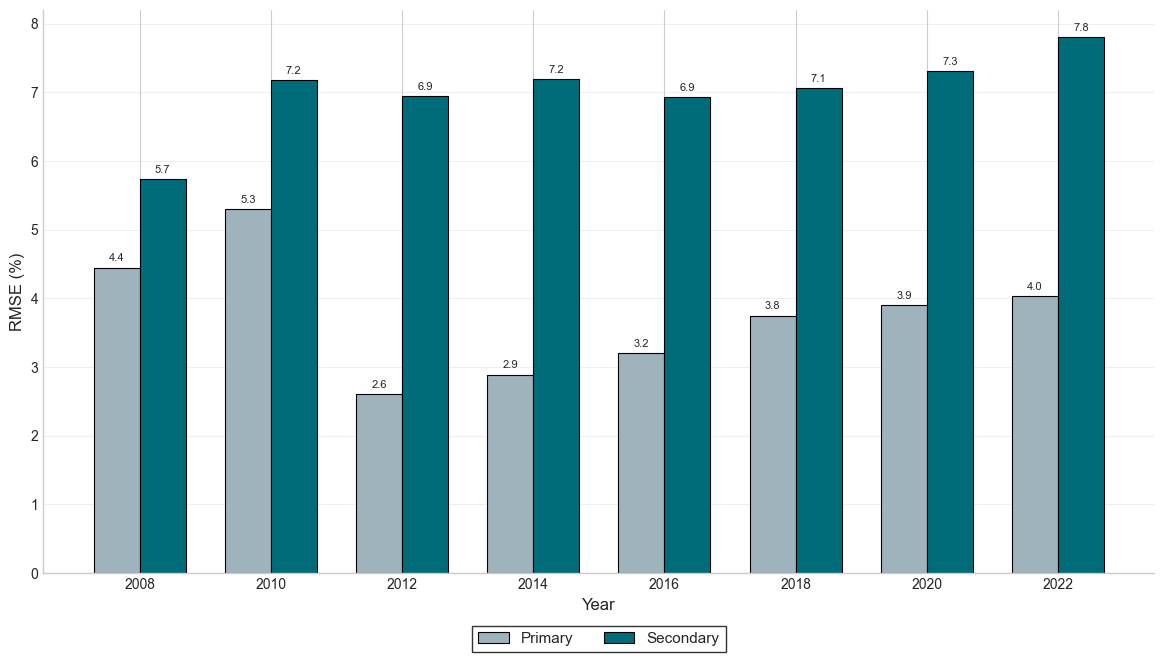

PLOT SAVED: output/primary_vs_secondary_consistent_excl_2006.png

LATEX TABLE SAVED: output/primary_secondary_rmse_by_year.tex

Saved: output/primary_vs_secondary_delta_by_year.png


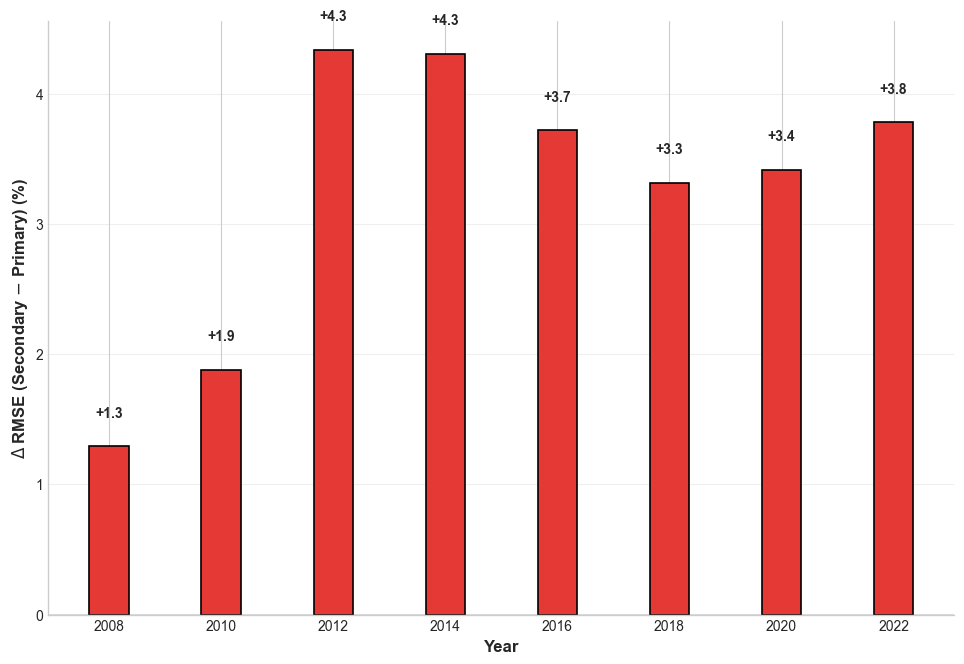

PLOT SAVED: output/primary_vs_secondary_delta_by_year.png

SUMMARY STATISTICS
Primary variables (n=3): ['Age Group', 'Education', 'Sex']
Secondary variables (n=8): ['Employment Status', 'Family Income', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']

Mean RMSE - Primary: 3.77%
Mean RMSE - Secondary: 7.02%
Mean Delta (Secondary - Primary): +3.26%

Delta by year:
  2008: +1.29%
  2010: +1.88%
  2012: +4.34%
  2014: +4.30%
  2016: +3.72%
  2018: +3.32%
  2020: +3.42%
  2022: +3.78%


In [256]:
# =============================================================================
# CONSISTENT PRIMARY VS SECONDARY BY YEAR (EXCLUDING 2006)
# Only includes variables that are consistently Primary/Secondary in 2008-2022
# AND present in every survey year from 2008 onwards
# Excludes 2006 since all variables were Secondary in that year
# =============================================================================

# Get CES-weighted data excluding 2006
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Year'] != 2006)
].copy()

all_years_excl_2006 = set(df_ces['Year'].unique())
years = sorted(all_years_excl_2006)

print(f"Years included: {years}")
print()

# Identify variables that are consistently Primary/Secondary AND present in ALL years (excl 2006)
always_primary = []
always_secondary = []

for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    
    # Must be present in ALL years (excluding 2006)
    if years_present != all_years_excl_2006:
        continue
    
    # Check Variable_Type per year - must be consistent
    types_by_year = var_data.groupby('Year')['Variable_Type'].first().to_dict()
    unique_types = set(types_by_year.values())
    
    if len(unique_types) == 1:
        if 'Primary' in unique_types:
            always_primary.append(var)
        elif 'Secondary' in unique_types:
            always_secondary.append(var)

print(f"Consistent Primary variables (2008-2022): {sorted(always_primary)}")
print(f"Consistent Secondary variables (2008-2022): {sorted(always_secondary)}")
print()

# =============================================================================
# Calculate RMSE for each variable in each year
# =============================================================================

def calc_var_rmse_by_year(df, variables, years):
    """Calculate RMSE for each variable in each year."""
    results = {}
    for var in variables:
        results[var] = {}
        for year in years:
            var_year_data = df[(df['Variable'] == var) & (df['Year'] == year)]
            if len(var_year_data) > 0:
                rmse = np.sqrt(np.mean(var_year_data['Error'] ** 2))
                results[var][year] = rmse
            else:
                results[var][year] = np.nan
    return results

primary_rmse = calc_var_rmse_by_year(df_ces, always_primary, years)
secondary_rmse = calc_var_rmse_by_year(df_ces, always_secondary, years)

# Calculate mean RMSE for primary and secondary in each year
primary_mean_by_year = {}
secondary_mean_by_year = {}
delta_by_year = {}

for year in years:
    primary_vals = [primary_rmse[v][year] for v in always_primary if not np.isnan(primary_rmse[v][year])]
    secondary_vals = [secondary_rmse[v][year] for v in always_secondary if not np.isnan(secondary_rmse[v][year])]
    
    primary_mean_by_year[year] = np.mean(primary_vals) if primary_vals else np.nan
    secondary_mean_by_year[year] = np.mean(secondary_vals) if secondary_vals else np.nan
    
    if not np.isnan(primary_mean_by_year[year]) and not np.isnan(secondary_mean_by_year[year]):
        delta_by_year[year] = secondary_mean_by_year[year] - primary_mean_by_year[year]
    else:
        delta_by_year[year] = np.nan


# PLOT: Primary vs Secondary Bar Chart by Year
# =============================================================================

# Prepare data for plotting
primary_mean_by_year_list = [primary_mean_by_year[y] for y in years]
secondary_mean_by_year_list = [secondary_mean_by_year[y] for y in years]

fig1, ax1 = plt.subplots(figsize=(12, 7))

x = np.arange(len(years))
width = 0.35

# Use lighter grey for Primary
PRIMARY_GREY = '#9FB3BD'  # Lighter grey

bars1 = ax1.bar(x - width/2, primary_mean_by_year_list, width, 
               label='Primary', 
               color=PRIMARY_GREY, 
               edgecolor='black', linewidth=0.8)
bars2 = ax1.bar(x + width/2, secondary_mean_by_year_list, width,
               label='Secondary',
               color=VARIABLE_TYPE_COLORS['Secondary'],
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('RMSE (%)', fontsize=12)

# Horizontal legend at bottom
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2,
           frameon=True, fancybox=False, edgecolor='black', fontsize=11)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig1, 'primary_vs_secondary_consistent_excl_2006.png')
plt.show()

print("="*80)
print("PLOT SAVED: output/primary_vs_secondary_consistent_excl_2006.png")
print("="*80)
print()

# =============================================================================
# Build LaTeX table with SD column
# =============================================================================
latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\caption{Primary vs Secondary Variable RMSE by Year (2008--2022)}")
latex_lines.append(r"\label{tab:primary_secondary_rmse_by_year}")
latex_lines.append(r"\begin{threeparttable}")

# Header - add SD column
year_cols = " & ".join([str(y) for y in years])
latex_lines.append(r"\begin{tabular}{l" + "c" * len(years) + "cc}")  # +2 for Mean and SD
latex_lines.append(r"\toprule")
latex_lines.append(f"Variable & {year_cols} & Mean & SD" + r" \\")
latex_lines.append(r"\midrule")

# Primary section
latex_lines.append(r"\multicolumn{" + str(len(years) + 3) + r"}{l}{\textit{Primary Variables -- Used to Construct CES Weights}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in sorted(always_primary):
    vals = [f"{primary_rmse[var][y]:.1f}" if not np.isnan(primary_rmse[var][y]) else "-" for y in years]
    var_values = [v for v in primary_rmse[var].values() if not np.isnan(v)]
    var_mean = np.mean(var_values)
    var_sd = np.std(var_values) if len(var_values) > 1 else 0
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {var_mean:.1f} & {var_sd:.1f}" + r" \\")

# Primary average - bolded, aligned with variables
latex_lines.append(r"\addlinespace[0.1em]")
primary_vals_str_latex = [r"\textbf{" + f"{primary_mean_by_year[y]:.1f}" + "}" if not np.isnan(primary_mean_by_year[y]) else "-" for y in years]
primary_year_values = [v for v in primary_mean_by_year.values() if not np.isnan(v)]
primary_overall_mean = np.mean(primary_year_values)
primary_overall_sd = np.std(primary_year_values) if len(primary_year_values) > 1 else 0
primary_avg_line = r"~~\textbf{Primary Avg.} & " + " & ".join(primary_vals_str_latex) + r" & \textbf{" + f"{primary_overall_mean:.1f}" + r"} & \textbf{" + f"{primary_overall_sd:.1f}" + r"} \\"
latex_lines.append(primary_avg_line)

latex_lines.append(r"\addlinespace[0.3em]")

# Secondary section
latex_lines.append(r"\multicolumn{" + str(len(years) + 3) + r"}{l}{\textit{Secondary Variables -- Not Used to Construct CES Weights}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in sorted(always_secondary):
    vals = [f"{secondary_rmse[var][y]:.1f}" if not np.isnan(secondary_rmse[var][y]) else "-" for y in years]
    var_values = [v for v in secondary_rmse[var].values() if not np.isnan(v)]
    var_mean = np.mean(var_values)
    var_sd = np.std(var_values) if len(var_values) > 1 else 0
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {var_mean:.1f} & {var_sd:.1f}" + r" \\")

# Secondary average - bolded, aligned with variables
latex_lines.append(r"\addlinespace[0.1em]")
secondary_vals_str_latex = [r"\textbf{" + f"{secondary_mean_by_year[y]:.1f}" + "}" if not np.isnan(secondary_mean_by_year[y]) else "-" for y in years]
secondary_year_values = [v for v in secondary_mean_by_year.values() if not np.isnan(v)]
secondary_overall_mean = np.mean(secondary_year_values)
secondary_overall_sd = np.std(secondary_year_values) if len(secondary_year_values) > 1 else 0
secondary_avg_line = r"~~\textbf{Secondary Avg.} & " + " & ".join(secondary_vals_str_latex) + r" & \textbf{" + f"{secondary_overall_mean:.1f}" + r"} & \textbf{" + f"{secondary_overall_sd:.1f}" + r"} \\"
latex_lines.append(secondary_avg_line)

latex_lines.append(r"\midrule")

# Delta row
delta_vals_str_latex = [f"{delta_by_year[y]:+.1f}" if not np.isnan(delta_by_year[y]) else "-" for y in years]
delta_values_list = [v for v in delta_by_year.values() if not np.isnan(v)]
delta_overall_mean = np.mean(delta_values_list)
delta_overall_sd = np.std(delta_values_list) if len(delta_values_list) > 1 else 0
delta_line = r"\textbf{$\Delta$ (Secondary $-$ Primary)} & " + " & ".join(delta_vals_str_latex) + r" & \textbf{" + f"{delta_overall_mean:+.1f}" + r"} & \textbf{" + f"{delta_overall_sd:.1f}" + r"} \\"
latex_lines.append(delta_line)

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")

latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} 2006 is excluded because the CES does not report post-stratification variables for that year, making it impossible to classify variables consistently as primary or secondary. Variables listed are those that were consistently classified as primary or secondary in every CES wave from 2008 to 2022. Mean and SD are computed across years for each variable.")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)

with open('output/primary_secondary_rmse_by_year.tex', 'w') as f:
    f.write(latex_table)

print("="*80)
print("LATEX TABLE SAVED: output/primary_secondary_rmse_by_year.tex")
print("="*80)
print()

# =============================================================================
# PLOT: Delta (Secondary - Primary) by Year - BAR PLOT
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 7))

# Plot delta as bars
x_positions = np.arange(len(years))
delta_values = [delta_by_year[y] for y in years]

bars = ax.bar(x_positions, delta_values, width=0.35, 
              color=DELTA_COLOR, edgecolor='black', linewidth=1.2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Add value labels
for i, (year, delta) in enumerate(zip(years, delta_values)):
    if not np.isnan(delta):
        ax.text(i, delta + (0.2 if delta > 0 else -0.2), 
                f'{delta:+.1f}', ha='center', 
                va='bottom' if delta > 0 else 'top', fontsize=10, fontweight='bold')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel(r'$\Delta$ RMSE (Secondary $-$ Primary) (%)', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.3)
ax.set_xticks(x_positions)
ax.set_xticklabels(years)

plt.tight_layout()
save_figure(fig, 'primary_vs_secondary_delta_by_year.png')
plt.show()

print("="*80)
print("PLOT SAVED: output/primary_vs_secondary_delta_by_year.png")
print("="*80)
print()

# Summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Primary variables (n={len(always_primary)}): {sorted(always_primary)}")
print(f"Secondary variables (n={len(always_secondary)}): {sorted(always_secondary)}")
print()
print(f"Mean RMSE - Primary: {primary_overall_mean:.2f}%")
print(f"Mean RMSE - Secondary: {secondary_overall_mean:.2f}%")
print(f"Mean Delta (Secondary - Primary): {delta_overall_mean:+.2f}%")
print()
print("Delta by year:")
for year in years:
    print(f"  {year}: {delta_by_year[year]:+.2f}%")

---
# Error Trends Over Time

CONSISTENTLY SECONDARY VARIABLES
N = 8
  - Employment Status (Demographic)
  - Family Income (Demographic)
  - State Representative (Candidate Choice)
  - State Senator (Candidate Choice)
  - U.S. House (Candidate Choice)
  - Union Membership (Demographic)
  - Veteran Status (Demographic)
  - Voting Method (Voting Administration)

VARIABLE-LEVEL RMSE (one obs per variable per year)
N observations: 72
N variables: 8
N years: 9

RMSE BY YEAR AND CLASS (variable-averaged)
Class  Candidate Choice  Demographic  Overall  Voting Administration
Year                                                                
2006               7.66         5.37     6.02                   3.70
2008               6.61         5.44     5.74                   4.34
2010               8.79         6.28     7.18                   5.98
2012               7.86         6.86     6.95                   4.53
2014               9.60         6.35     7.20                   3.37
2016               8.02         6.50     6.

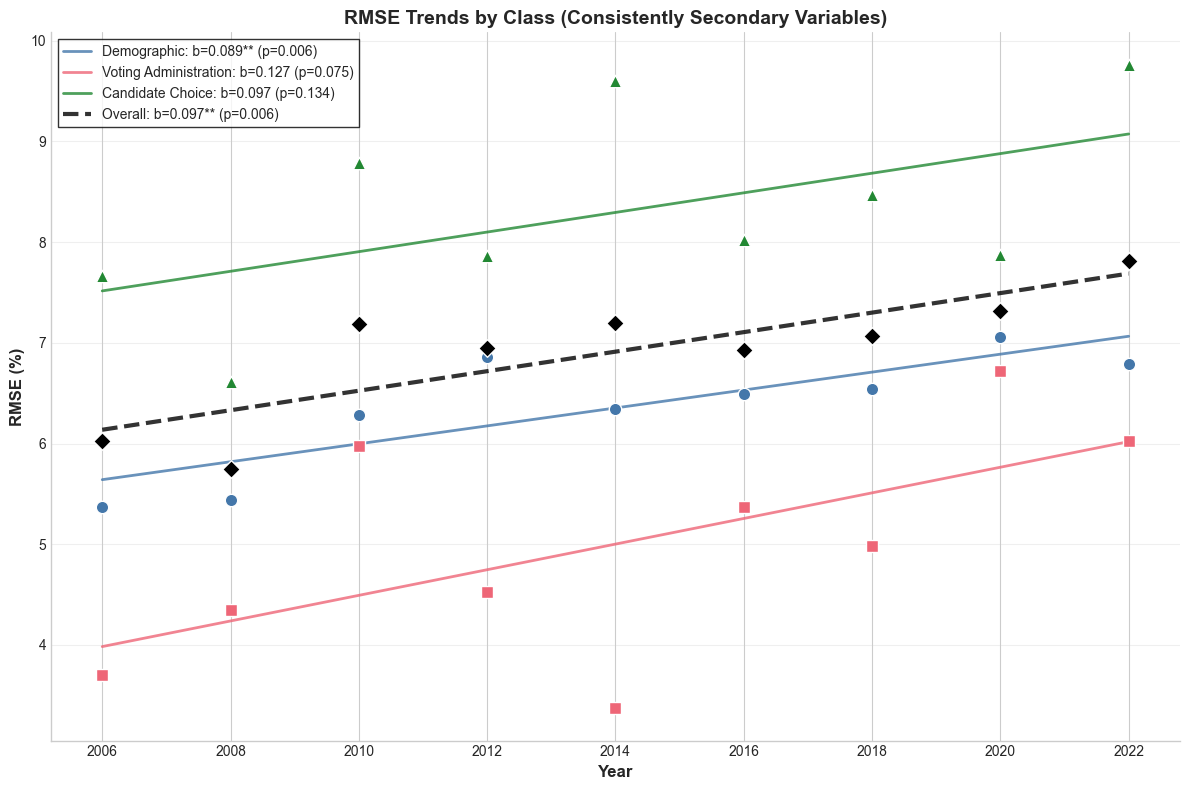


REGRESSION RESULTS: ALL DATA
                Class    Slope       SE  p_value       R2  N_years  N_excluded
          Demographic 0.089012 0.023172 0.006363 0.678255        9           0
Voting Administration 0.127221 0.060795 0.074682 0.384832        9           0
     Candidate Choice 0.097398 0.057471 0.133949 0.290934        9           0
              Overall 0.096933 0.025120 0.006221 0.680226        9           0

EXCLUDED YEARS (2SD within class)
  None excluded
Saved: output/rmse_trends_secondary_exclude_2sd.png


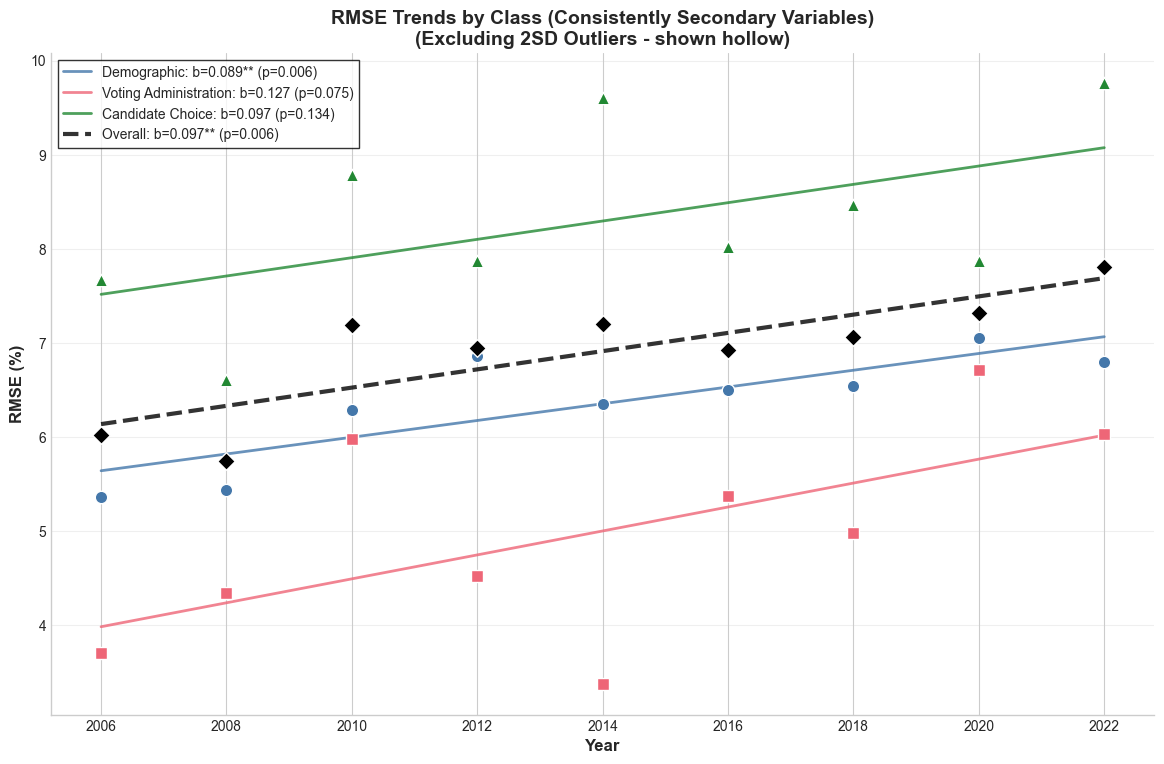


REGRESSION RESULTS: EXCLUDING 2SD OUTLIERS
                Class    Slope       SE  p_value       R2  N_years  N_excluded
          Demographic 0.089012 0.023172 0.006363 0.678255        9           0
Voting Administration 0.127221 0.060795 0.074682 0.384832        9           0
     Candidate Choice 0.097398 0.057471 0.133949 0.290934        9           0
              Overall 0.096933 0.025120 0.006221 0.680226        9           0


In [257]:
# =============================================================================
# RMSE TRENDS OVER TIME: CONSISTENTLY SECONDARY VARIABLES
# =============================================================================
# Consistently secondary = always Secondary AND present in every survey year
# Analysis includes:
#   1. Plot with all data - per-class and overall regressions
#   2. Plot excluding 2SD outlier years (excluded points shown as hollow)
# SD is calculated WITHIN each class separately
#
# METHODOLOGY: 
#   1. Calculate RMSE for each variable in each year (one obs per variable-year)
#   2. For per-class: average variable RMSEs within each class
#   3. For overall: average all variable RMSEs (each variable contributes once)
# =============================================================================

from scipy import stats
import statsmodels.formula.api as smf

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years_sorted = sorted(all_years)

# =============================================================================
# IDENTIFY CONSISTENTLY SECONDARY VARIABLES
# =============================================================================
consistently_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        consistently_secondary.append(var)

print("="*80)
print("CONSISTENTLY SECONDARY VARIABLES")
print("="*80)
print(f"N = {len(consistently_secondary)}")
for v in sorted(consistently_secondary):
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

# Filter to consistently secondary variables
df_secondary = df_ces[df_ces['Variable'].isin(consistently_secondary)].copy()

# =============================================================================
# STEP 1: Calculate RMSE for each variable in each year
# =============================================================================
def calc_rmse(errors):
    return np.sqrt(np.mean(errors ** 2))

# One observation per variable-year
rmse_by_var_year = df_secondary.groupby(['Year', 'Variable', 'Class']).apply(
    lambda x: calc_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')

print("\n" + "="*80)
print("VARIABLE-LEVEL RMSE (one obs per variable per year)")
print("="*80)
print(f"N observations: {len(rmse_by_var_year)}")
print(f"N variables: {rmse_by_var_year['Variable'].nunique()}")
print(f"N years: {rmse_by_var_year['Year'].nunique()}")

# =============================================================================
# STEP 2: Average within class (or overall)
# =============================================================================
# Per class: average variable RMSEs within each class
rmse_by_class_year = rmse_by_var_year.groupby(['Year', 'Class'])['RMSE'].mean().reset_index()

# Overall: average all variable RMSEs (each variable contributes once)
rmse_overall_year = rmse_by_var_year.groupby('Year')['RMSE'].mean().reset_index()
rmse_overall_year['Class'] = 'Overall'

# Combine
rmse_data = pd.concat([rmse_by_class_year, rmse_overall_year], ignore_index=True)

print("\n" + "="*80)
print("RMSE BY YEAR AND CLASS (variable-averaged)")
print("="*80)
pivot = rmse_data.pivot(index='Year', columns='Class', values='RMSE')
print(pivot.round(2).to_string())

# =============================================================================
# HELPER FUNCTION: Identify outlier years (within each class)
# =============================================================================
def identify_outliers_within_class(data, n_sd=2):
    """Identify years that are > n_sd standard deviations from per-class mean.
    SD is calculated WITHIN each class separately."""
    data = data.copy()
    data['is_outlier'] = False
    
    for cls in data['Class'].unique():
        cls_mask = data['Class'] == cls
        cls_data = data.loc[cls_mask, 'RMSE']
        mean_rmse = cls_data.mean()
        std_rmse = cls_data.std()
        
        lower = mean_rmse - n_sd * std_rmse
        upper = mean_rmse + n_sd * std_rmse
        
        outlier_mask = cls_mask & ((data['RMSE'] < lower) | (data['RMSE'] > upper))
        data.loc[outlier_mask, 'is_outlier'] = True
    
    return data

# =============================================================================
# HELPER FUNCTION: Create plot with regressions (showing excluded as hollow)
# =============================================================================
def create_trend_plot_with_outliers(data, title_suffix="", ax=None, show_outliers_hollow=False):
    """Create RMSE trend plot with per-class and overall regressions.
    If show_outliers_hollow=True, excluded points are shown as hollow markers."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.get_figure()
    
    classes = ['Demographic', 'Voting Administration', 'Candidate Choice', 'Overall']
    colors = {
        'Demographic': CLASS_COLORS['Demographic'],
        'Voting Administration': CLASS_COLORS['Voting Administration'],
        'Candidate Choice': CLASS_COLORS['Candidate Choice'],
        'Overall': '#000000'
    }
    markers = {'Demographic': 'o', 'Voting Administration': 's', 'Candidate Choice': '^', 'Overall': 'D'}
    
    results = []
    
    for cls in classes:
        cls_data = data[data['Class'] == cls].sort_values('Year')
        if len(cls_data) < 2:
            continue
        
        # Separate included and excluded points
        if show_outliers_hollow and 'is_outlier' in cls_data.columns:
            included = cls_data[~cls_data['is_outlier']]
            excluded = cls_data[cls_data['is_outlier']]
        else:
            included = cls_data
            excluded = pd.DataFrame()
        
        # Plot included points (filled)
        if len(included) > 0:
            ax.scatter(included['Year'].values, included['RMSE'].values, 
                       color=colors[cls], s=80, marker=markers[cls], 
                       zorder=5, edgecolors='white', linewidth=1)
        
        # Plot excluded points (hollow - outline only)
        if len(excluded) > 0:
            ax.scatter(excluded['Year'].values, excluded['RMSE'].values,
                       facecolors='none', edgecolors=colors[cls], s=80, 
                       marker=markers[cls], zorder=5, linewidth=2)
        
        # Use only included points for regression
        if len(included) >= 2:
            x = included['Year'].values
            y = included['RMSE'].values
            
            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Significance marker
            if p_value < 0.001:
                sig = '***'
            elif p_value < 0.01:
                sig = '**'
            elif p_value < 0.05:
                sig = '*'
            else:
                sig = ''
            
            # Regression line (extend across all years for visual continuity)
            all_years_cls = cls_data['Year'].values
            x_line = np.array([min(all_years_cls), max(all_years_cls)])
            y_line = slope * x_line + intercept
            linestyle = '-' if cls != 'Overall' else '--'
            linewidth = 2 if cls != 'Overall' else 3
            ax.plot(x_line, y_line, color=colors[cls], linewidth=linewidth, 
                    linestyle=linestyle, alpha=0.8,
                    label=f'{cls}: b={slope:.3f}{sig} (p={p_value:.3f})')
            
            results.append({
                'Class': cls,
                'Slope': slope,
                'SE': std_err,
                'p_value': p_value,
                'R2': r_value**2,
                'N_years': len(included),
                'N_excluded': len(excluded)
            })
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'RMSE Trends by Class (Consistently Secondary Variables){title_suffix}',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    ax.set_xticks(sorted(data['Year'].unique()))
    
    return pd.DataFrame(results)

# =============================================================================
# PLOT 1: ALL DATA
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(12, 8))
results_all = create_trend_plot_with_outliers(rmse_data, "", ax1, show_outliers_hollow=False)
plt.tight_layout()
# Combined figure created in next cell
plt.show()

print("\n" + "="*80)
print("REGRESSION RESULTS: ALL DATA")
print("="*80)
print(results_all.to_string(index=False))

# =============================================================================
# PLOT 2: EXCLUDING 2SD OUTLIERS (within each class)
# =============================================================================
rmse_2sd = identify_outliers_within_class(rmse_data, n_sd=2)
excluded_2sd = rmse_2sd[rmse_2sd['is_outlier']]

print("\n" + "="*80)
print("EXCLUDED YEARS (2SD within class)")
print("="*80)
if len(excluded_2sd) > 0:
    for _, row in excluded_2sd.iterrows():
        print(f"  {row['Class']}: {int(row['Year'])} (RMSE={row['RMSE']:.2f})")
else:
    print("  None excluded")

fig2, ax2 = plt.subplots(figsize=(12, 8))
results_2sd = create_trend_plot_with_outliers(rmse_2sd, "\n(Excluding 2SD Outliers - shown hollow)", ax2, show_outliers_hollow=True)
plt.tight_layout()
save_figure(fig2, 'rmse_trends_secondary_exclude_2sd.png')
plt.show()

print("\n" + "="*80)
print("REGRESSION RESULTS: EXCLUDING 2SD OUTLIERS")
print("="*80)
print(results_2sd.to_string(index=False))


AGGREGATED DATA: Year x Variable Level
N observations (year x variable): 72
N years: 9
N variables: 8
Center year: 2014.0

FIXED EFFECTS REGRESSION: RMSE ~ Year + Variable FE

Year coefficient (b): 0.0969% RMSE per year
Robust SE (HC3): 0.0437
t-statistic: 2.216
p-value: 0.0267
95% CI: [0.0112, 0.1827]
R-squared (with variable FE): 0.7019

Interpretation: RMSE is increasing by 0.097 percentage points per year

PERMUTATION TEST (10,000 permutations)
Observed b: 0.0969
Permutation distribution: mean=0.0008, SD=0.0417
Permutation p-value (two-sided): 0.0040

SUMMARY: RMSE TREND ANALYSIS
Method                                   b            SE           p-value     
--------------------------------------------------------------------------------
Fixed Effects OLS (HC3 SEs)              0.0969       0.0437       0.0267      
Permutation Test (n=10,000)              0.0969       -            0.0040      
Saved: output/rmse_trend_fe_permutation.png


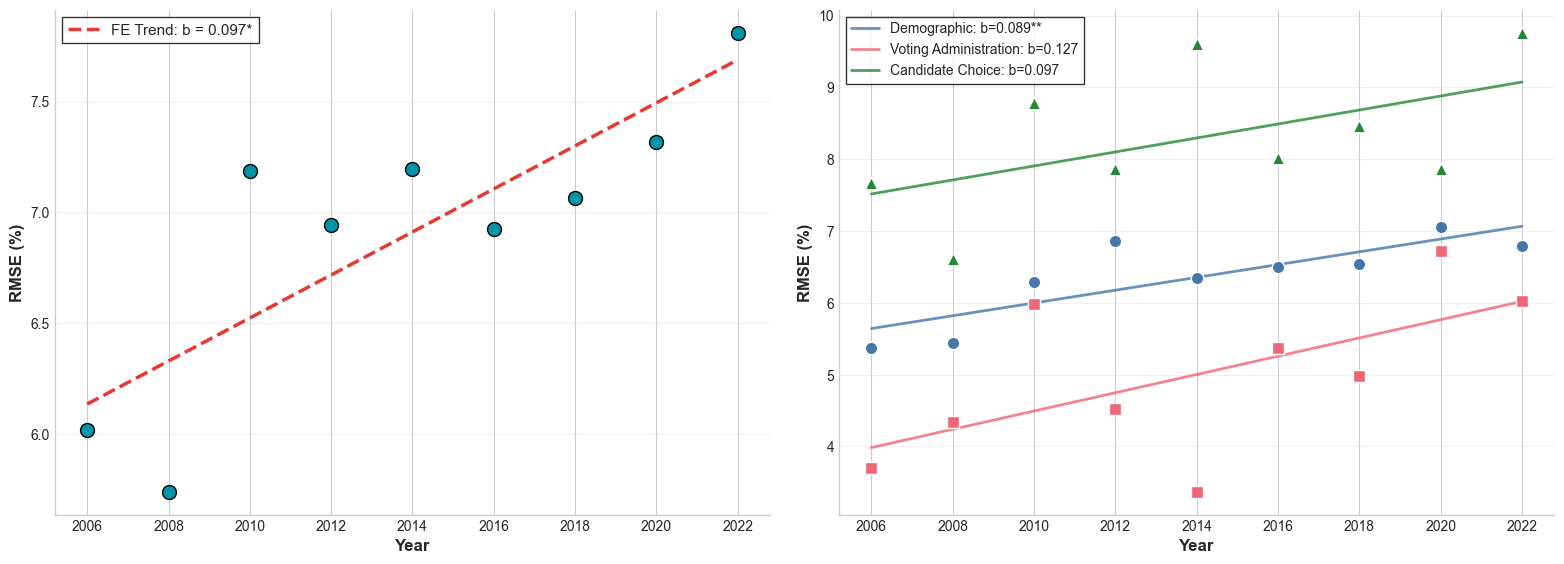


YEARLY MEAN RMSE VALUES (Panel A)
Each dot = mean RMSE across all consistently secondary variables for that year
Variables included: ['Employment Status', 'Family Income', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']

  2006: 6.02%
  2008: 5.74%
  2010: 7.18%
  2012: 6.95%
  2014: 7.20%
  2016: 6.93%
  2018: 7.07%
  2020: 7.32%
  2022: 7.81%


In [258]:
# =============================================================================
# FIXED EFFECTS REGRESSION + PERMUTATION TESTING
# =============================================================================
# Uses the consistently secondary variables identified above
# Fixed effects on Variable controls for baseline differences between variables
# Permutation test provides non-parametric p-value for the year trend
# =============================================================================

import statsmodels.formula.api as smf
from scipy import stats

# =============================================================================
# AGGREGATE TO YEAR x VARIABLE LEVEL
# =============================================================================
agg_data = df_secondary.groupby(['Year', 'Variable']).agg(
    RMSE=('Error', lambda x: np.sqrt(np.mean(x ** 2))),
    N=('Error', 'count')
).reset_index()

center_year = agg_data['Year'].median()
agg_data['Year_centered'] = agg_data['Year'] - center_year

print("="*80)
print("AGGREGATED DATA: Year x Variable Level")
print("="*80)
print(f"N observations (year x variable): {len(agg_data)}")
print(f"N years: {agg_data['Year'].nunique()}")
print(f"N variables: {agg_data['Variable'].nunique()}")
print(f"Center year: {center_year}")

# =============================================================================
# FIXED EFFECTS REGRESSION
# =============================================================================
print("\n" + "="*80)
print("FIXED EFFECTS REGRESSION: RMSE ~ Year + Variable FE")
print("="*80)

model = smf.ols("RMSE ~ Year_centered + C(Variable)", data=agg_data)
result_ols = model.fit()
result_hc3 = model.fit(cov_type='HC3')

beta = result_hc3.params['Year_centered']
beta_se = result_hc3.bse['Year_centered']
beta_pval = result_hc3.pvalues['Year_centered']
beta_ci = result_hc3.conf_int().loc['Year_centered']

print(f"\nYear coefficient (b): {beta:.4f}% RMSE per year")
print(f"Robust SE (HC3): {beta_se:.4f}")
print(f"t-statistic: {beta / beta_se:.3f}")
print(f"p-value: {beta_pval:.4f}")
print(f"95% CI: [{beta_ci[0]:.4f}, {beta_ci[1]:.4f}]")
print(f"R-squared (with variable FE): {result_hc3.rsquared:.4f}")

# Interpretation
direction = "increasing" if beta > 0 else "decreasing"
print(f"\nInterpretation: RMSE is {direction} by {abs(beta):.3f} percentage points per year")

# =============================================================================
# PERMUTATION TEST
# =============================================================================
print("\n" + "="*80)
print("PERMUTATION TEST (10,000 permutations)")
print("="*80)

np.random.seed(42)
n_perms = 10000
observed_beta = beta

perm_betas = []
years = agg_data['Year'].unique()

for i in range(n_perms):
    # Permute year labels
    year_mapping = dict(zip(years, np.random.permutation(years)))
    agg_perm = agg_data.copy()
    agg_perm['Year_perm'] = agg_perm['Year'].map(year_mapping)
    agg_perm['Year_centered_perm'] = agg_perm['Year_perm'] - center_year
    
    # Fit model
    model_perm = smf.ols("RMSE ~ Year_centered_perm + C(Variable)", data=agg_perm)
    result_perm = model_perm.fit()
    perm_betas.append(result_perm.params['Year_centered_perm'])

perm_betas = np.array(perm_betas)
perm_pval = np.mean(np.abs(perm_betas) >= np.abs(observed_beta))

print(f"Observed b: {observed_beta:.4f}")
print(f"Permutation distribution: mean={np.mean(perm_betas):.4f}, SD={np.std(perm_betas):.4f}")
print(f"Permutation p-value (two-sided): {perm_pval:.4f}")

# =============================================================================
# SUMMARY TABLE
# =============================================================================
print("\n" + "="*80)
print("SUMMARY: RMSE TREND ANALYSIS")
print("="*80)
print(f"{'Method':<40} {'b':<12} {'SE':<12} {'p-value':<12}")
print("-"*80)
print(f"{'Fixed Effects OLS (HC3 SEs)':<40} {beta:<12.4f} {beta_se:<12.4f} {beta_pval:<12.4f}")
print(f"{'Permutation Test (n=10,000)':<40} {observed_beta:<12.4f} {'-':<12} {perm_pval:<12.4f}")

# =============================================================================
# COMBINED FIGURE: Panel A (FE Trend) and Panel B (By Class)
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# -----------------------------------------------------------------------------
# Panel A: RMSE Trend with FE Estimate
# -----------------------------------------------------------------------------
yearly_rmse = agg_data.groupby('Year')['RMSE'].mean()
x_years = yearly_rmse.index.values
y_rmse = yearly_rmse.values

ax1.scatter(x_years, y_rmse, s=100, color=WEIGHTING_COLORS['CES-Provided Weights'], edgecolors='black', linewidth=1, zorder=5)

# Add FE regression line
mean_rmse = agg_data['RMSE'].mean()
x_line = np.array([min(x_years), max(x_years)])
y_line = mean_rmse + beta * (x_line - center_year)
# Significance stars for FE trend
if beta_pval < 0.001:
    fe_sig = '***'
elif beta_pval < 0.01:
    fe_sig = '**'
elif beta_pval < 0.05:
    fe_sig = '*'
else:
    fe_sig = ''

ax1.plot(x_line, y_line, color=DELTA_COLOR, linewidth=2.5, linestyle='--',
         label=f'FE Trend: b = {beta:.3f}{fe_sig}')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11, frameon=True, fancybox=False, edgecolor='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_xticks(x_years)

# -----------------------------------------------------------------------------
# Panel B: RMSE Trends by Class
# -----------------------------------------------------------------------------
# Create rmse_data for per-class analysis (same variables as Panel A)
rmse_by_var_year = df_secondary.groupby(['Year', 'Variable', 'Class']).apply(
    lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False
).reset_index(name='RMSE')

rmse_by_class_year = rmse_by_var_year.groupby(['Year', 'Class'])['RMSE'].mean().reset_index()
rmse_data = rmse_by_class_year  # Only per-class data needed for Panel B
classes = ['Demographic', 'Voting Administration', 'Candidate Choice']
colors = {
    'Demographic': CLASS_COLORS['Demographic'],
    'Voting Administration': CLASS_COLORS['Voting Administration'],
    'Candidate Choice': CLASS_COLORS['Candidate Choice'],
    'Overall': '#000000'
}
markers = {'Demographic': 'o', 'Voting Administration': 's', 'Candidate Choice': '^', 'Overall': 'D'}

for cls in classes:
    cls_data = rmse_data[rmse_data['Class'] == cls].sort_values('Year')
    if len(cls_data) < 2:
        continue
    
    # Plot points
    ax2.scatter(cls_data['Year'].values, cls_data['RMSE'].values, 
               color=colors[cls], s=80, marker=markers[cls], 
               zorder=5, edgecolors='white', linewidth=1)
    
    # Linear regression
    x = cls_data['Year'].values
    y = cls_data['RMSE'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Significance marker
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    # Regression line
    x_line = np.array([min(x), max(x)])
    y_line = slope * x_line + intercept
    linestyle = '-' if cls != 'Overall' else '--'
    linewidth = 2 if cls != 'Overall' else 3
    ax2.plot(x_line, y_line, color=colors[cls], linewidth=linewidth, 
            linestyle=linestyle, alpha=0.8,
            label=f'{cls}: b={slope:.3f}{sig}')

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.3)
ax2.set_xticks(sorted(rmse_data['Year'].unique()))

plt.tight_layout()
save_figure(fig, 'rmse_trend_fe_permutation.png')
plt.show()

# Print yearly values for reference
print("\n" + "="*80)
print("YEARLY MEAN RMSE VALUES (Panel A)")
print("="*80)
print("Each dot = mean RMSE across all consistently secondary variables for that year")
print("Variables included:", sorted(agg_data['Variable'].unique()))
print()
for year in sorted(x_years):
    print(f"  {int(year)}: {yearly_rmse[year]:.2f}%")

In [259]:
# =============================================================================
# LATEX TABLE: Summary of Trend Statistical Tests
# =============================================================================
# Collects results from:
#   - Cell 18: results_all (per-class and overall simple OLS)
#   - Cell 19: beta, beta_se, beta_pval, perm_pval (Variable FE)
# =============================================================================

print("="*80)
print("GENERATING LATEX TABLE FOR PAPER")
print("="*80)

latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\caption{Secondary Variable RMSE Trends Over Time}")
latex_lines.append(r"\label{tab:rmse_trend_tests}")
latex_lines.append(r"\begin{threeparttable}")
latex_lines.append(r"\begin{tabular}{lcccc}")
latex_lines.append(r"\toprule")
latex_lines.append(r"Model & $\beta$ & SE & $p$-value & Perm. $p$ \\")
latex_lines.append(r"\midrule")

# Panel A: Fixed Effects Model (now first)
latex_lines.append(r"\multicolumn{5}{l}{\textit{Panel A: Fixed Effects Model}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

# Variable FE
if beta_pval < 0.001:
    sig_v = '***'
elif beta_pval < 0.01:
    sig_v = '**'
elif beta_pval < 0.05:
    sig_v = '*'
else:
    sig_v = ''
pval_v_str = f"{beta_pval:.3f}" if beta_pval >= 0.001 else "<0.001"
perm_v_str = f"{perm_pval:.3f}" if perm_pval >= 0.001 else "<0.001"
latex_lines.append(f"~~Variable FE & {beta:.4f}{sig_v} & {beta_se:.4f} & {pval_v_str} & {perm_v_str} \\\\")

latex_lines.append(r"\addlinespace[0.3em]")

# Panel B: Simple OLS by Class (now second)
latex_lines.append(r"\multicolumn{5}{l}{\textit{Panel B: Simple OLS by Class}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for _, row in results_all.iterrows():
    cls = row['Class']
    slope = row['Slope']
    se = row['SE']
    pval = row['p_value']
    
    # Significance stars
    if pval < 0.001:
        sig = '***'
    elif pval < 0.01:
        sig = '**'
    elif pval < 0.05:
        sig = '*'
    else:
        sig = ''
    
    pval_str = f"{pval:.3f}" if pval >= 0.001 else "<0.001"
    latex_lines.append(f"~~{cls} & {slope:.4f}{sig} & {se:.4f} & {pval_str} & -- \\\\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} $\beta$ represents the change in RMSE (percentage points) per year.")
latex_lines.append(r"\item Panel A reports OLS with variable fixed effects, controlling for baseline differences between 8 consistently Secondary variables.")
latex_lines.append(r"\item Panel B reports simple OLS regressions of mean RMSE on year, separately by variable class.")
latex_lines.append(r"\item Robust standard errors (HC3) used for all models. Permutation $p$-value based on 10,000 permutations.")
latex_lines.append(r"\item * $p<0.05$, ** $p<0.01$, *** $p<0.001$")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)

with open('output/rmse_trend_tests.tex', 'w') as f:
    f.write(latex_table)

print("Saved: output/rmse_trend_tests.tex")
print()
print(latex_table)

GENERATING LATEX TABLE FOR PAPER
Saved: output/rmse_trend_tests.tex

\begin{table}[!htbp]
\centering
\caption{Secondary Variable RMSE Trends Over Time}
\label{tab:rmse_trend_tests}
\begin{threeparttable}
\begin{tabular}{lcccc}
\toprule
Model & $\beta$ & SE & $p$-value & Perm. $p$ \\
\midrule
\multicolumn{5}{l}{\textit{Panel A: Fixed Effects Model}} \\
\addlinespace[0.2em]
~~Variable FE & 0.0969* & 0.0437 & 0.027 & 0.004 \\
\addlinespace[0.3em]
\multicolumn{5}{l}{\textit{Panel B: Simple OLS by Class}} \\
\addlinespace[0.2em]
~~Demographic & 0.0890** & 0.0232 & 0.006 & -- \\
~~Voting Administration & 0.1272 & 0.0608 & 0.075 & -- \\
~~Candidate Choice & 0.0974 & 0.0575 & 0.134 & -- \\
~~Overall & 0.0969** & 0.0251 & 0.006 & -- \\
\bottomrule
\end{tabular}
\begin{tablenotes}
\footnotesize
\item \textit{Note:} $\beta$ represents the change in RMSE (percentage points) per year.
\item Panel A reports OLS with variable fixed effects, controlling for baseline differences between 8 consistently 

UNWEIGHTED ANALYSIS - Secondary Variables Present in All Years
Variables: ['State Representative', 'State Senator', 'U.S. House', 'Employment Status', 'Family Income', 'Union Membership', 'Veteran Status', 'Voting Method']
N observations (year × variable): 72

PRIMARY MODEL (HC3 Robust SEs) - UNWEIGHTED
Year slope (β): 0.1498% RMSE per year
Robust SE: 0.0577
p-value: 0.0094
95% CI: [0.0368, 0.2629]

Permutation p-value: 0.0125
Saved: output/rmse_trend_primary_analysis_unweighted.png


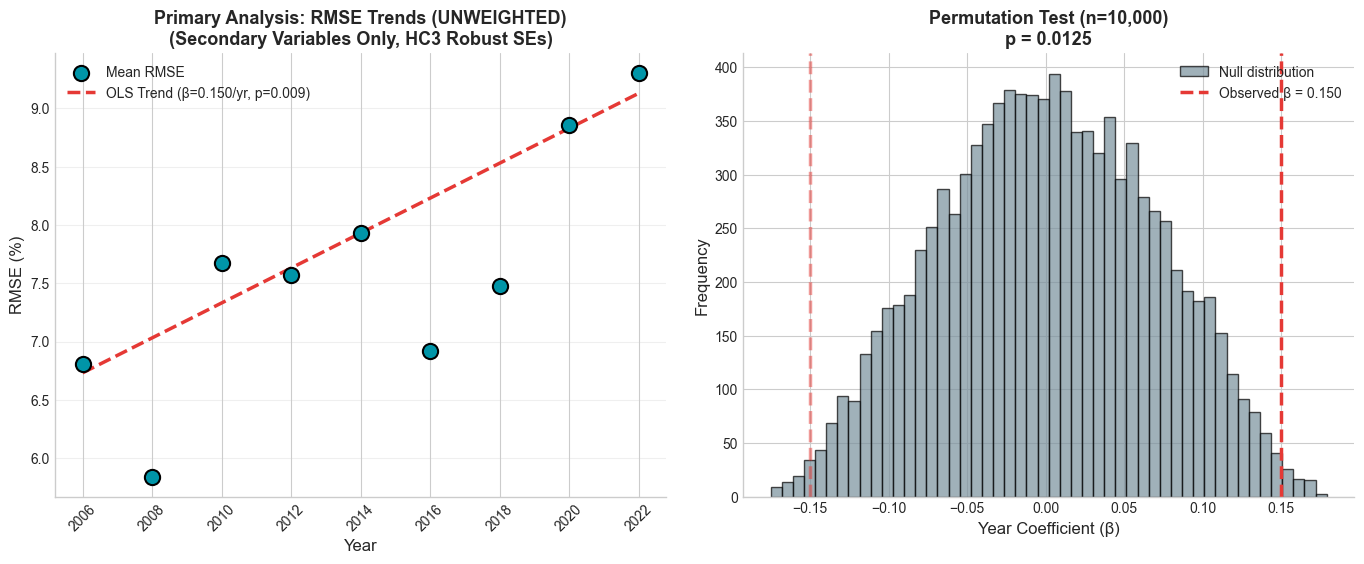


Saved: output/rmse_trend_primary_analysis_unweighted.png


In [260]:
# =============================================================================
# PRIMARY ANALYSIS: RMSE TRENDS OVER TIME (UNWEIGHTED)
# =============================================================================
# Same analysis as weighted, but using CES-Unweighted (matching only)
# =============================================================================

# Filter for UNWEIGHTED, All validity scheme
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years_uw = set(df_unweighted['Year'].unique())

# Identify always-secondary variables present in all years
always_secondary_uw = []
for var in df_unweighted['Variable'].unique():
    var_data = df_unweighted[df_unweighted['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years_uw
    
    if is_always_secondary and is_all_years:
        always_secondary_uw.append(var)

print("="*80)
print("UNWEIGHTED ANALYSIS - Secondary Variables Present in All Years")
print("="*80)
print(f"Variables: {always_secondary_uw}")

df_secondary_uw = df_unweighted[df_unweighted['Variable'].isin(always_secondary_uw)].copy()

# Aggregate
agg_data_uw = df_secondary_uw.groupby(['Year', 'Variable', 'Class']).agg(
    RMSE=('Error', lambda x: np.sqrt(np.mean(x ** 2))),
    N=('Error', 'count')
).reset_index()

center_year_uw = agg_data_uw['Year'].median()
agg_data_uw['Year_centered'] = agg_data_uw['Year'] - center_year_uw

print(f"N observations (year × variable): {len(agg_data_uw)}")

# Primary model
model_uw = smf.ols("RMSE ~ Year_centered + C(Variable)", data=agg_data_uw)
result_hc3_uw = model_uw.fit(cov_type='HC3')

beta_uw = result_hc3_uw.params['Year_centered']
beta_se_uw = result_hc3_uw.bse['Year_centered']
beta_pval_uw = result_hc3_uw.pvalues['Year_centered']
beta_ci_uw = result_hc3_uw.conf_int().loc['Year_centered']

print()
print("="*80)
print("PRIMARY MODEL (HC3 Robust SEs) - UNWEIGHTED")
print("="*80)
print(f"Year slope (β): {beta_uw:.4f}% RMSE per year")
print(f"Robust SE: {beta_se_uw:.4f}")
print(f"p-value: {beta_pval_uw:.4f}")
print(f"95% CI: [{beta_ci_uw[0]:.4f}, {beta_ci_uw[1]:.4f}]")

# Permutation test
np.random.seed(42)
n_perms = 10000
perm_betas_uw = []
years_uw = agg_data_uw['Year'].unique()

for _ in range(n_perms):
    year_mapping = dict(zip(years_uw, np.random.permutation(years_uw)))
    agg_perm = agg_data_uw.copy()
    agg_perm['Year_perm'] = agg_perm['Year'].map(year_mapping)
    agg_perm['Year_centered_perm'] = agg_perm['Year_perm'] - center_year_uw
    
    model_perm = smf.ols("RMSE ~ Year_centered_perm + C(Variable)", data=agg_perm)
    result_perm = model_perm.fit()
    perm_betas_uw.append(result_perm.params['Year_centered_perm'])

perm_betas_uw = np.array(perm_betas_uw)
perm_pval_uw = np.mean(np.abs(perm_betas_uw) >= np.abs(beta_uw))

print()
print(f"Permutation p-value: {perm_pval_uw:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
years_list_uw = sorted(agg_data_uw['Year'].unique())
year_rmse_uw = agg_data_uw.groupby('Year')['RMSE'].mean()

ax1.scatter(years_list_uw, [year_rmse_uw[y] for y in years_list_uw], s=120, color=WEIGHTING_COLORS['CES-Provided Weights'], 
            edgecolor='black', linewidth=1.5, zorder=5, label='Mean RMSE')

year_range_uw = np.array([min(years_list_uw), max(years_list_uw)])
year_range_centered_uw = year_range_uw - center_year_uw
# Use actual mean RMSE at center year as baseline
baseline_uw = year_rmse_uw[center_year_uw]
trend_line_uw = baseline_uw + beta_uw * year_range_centered_uw
ax1.plot(year_range_uw, trend_line_uw, '--', color=DELTA_COLOR, linewidth=2.5, 
         label=f'OLS Trend (β={beta_uw:.3f}/yr, p={beta_pval_uw:.3f})')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('Primary Analysis: RMSE Trends (UNWEIGHTED)\n(Secondary Variables Only, HC3 Robust SEs)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.set_xticks(years_list_uw)
ax1.set_xticklabels([str(y) for y in years_list_uw], rotation=45)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

ax2 = axes[1]
ax2.hist(perm_betas_uw, bins=50, color='#78909C', edgecolor='black', alpha=0.7, label='Null distribution')
ax2.axvline(beta_uw, color=DELTA_COLOR, linewidth=2.5, linestyle='--', label=f'Observed β = {beta_uw:.3f}')
ax2.axvline(-beta_uw, color=DELTA_COLOR, linewidth=2.5, linestyle='--', alpha=0.5)

ax2.set_xlabel('Year Coefficient (β)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Permutation Test (n=10,000)\np = {perm_pval_uw:.4f}', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig, 'rmse_trend_primary_analysis_unweighted.png')
plt.show()

print("\nSaved: output/rmse_trend_primary_analysis_unweighted.png")

---
# Weighting Method Comparison: Error Reduction

---
# ANESRake Full vs Restricted Comparison

---
# Candidate vs Party Specificity

---
# RMSE by Office and Year Heatmap

---
# RMSE Excluding Voter Registration and Turnout

In [261]:
# ============================================================
# FIGURE 1A REPLICA: RMSE by Variable and Year
# (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)
# ============================================================

print("="*100)
print("FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)")
print("="*100)

# Filter for Matching + Post-Stratification, All validity, EXCLUDING the two high-error variables
df_excl = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (~most_specific['Variable'].isin(['Voter Registration', 'Voting Turnout']))
].copy()

print(f"\nTotal observations: {len(df_excl):,}")
print(f"Variables excluded: Voter Registration, Voting Turnout\n")

# Calculate RMSE by Year and Variable
rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type for each cell
type_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

class_map_excl = rmse_by_var_year_excl.groupby('Variable')['Class'].first().to_dict()

rmse_pivot_excl = sort_variables(rmse_pivot_excl.reset_index()).set_index('Variable')
type_pivot_excl = sort_variables(type_pivot_excl.reset_index()).set_index('Variable')

years_excl = sorted([c for c in rmse_pivot_excl.columns if isinstance(c, (int, float))])

rmse_pivot_excl['Average'] = rmse_pivot_excl[years_excl].mean(axis=1)

avg_row_excl = rmse_pivot_excl.mean(axis=0)
avg_row_excl.name = 'Average'
rmse_pivot_with_avg_excl = pd.concat([rmse_pivot_excl, avg_row_excl.to_frame().T])

# Calculate class subtotals
class_values_excl = {cls: {year: [] for year in years_excl} for cls in class_order}
for var in rmse_pivot_excl.index:
    var_class = class_map_excl.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years_excl:
        val = rmse_pivot_excl.loc[var, year]
        if not pd.isna(val):
            class_values_excl[var_class][year].append(val)

class_subtotals_excl = {}
for cls in class_order:
    class_subtotals_excl[cls] = {}
    for year in years_excl:
        vals = class_values_excl[cls][year]
        class_subtotals_excl[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_excl[cls][y] for y in years_excl if not pd.isna(class_subtotals_excl[cls][y])]
    class_subtotals_excl[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Print formatted table
print("\n")
header = "{:<25}".format("Variable")
for year in years_excl:
    header += " {:>6}".format(str(int(year)))
header += " {:>12}".format("Yearly Mean")
print(header)
print("-" * len(header))

for cls in class_order:
    print(f"\n{cls}")
    
    for var in rmse_pivot_excl.index:
        var_class = class_map_excl.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row = "  {:<23}".format(var)
        for year in years_excl:
            val = rmse_pivot_excl.loc[var, year]
            if pd.isna(val):
                row += " {:>6}".format("-")
            else:
                var_type = type_pivot_excl.loc[var, year] if var in type_pivot_excl.index and year in type_pivot_excl.columns else None
                if var_type == 'Primary':
                    row += " {:>5}†".format(f"{val:.1f}")
                else:
                    row += " {:>6}".format(f"{val:.1f}")
        row_avg = rmse_pivot_with_avg_excl.loc[var, 'Average']
        if pd.isna(row_avg):
            row += " {:>12}".format("-")
        else:
            row += " {:>12}".format(f"{row_avg:.1f}")
        print(row)
    
    # Class average
    row = "  {:<23}".format(f"{cls} Avg.")
    for year in years_excl:
        val = class_subtotals_excl[cls][year]
        if pd.isna(val):
            row += " {:>6}".format("-")
        else:
            row += " {:>6}".format(f"{val:.1f}")
    row_avg = class_subtotals_excl[cls]['row_avg']
    if pd.isna(row_avg):
        row += " {:>12}".format("-")
    else:
        row += " {:>12}".format(f"{row_avg:.1f}")
    print(row)

# Yearly RMSE row
print("-" * len(header))
row = "{:<25}".format("Yearly RMSE")
yearly_rmse_values_excl = []
for year in years_excl:
    val = rmse_pivot_with_avg_excl.loc['Average', year]
    if pd.isna(val):
        row += " {:>6}".format("-")
    else:
        row += " {:>6}".format(f"{val:.1f}")
        yearly_rmse_values_excl.append(val)
annual_avg_excl = np.mean(yearly_rmse_values_excl) if yearly_rmse_values_excl else float('nan')
if pd.isna(annual_avg_excl):
    row += " {:>12}".format("-")
else:
    row += " {:>12}".format(f"{annual_avg_excl:.1f}")
print(row)

print("\n† indicates Primary variables (used in CES post-stratification weighting for that year)")

# Summary comparison
print("\n" + "="*80)
print("COMPARISON TO FIGURE 1 TABLE A (using mean-of-means approach)")
print("="*80)

# Calculate Figure 1 Table A approach for all variables
df_all = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
]
rmse_by_var_year_all = df_all.groupby(['Year', 'Variable']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
rmse_pivot_all = rmse_by_var_year_all.pivot_table(index='Variable', columns='Year', values='RMSE')
years_all = sorted([c for c in rmse_pivot_all.columns if isinstance(c, (int, float))])
avg_row_all = rmse_pivot_all.mean(axis=0)
annual_avg_all = np.mean([avg_row_all[y] for y in years_all])

print(f"\nWith all variables (Figure 1 Table A bottom-right):")
print(f"  Overall RMSE: {annual_avg_all:.1f}%")

print(f"\nExcluding Voter Registration & Voting Turnout:")
print(f"  Overall RMSE: {annual_avg_excl:.1f}%")

print(f"\nReduction: {annual_avg_all - annual_avg_excl:.1f} percentage points")
print(f"({((annual_avg_all - annual_avg_excl) / annual_avg_all * 100):.0f}% lower error)")

FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)

Total observations: 9,065
Variables excluded: Voter Registration, Voting Turnout



Variable                    2006   2008   2010   2012   2014   2016   2018   2020   2022  Yearly Mean
-----------------------------------------------------------------------------------------------------

Demographic
  Age Group                  6.9   3.3†   4.8†   2.8†   2.8†   2.6†   4.0†   4.7†   5.2†          4.1
  Sex                        5.2   6.8†   5.0†   1.5†   2.0†   1.3†   2.9†   2.5†   3.1†          3.4
  Hispanic Origin              -      -    7.6    8.1    7.5    7.6    7.8    7.0    2.7          6.9
  Education                 13.0   3.3†   6.1†   3.5†   3.9†   5.7†   4.4†   4.5†   3.8†          5.3
  Family Income              4.5    3.5    3.9    3.9    4.4    4.9    5.3    6.8    8.8          5.1
  Employment Status          7.0   10.3   10.6   13.5   11.5   12.0   12.2   12.4   10.1         11.1
  Union Membership

/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/2435435934.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/2435435934.py:151: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

---
# Summary: Generated Files

In [262]:
import os

print("="*80)
print("GENERATED FILES SUMMARY")
print("="*80)

output_files = sorted(os.listdir('output'))
print(f"\nTotal files in output/: {len(output_files)}")
print("\nFiles:")
for f in output_files:
    size = os.path.getsize(f'output/{f}')
    print(f"  - {f} ({size:,} bytes)")

GENERATED FILES SUMMARY

Total files in output/: 55

Files:
  - .DS_Store (6,148 bytes)
  - anesrake_full_vs_restricted.png (131,350 bytes)
  - anesrake_full_vs_restricted_comparison.png (145,877 bytes)
  - anesrake_variables_accuracy.tex (4,547 bytes)
  - ces_comparison.tex (2,658 bytes)
  - ces_matching_terms.tex (1,686 bytes)
  - ces_target_sample_strata.tex (943 bytes)
  - cps_sample_description.tex (1,010 bytes)
  - error_distribution_by_class_sidebyside.png (140,057 bytes)
  - error_reduction_ces_weights_by_type.png (132,840 bytes)
  - external_providers.tex (821 bytes)
  - national_anesrake_variables_accuracy.tex (4,587 bytes)
  - observation_counts.tex (2,418 bytes)
  - primary_secondary_rmse_by_year.tex (2,441 bytes)
  - primary_vs_secondary_consistent_excl_2006.png (100,765 bytes)
  - primary_vs_secondary_delta_by_year.png (87,064 bytes)
  - respondent_counts_by_state.xlsx (8,309 bytes)
  - rmse_anesrake_full_by_year.png (97,940 bytes)
  - rmse_anesrake_full_table.tex (2,295 

---
# Congressional District Size and U.S. House Accuracy

Analysis of how the number of CES respondents per congressional district affects U.S. House vote accuracy.

In [263]:
# =============================================================================
# CONGRESSIONAL DISTRICT SIZE AND U.S. HOUSE ACCURACY
# =============================================================================

# Filter for U.S. House, Matching + Post-Strat., Validity_Scheme='All'
df_house = metrics_base[
    (metrics_base['Variable'] == 'U.S. House') &
    (metrics_base['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base['Validity_Scheme'] == 'All')
].copy()

# Create absolute error
df_house['Abs_Error'] = df_house['Error'].abs()

# Define buckets
def get_bucket(n):
    if n < 50:
        return '0-50'
    elif n < 100:
        return '50-100'
    elif n < 200:
        return '100-200'
    elif n < 400:
        return '200-400'
    elif n < 800:
        return '400-800'
    else:
        return '800+'

df_house['Respondent_Bucket'] = df_house['n_respondents'].apply(get_bucket)
bucket_order = ['0-50', '50-100', '100-200', '200-400', '400-800', '800+']

# Get unique district-level data (used by next cell for combined plot)
districts_df = df_house.groupby(['Year', 'State', 'District']).agg({
    'n_respondents': 'first',
    'Abs_Error': 'mean'
}).reset_index()
districts_df['Respondent_Bucket'] = districts_df['n_respondents'].apply(get_bucket)

# Calculate stats by bucket
district_counts = districts_df['Respondent_Bucket'].value_counts().reindex(bucket_order, fill_value=0)
avg_error_by_bucket = districts_df.groupby('Respondent_Bucket')['Abs_Error'].mean().reindex(bucket_order)

print(f"Total unique districts: {len(districts_df)}")
print(f"\nDistricts by bucket: {dict(district_counts)}")
print(f"\nAverage Absolute Error by bucket:")
for b in bucket_order:
    if district_counts[b] > 0:
        print(f"  {b}: {avg_error_by_bucket[b]:.1f}% (n={district_counts[b]})")

# ============================================================
# RMSE Comparison: All Districts vs Large Districts
# ============================================================
print("\n" + "="*70)
print("RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS")
print("="*70)

rmse_all_by_year = df_house.groupby('Year')['Error'].apply(calculate_rmse)
df_100plus = df_house[df_house['n_respondents'] > 100]
rmse_100plus_by_year = df_100plus.groupby('Year')['Error'].apply(calculate_rmse)

print(f"\n{'Year':<8} {'All Districts':<18} {'>100 respondents':<18}")
print("-"*45)
for year in sorted(df_house['Year'].unique()):
    all_val = rmse_all_by_year.get(year, np.nan)
    plus100_val = rmse_100plus_by_year.get(year, np.nan)
    print(f"{year:<8} {all_val:>10.1f}%        {plus100_val:>10.1f}%")

avg_all = rmse_all_by_year.mean()
avg_100plus = rmse_100plus_by_year.mean()
print("-"*45)
print(f"{'Average':<8} {avg_all:>10.1f}%        {avg_100plus:>10.1f}%")

n_all = df_house.groupby(['Year', 'State', 'District']).ngroups
n_100plus = df_100plus.groupby(['Year', 'State', 'District']).ngroups
print(f"\nDistricts: {n_all} total, {n_100plus} with >100 respondents ({100*n_100plus/n_all:.1f}%)")
print(f"\nSentence: \"If we had only measured error in CDs with >100 respondents,")
print(f"the annual average RMSE for U.S. House would have gone from {avg_all:.1f}% to {avg_100plus:.1f}%.\"")

Total unique districts: 2839

Districts by bucket: {'0-50': np.int64(319), '50-100': np.int64(1682), '100-200': np.int64(835), '200-400': np.int64(3), '400-800': np.int64(0), '800+': np.int64(0)}

Average Absolute Error by bucket:
  0-50: 10.2% (n=319)
  50-100: 7.6% (n=1682)
  100-200: 5.9% (n=835)
  200-400: 3.9% (n=3)

RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS

Year     All Districts      >100 respondents  
---------------------------------------------
2006            4.9%               4.3%
2008            8.6%               6.0%
2010           10.1%               6.2%
2012            9.3%               6.8%
2014            8.7%               6.2%
2016            9.2%               7.2%
2018            9.1%               5.6%
2020            7.7%               6.4%
2022            9.7%               7.3%
---------------------------------------------
Average         8.6%               6.2%

Districts: 2839 total, 809 with >100 respondents (28.5%)

Sentence: "If we had only m

N districts: 2839
Respondents range: 8 - 227


/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/3484408836.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/2726076979.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


Saved: output/us_house_error_density_combined.png


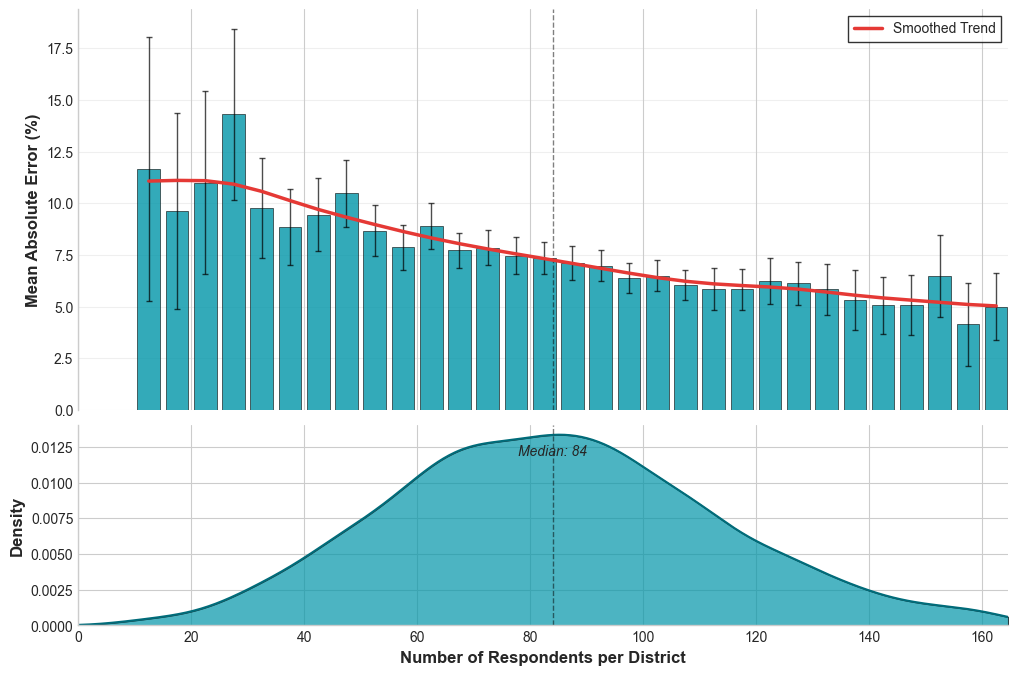


SUMMARY STATISTICS
Total districts: 2839
Median respondents: 84
Mean absolute error: 7.36%
Number of buckets (size=5): 31


In [264]:
# =============================================================================
# COMBINED FIGURE: U.S. House Error vs District Size (Density Style)
# =============================================================================
# Top panel: Bar chart with buckets of 5 respondents showing mean error
# Bottom panel: Density distribution of congressional districts by sample size
# =============================================================================

from scipy.stats import gaussian_kde

# Use districts_df from previous cell (district-level data)
# Contains: Year, State, District, n_respondents, Abs_Error

# Remove any districts with missing data
plot_data = districts_df.dropna(subset=['n_respondents', 'Abs_Error']).copy()

print(f"N districts: {len(plot_data)}")
print(f"Respondents range: {plot_data['n_respondents'].min():.0f} - {plot_data['n_respondents'].max():.0f}")

# =============================================================================
# Create buckets of 5
# =============================================================================
x = plot_data['n_respondents'].values
y = plot_data['Abs_Error'].values

# Cap at 99th percentile for cleaner visualization
x_max = np.percentile(x, 99)
bucket_size = 5
n_buckets = int(np.ceil(x_max / bucket_size))

bucket_centers = []
bucket_means = []
bucket_counts = []
bucket_sems = []

for i in range(n_buckets):
    lower = i * bucket_size
    upper = (i + 1) * bucket_size
    mask = (x >= lower) & (x < upper)
    
    if mask.sum() >= 3:  # Only include buckets with enough data
        bucket_centers.append((lower + upper) / 2)
        bucket_means.append(y[mask].mean())
        bucket_counts.append(mask.sum())
        bucket_sems.append(y[mask].std() / np.sqrt(mask.sum()))

bucket_centers = np.array(bucket_centers)
bucket_means = np.array(bucket_means)
bucket_counts = np.array(bucket_counts)
bucket_sems = np.array(bucket_sems)

# Create figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# =============================================================================
# TOP PANEL: Bar chart with buckets of 5
# =============================================================================
bar_width = bucket_size * 0.8

bars = ax1.bar(bucket_centers, bucket_means, width=bar_width, 
               color=US_HOUSE_COLOR, edgecolor='black', linewidth=0.5, alpha=0.8)

# Add error bars
ax1.errorbar(bucket_centers, bucket_means, yerr=1.96*bucket_sems, 
             fmt='none', color='black', capsize=2, linewidth=1, alpha=0.7)

# Add smoothed trend line
from scipy.ndimage import gaussian_filter1d
if len(bucket_means) > 5:
    smoothed = gaussian_filter1d(bucket_means, sigma=2)
    ax1.plot(bucket_centers, smoothed, color=DELTA_COLOR, linewidth=2.5, 
             linestyle='-', label='Smoothed Trend', zorder=10)
    ax1.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')

ax1.set_ylabel('Mean Absolute Error (%)', fontsize=12, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_ylim(0, None)

# =============================================================================
# BOTTOM PANEL: Density Distribution
# =============================================================================
x_density = np.linspace(0, x_max, 500)

try:
    kde = gaussian_kde(x[x <= x_max], bw_method='scott')
    density = kde(x_density)
    
    ax2.fill_between(x_density, density, alpha=0.7, color=US_HOUSE_COLOR, edgecolor='black', linewidth=1)
    ax2.plot(x_density, density, color='#006C7A', linewidth=1.5)
except:
    # Fallback to histogram if KDE fails
    ax2.hist(x[x <= x_max], bins=50, density=True, alpha=0.7, color=US_HOUSE_COLOR, edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Number of Respondents per District', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, None)
ax2.set_xlim(0, x_max)

# Add median line
median_n = np.median(x)
for ax in [ax1, ax2]:
    ax.axvline(median_n, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax2.text(median_n, ax2.get_ylim()[1]*0.85, f'Median: {median_n:.0f}', 
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
save_figure(fig, 'us_house_error_density_combined.png')
plt.show()

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Total districts: {len(plot_data)}")
print(f"Median respondents: {median_n:.0f}")
print(f"Mean absolute error: {y.mean():.2f}%")
print(f"Number of buckets (size={bucket_size}): {len(bucket_centers)}")


---
# Candidate Choice Accuracy by Office Grouping

Two perspectives on office-level accuracy differences:
1. Federal vs State-Level (Federal, State Executive, State Legislative)
2. Race Salience (High/Medium/Low visibility)

RMSE by Office (Unweighted - State Level):
  Attorney General: 11.21%
  Governor: 7.01%
  President: 7.40%
  Secretary of State: 9.75%
  State Representative: 9.71%
  State Senator: 11.15%
  U.S. House: 9.30%
  U.S. Senate: 9.37%
Saved: output/rmse_by_office_salience.png


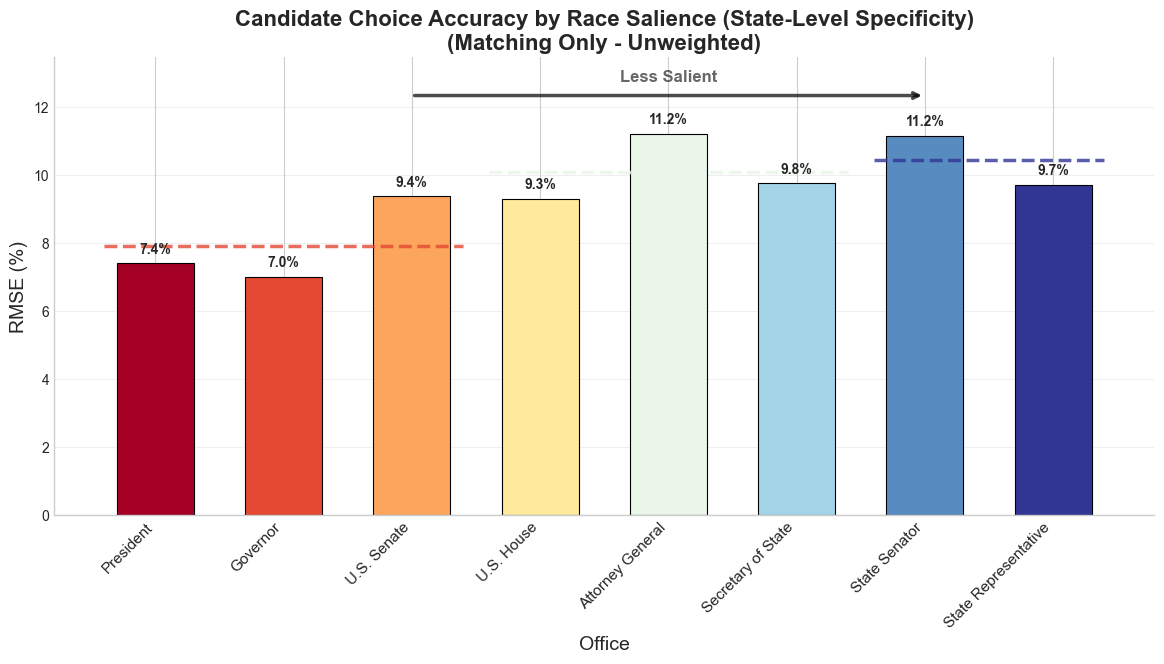


SUMMARY: RMSE by Race Salience (Unweighted - State Level)
  High (Top of Ticket): 7.9%
  Medium: 10.1%
  Low (Down-Ballot): 10.4%


In [265]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY RACE SALIENCE (UNWEIGHTED - STATE LEVEL)
# =============================================================================

# Filter for Candidate Choice, Unweighted, Validity_Scheme='All'
df_candidate = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by office
rmse_by_office = df_candidate.groupby('Variable')['Error'].apply(calculate_rmse)

print("RMSE by Office (Unweighted - State Level):")
for office, rmse in rmse_by_office.items():
    print(f"  {office}: {rmse:.2f}%")

# Define salience groupings with specific ordering
SALIENCE_GROUPS = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Specific ordering
HIGH_ORDER = ['President', 'Governor', 'U.S. Senate']
MEDIUM_ORDER = ['U.S. House', 'Attorney General', 'Secretary of State']
LOW_ORDER = ['State Senator', 'State Representative']

# Create hot to cold gradient colors
import matplotlib.colors as mcolors
cmap = plt.cm.RdYlBu
n_offices = 8
colors_gradient = [cmap(i / (n_offices - 1)) for i in range(n_offices)]

# ============================================================
# PLOT: Race Salience/Visibility (State Level)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Build office list with specific ordering
offices_by_salience = HIGH_ORDER + MEDIUM_ORDER + LOW_ORDER

x_pos = np.arange(len(offices_by_salience))
values = [rmse_by_office.get(o, 0) for o in offices_by_salience]

# Assign gradient colors with skinnier bars
bars = ax.bar(x_pos, values, width=0.6, color=colors_gradient, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add salience group averages with colors matching the bars
salience_configs = [
    ('High (Top of Ticket)', HIGH_ORDER),
    ('Medium', MEDIUM_ORDER),
    ('Low (Down-Ballot)', LOW_ORDER)
]

for salience, office_list in salience_configs:
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in office_list if o in rmse_by_office])
    indices = [i for i, o in enumerate(offices_by_salience) if o in office_list]
    if indices:
        # Get the middle color of this group for the line
        mid_idx = indices[len(indices) // 2]
        line_color = colors_gradient[mid_idx]
        
        ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                   colors=line_color, linestyles='--', linewidth=2.5, alpha=0.8)

# Add arrow indicating direction of decreasing salience - CENTERED
arrow_y = max(values) * 1.1
arrow_start = len(offices_by_salience) / 4
arrow_end = 3 * len(offices_by_salience) / 4
ax.annotate('', xy=(arrow_end, arrow_y), xytext=(arrow_start, arrow_y),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='black', alpha=0.7))
ax.text((arrow_start + arrow_end) / 2, arrow_y + max(values) * 0.03, 
        'Less Salient', ha='center', va='bottom', fontsize=12, fontweight='bold', alpha=0.7)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice Accuracy by Race Salience (State-Level Specificity)\n(Matching Only - Unweighted)', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_by_office_salience.png')
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: RMSE by Race Salience (Unweighted - State Level)")
print("="*60)
for salience, office_list in salience_configs:
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in office_list if o in rmse_by_office])
    print(f"  {salience}: {salience_rmse:.1f}%")


RMSE by Office (Unweighted - Party Level):
  Attorney General: 11.42%
  Governor: 7.01%
  President: 7.86%
  Secretary of State: 9.75%
  State Representative: 9.71%
  State Senator: 11.15%
  U.S. House: 7.27%
  U.S. Senate: 12.67%
Saved: output/rmse_by_office_salience_party.png


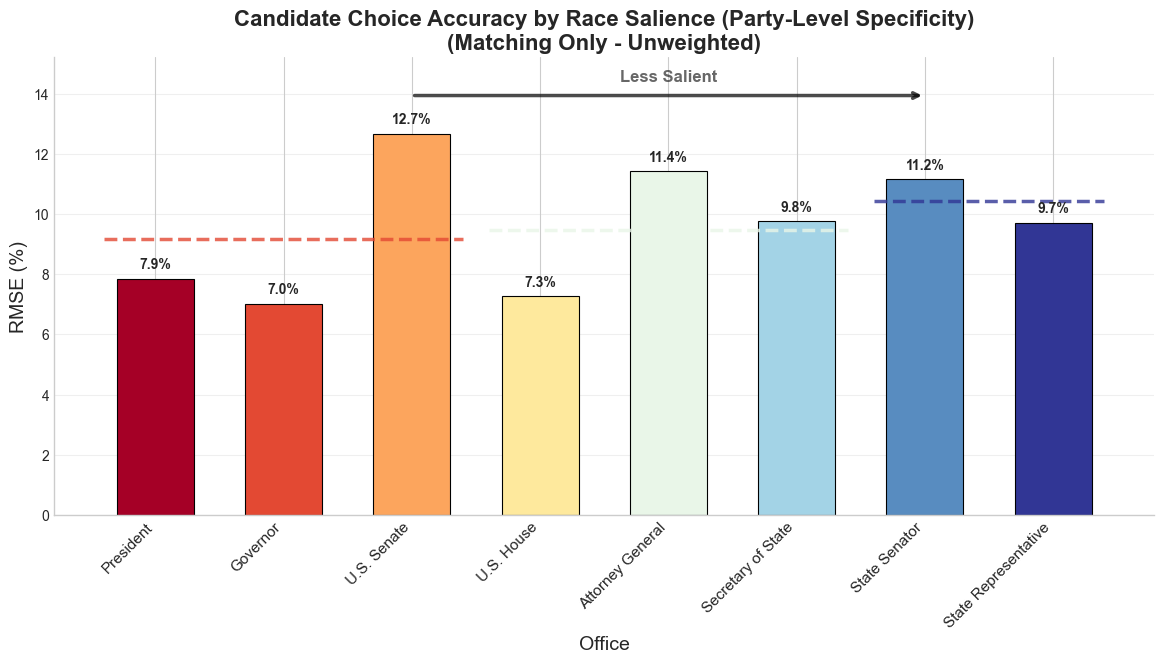


SUMMARY: RMSE by Race Salience (Unweighted - Party Level)
  High (Top of Ticket): 9.2%
  Medium: 9.5%
  Low (Down-Ballot): 10.4%


In [266]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY RACE SALIENCE (UNWEIGHTED - PARTY LEVEL)
# =============================================================================

# Filter for Party specificity, Unweighted, Validity_Scheme='All'
df_candidate_party = metrics_base[
    (metrics_base['Class'] == 'Candidate Choice') &
    (metrics_base['Weighting_Method'] == 'CES-Unweighted') &
    (metrics_base['Validity_Scheme'] == 'All') &
    (metrics_base['Specificity'] == 'Party')
].copy()

# Calculate RMSE by office
rmse_by_office_party = df_candidate_party.groupby('Variable')['Error'].apply(calculate_rmse)

print("RMSE by Office (Unweighted - Party Level):")
for office, rmse in rmse_by_office_party.items():
    print(f"  {office}: {rmse:.2f}%")

# Define salience groupings with specific ordering
SALIENCE_GROUPS_PARTY = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Specific ordering
HIGH_ORDER_P = ['President', 'Governor', 'U.S. Senate']
MEDIUM_ORDER_P = ['U.S. House', 'Attorney General', 'Secretary of State']
LOW_ORDER_P = ['State Senator', 'State Representative']

# Create hot to cold gradient colors
import matplotlib.colors as mcolors
cmap_p = plt.cm.RdYlBu
n_offices_p = 8
colors_gradient_p = [cmap_p(i / (n_offices_p - 1)) for i in range(n_offices_p)]

# ============================================================
# PLOT: Race Salience/Visibility (Party Level)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Build office list with specific ordering
offices_by_salience_p = HIGH_ORDER_P + MEDIUM_ORDER_P + LOW_ORDER_P

x_pos_p = np.arange(len(offices_by_salience_p))
values_p = [rmse_by_office_party.get(o, 0) for o in offices_by_salience_p]

# Assign gradient colors with skinnier bars
bars_p = ax.bar(x_pos_p, values_p, width=0.6, color=colors_gradient_p, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars_p, values_p):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add salience group averages with colors matching the bars
salience_configs_p = [
    ('High (Top of Ticket)', HIGH_ORDER_P),
    ('Medium', MEDIUM_ORDER_P),
    ('Low (Down-Ballot)', LOW_ORDER_P)
]

for salience, office_list in salience_configs_p:
    salience_rmse = np.mean([rmse_by_office_party.get(o, 0) for o in office_list if o in rmse_by_office_party])
    indices = [i for i, o in enumerate(offices_by_salience_p) if o in office_list]
    if indices:
        # Get the middle color of this group for the line
        mid_idx = indices[len(indices) // 2]
        line_color = colors_gradient_p[mid_idx]
        
        ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                   colors=line_color, linestyles='--', linewidth=2.5, alpha=0.8)

# Add arrow indicating direction of decreasing salience - CENTERED
arrow_y_p = max(values_p) * 1.1
arrow_start_p = len(offices_by_salience_p) / 4
arrow_end_p = 3 * len(offices_by_salience_p) / 4
ax.annotate('', xy=(arrow_end_p, arrow_y_p), xytext=(arrow_start_p, arrow_y_p),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='black', alpha=0.7))
ax.text((arrow_start_p + arrow_end_p) / 2, arrow_y_p + max(values_p) * 0.03, 
        'Less Salient', ha='center', va='bottom', fontsize=12, fontweight='bold', alpha=0.7)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice Accuracy by Race Salience (Party-Level Specificity)\n(Matching Only - Unweighted)', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos_p)
ax.set_xticklabels(offices_by_salience_p, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values_p) * 1.2)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_by_office_salience_party.png')
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: RMSE by Race Salience (Unweighted - Party Level)")
print("="*60)
for salience, office_list in salience_configs_p:
    salience_offices = [o for o in office_list if o in rmse_by_office_party]
    if salience_offices:
        salience_rmse = np.mean([rmse_by_office_party.get(o, 0) for o in salience_offices])
        print(f"  {salience}: {salience_rmse:.1f}%")


---
# Race Salience: Party-Level Specificity

Same salience analysis but using Party-level specificity for all offices (includes State Senator and State Representative).

---
# Party vs Candidate Specificity Comparison

For offices that have both Party and Candidate level data, compare RMSE using only overlapping years.

RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY
(Using only years where BOTH are available)

Office               Years        Party      Candidate    Diff      
----------------------------------------------------------------------
U.S. House           2008-2022       4.6%         9.5%      +4.9%
Governor             2010-2022       4.3%         4.3%      +0.0%
President            2012-2020       2.4%         2.4%      +0.0%
Secretary of State   2018-2022       5.2%         5.2%      +0.0%
Attorney General     2018-2022       7.1%         6.0%      -1.1%
U.S. Senate          2008-2022      10.7%         6.5%      -4.1%
Saved: output/rmse_party_vs_candidate_comparison.png


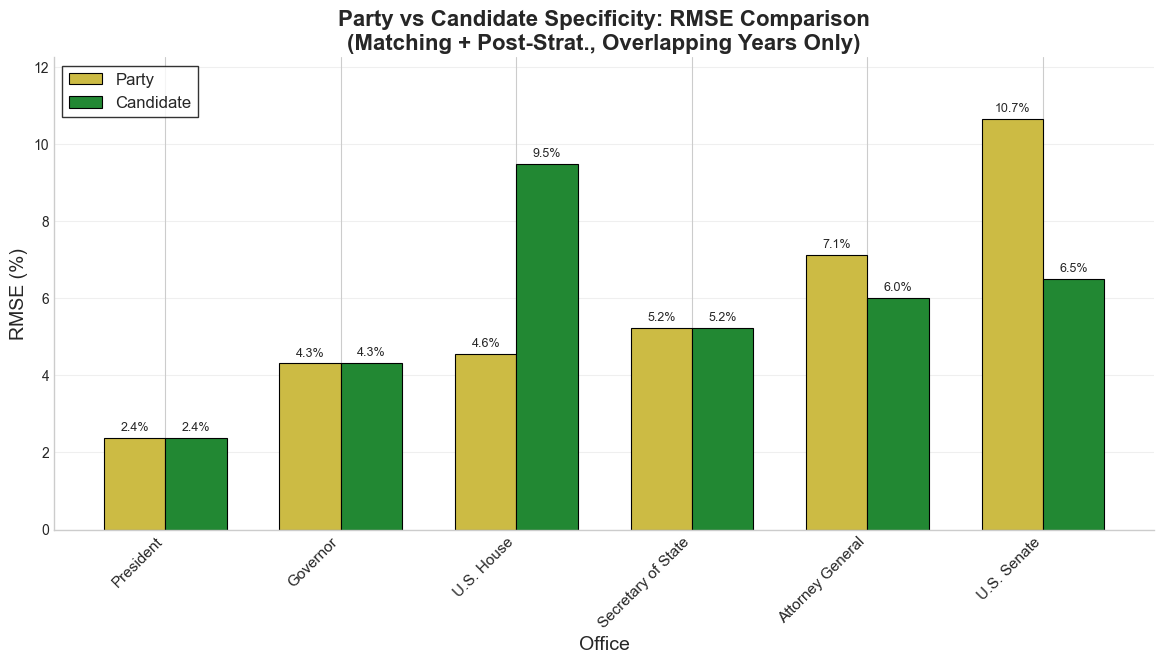


Saved: output/rmse_party_vs_candidate_comparison.tex


In [267]:
# =============================================================================
# PARTY VS CANDIDATE SPECIFICITY COMPARISON
# =============================================================================

df_cc = metrics_base[
    (metrics_base['Class'] == 'Candidate Choice') &
    (metrics_base['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base['Validity_Scheme'] == 'All')
].copy()

both_offices = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 'Attorney General', 'Secretary of State']

print("="*80)
print("RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY")
print("(Using only years where BOTH are available)")
print("="*80)

results = []
for office in both_offices:
    party_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Party')]['Year'].unique())
    cand_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Candidate')]['Year'].unique())
    overlap_years = party_years & cand_years
    
    if not overlap_years:
        continue
    
    df_office = df_cc[(df_cc['Variable'] == office) & (df_cc['Year'].isin(overlap_years))]
    rmse_party = calculate_rmse(df_office[df_office['Specificity'] == 'Party']['Error'])
    rmse_cand = calculate_rmse(df_office[df_office['Specificity'] == 'Candidate']['Error'])
    
    results.append({
        'Office': office,
        'Years': f"{min(overlap_years)}-{max(overlap_years)}",
        'RMSE_Party': rmse_party,
        'RMSE_Candidate': rmse_cand,
        'Difference': rmse_cand - rmse_party
    })

results_df = pd.DataFrame(results).sort_values('Difference', ascending=False)

print(f"\n{'Office':<20} {'Years':<12} {'Party':<10} {'Candidate':<12} {'Diff':<10}")
print("-"*70)
for _, row in results_df.iterrows():
    print(f"{row['Office']:<20} {row['Years']:<12} {row['RMSE_Party']:>6.1f}%    {row['RMSE_Candidate']:>8.1f}%    {row['Difference']:>+6.1f}%")

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 7))

offices_sorted = results_df.sort_values('RMSE_Party')['Office'].tolist()
x = np.arange(len(offices_sorted))
width = 0.35

party_vals = [results_df[results_df['Office'] == o]['RMSE_Party'].values[0] for o in offices_sorted]
cand_vals = [results_df[results_df['Office'] == o]['RMSE_Candidate'].values[0] for o in offices_sorted]

bars1 = ax.bar(x - width/2, party_vals, width, label='Party', color=SPECIFICITY_COLORS['Party'], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, cand_vals, width, label='Candidate', color=SPECIFICITY_COLORS['Candidate'], edgecolor='black', linewidth=0.8)

for bar in bars1:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Party vs Candidate Specificity: RMSE Comparison\n(Matching + Post-Strat., Overlapping Years Only)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(offices_sorted, rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=False, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(max(party_vals), max(cand_vals)) * 1.15)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_party_vs_candidate_comparison.png')
plt.show()

save_latex_table(df_to_latex_table(
    results_df,
    'Party vs Candidate RMSE Comparison',
    'rmse_party_vs_candidate_comparison',
    'RMSE comparison between party-level and candidate-level specificity across offices.'
), 'rmse_party_vs_candidate_comparison.tex')
print("\nSaved: output/rmse_party_vs_candidate_comparison.tex")

Saved: output/rmse_by_competitiveness_histogram.png


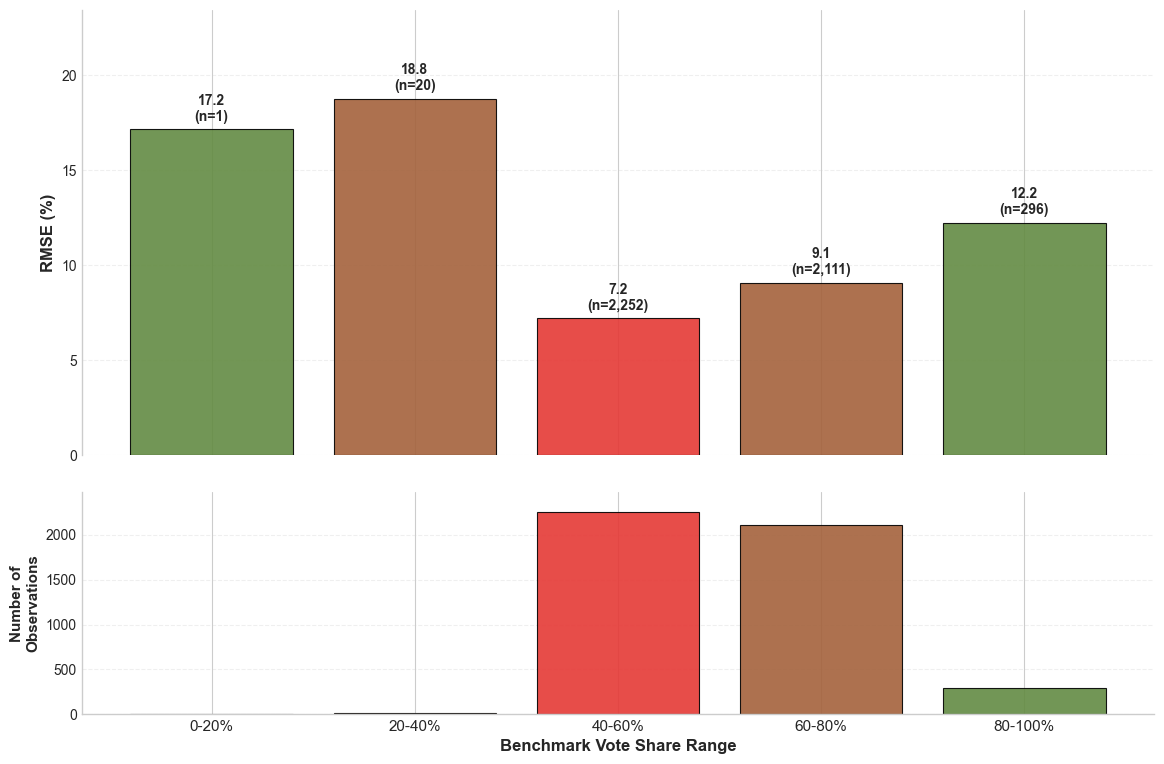


RMSE BY COMPETITIVENESS
Band         RMSE                N
-----------------------------------
0-20%        17.16               1
20-40%       18.75              20
40-60%       7.21            2,252
60-80%       9.08            2,111
80-100%      12.23             296


In [268]:
# =============================================================================
# RMSE BY RACE COMPETITIVENESS
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness['Abs_Error'] = data_competitiveness['Error'].abs()

# Define bands
bands = [
    (0, 20, '0-20%'),
    (20, 40, '20-40%'),
    (40, 60, '40-60%'),
    (60, 80, '60-80%'),
    (80, 100, '80-100%'),
]

# Calculate RMSE and counts for each band
band_labels = []
rmse_values = []
sample_sizes = []

for start, end, label in bands:
    band_data = data_competitiveness[(data_competitiveness['Benchmark'] >= start) & 
                                      (data_competitiveness['Benchmark'] < end)]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_labels.append(label)
        rmse_values.append(rmse)
        sample_sizes.append(len(band_data))

# Single color - warm brown/tan
BAR_COLOR = '#f2c45f'  # Yellow

# Single panel figure
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(band_labels))
width = 0.5  # Skinnier bars

bars = ax.bar(x_pos, rmse_values, width=width, color=BAR_COLOR, 
              edgecolor='black', linewidth=0.8)

# Add value labels on bars with n=
for i, (bar, rmse, n) in enumerate(zip(bars, rmse_values, sample_sizes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{rmse:.1f}\n(n={n:,})',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Benchmark Vote Share Range', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(band_labels, fontsize=11)
ax.set_ylim(0, max(rmse_values) * 1.3)
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig, 'rmse_by_competitiveness_histogram.png')
plt.show()

print("\n" + "="*35)
print("RMSE BY COMPETITIVENESS")
print("="*35)
print(f"{'Band':<12} {'RMSE':<10} {'N':>10}")
print("-"*35)
for label, rmse, n in zip(band_labels, rmse_values, sample_sizes):
    print(f"{label:<12} {rmse:<10.2f} {n:>10,}")


<Axes: title={'center': 'Error vs. Race Competitiveness (Matching + Post-Stratification Estimates)'}, ylabel='RMSE (%)'>

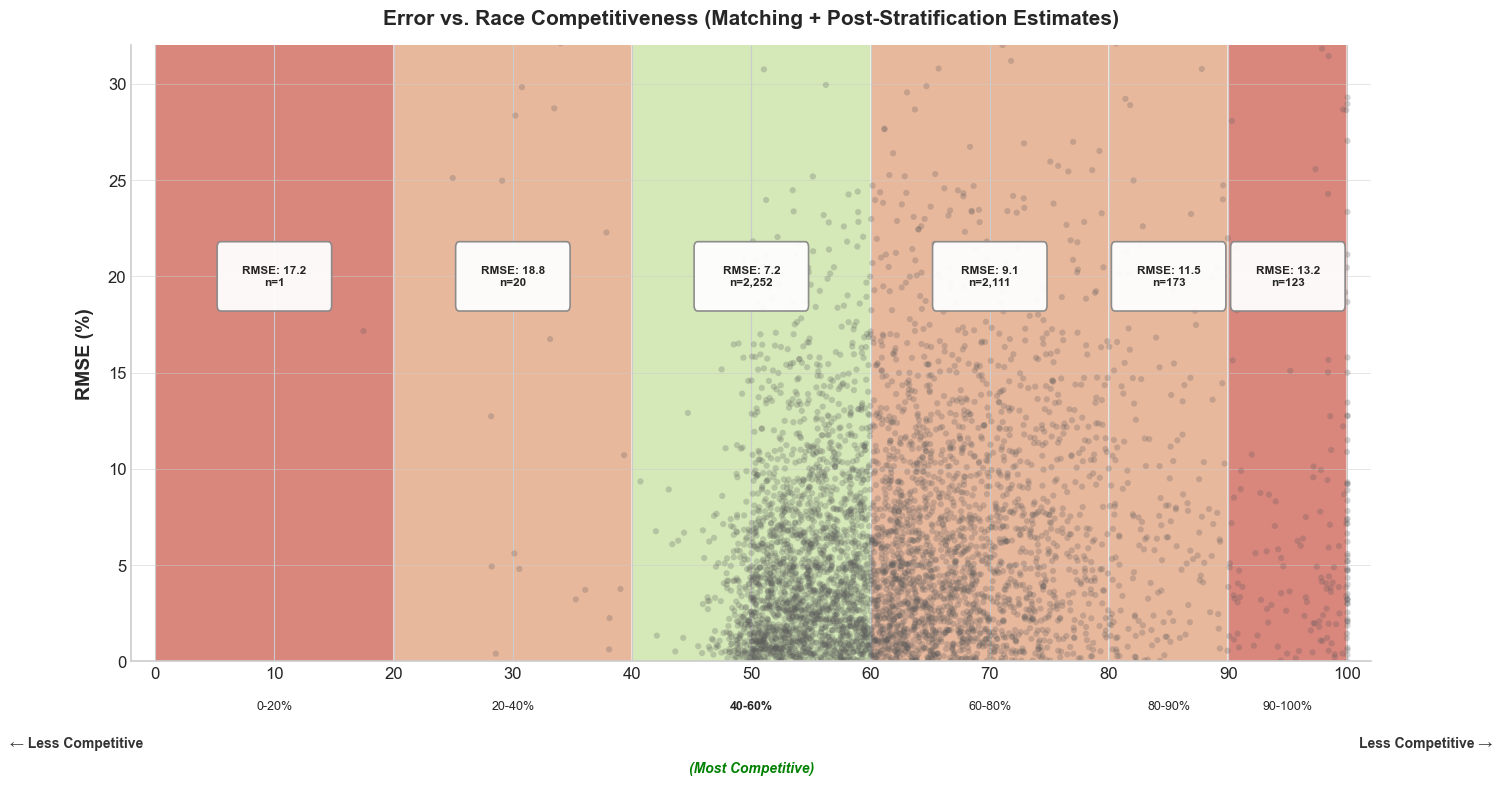

In [269]:
# =============================================================================
# ERROR VS RACE COMPETITIVENESS (SCATTER PLOT WITH COLORED BANDS)
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness_scatter = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness_scatter['Abs_Error'] = data_competitiveness_scatter['Error'].abs()

# Define bands with darker colors (symmetric)
bands_scatter = [
    (0, 20, '0-20%', '#d9867d'),      # Darker red-pink
    (20, 40, '20-40%', '#e8b89d'),    # Darker tan
    (40, 60, '40-60%', '#d4e8b8'),    # Darker soft green (most competitive)
    (60, 80, '60-80%', '#e8b89d'),    # Darker tan
    (80, 90, '80-90%', '#e8b89d'),    # Darker tan
    (90, 100, '90-100%', '#d9867d'),  # Darker red-pink
]

# Calculate RMSE for each band
band_stats_scatter = []
for start, end, label, color in bands_scatter:
    band_data = data_competitiveness_scatter[
        (data_competitiveness_scatter['Benchmark'] >= start) & 
        (data_competitiveness_scatter['Benchmark'] < end)
    ]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_stats_scatter.append({
            'label': label,
            'start': start,
            'end': end,
            'rmse': rmse,
            'n': len(band_data),
            'color': color
        })

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Draw background bands
from matplotlib.patches import Rectangle, FancyBboxPatch
for stat in band_stats_scatter:
    rect = Rectangle((stat['start'], 0), stat['end'] - stat['start'], 32, 
                      facecolor=stat['color'], edgecolor='none', linewidth=0, zorder=0)
    ax.add_patch(rect)

# Add subtle dividing lines between bands
for start, end, label, color in bands_scatter:
    ax.axvline(x=end, color='white', linewidth=1.5, linestyle='-', alpha=0.6, zorder=0)

# Scatter plot with smaller, less opaque dots
ax.scatter(data_competitiveness_scatter['Benchmark'], data_competitiveness_scatter['Abs_Error'], 
          s=20, alpha=0.25, color='#5a5a5a', edgecolors='none', zorder=2)

# Add RMSE boxes
for stat in band_stats_scatter:
    if stat['n'] > 0:
        x_pos = (stat['start'] + stat['end']) / 2
        y_pos = 20  # Lower position, closer to center
        
        rmse_text = f"RMSE: {stat['rmse']:.1f}\nn={stat['n']:,}"
        
        box = FancyBboxPatch((x_pos - 4.5, y_pos - 1.5), 9, 3,
                            boxstyle="round,pad=0.3",
                            facecolor='white', 
                            edgecolor='#888888', 
                            linewidth=1.2,
                            alpha=0.95,
                            zorder=10)
        ax.add_patch(box)
        
        ax.text(x_pos, y_pos, rmse_text, 
               ha='center', va='center',
               fontsize=8.5, fontweight='bold', zorder=11)

# Set labels and title
ax.set_xlabel('Benchmark Vote Share (%)', fontsize=13, fontweight='bold', labelpad=25)
ax.set_ylabel('Absolute Error (%)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Error vs. Race Competitiveness (Matching + Post-Stratification Estimates)', 
            fontsize=15, fontweight='bold', pad=15)

# Set limits
ax.set_xlim(-2, 102)
ax.set_ylim(0, 32)

ax.set_xticks(np.arange(0, 101, 10))
ax.set_xticklabels(np.arange(0, 101, 10), fontsize=10)
ax.set_yticks(np.arange(0, 31, 5))
ax.set_yticklabels(np.arange(0, 31, 5), fontsize=10)

# Add band labels at bottom
label_positions = [(10, -2.5), (30, -2.5), (50, -2.5), (70, -2.5), (85, -2.5), (95, -2.5)]
label_texts = ['0-20%', '20-40%', '40-60%', '60-80%', '80-90%', '90-100%']

for pos, label in zip(label_positions, label_texts):
    fontweight = 'bold' if label == '40-60%' else 'normal'
    ax.text(pos[0], pos[1], label, ha='center', fontsize=9, fontweight=fontweight)

# Add competitiveness text
ax.text(-1, -4.5, '← Less Competitive', ha='right', fontsize=10, fontweight='bold', color='#333333')
ax.text(101, -4.5, 'Less Competitive →', ha='left', fontsize=10, fontweight='bold', color='#333333')
ax.text(50, -5.8, '(Most Competitive)', ha='center', fontsize=10, 
       color='green', fontweight='bold', style='italic')

# Draw competitiveness arrows
arrow_y = -4
ax.annotate('', xy=(40, arrow_y), xytext=(0, arrow_y),
            arrowprops=dict(arrowstyle='<-', lw=2, color='#666666', alpha=0.7))
ax.annotate('', xy=(100, arrow_y), xytext=(60, arrow_y),
            arrowprops=dict(arrowstyle='->', lw=2, color='#666666', alpha=0.7))

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_facecolor('white')

style_axis(ax)


/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/3598840660.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_24098/2726076979.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


Saved: output/error_distribution_by_class_sidebyside.png


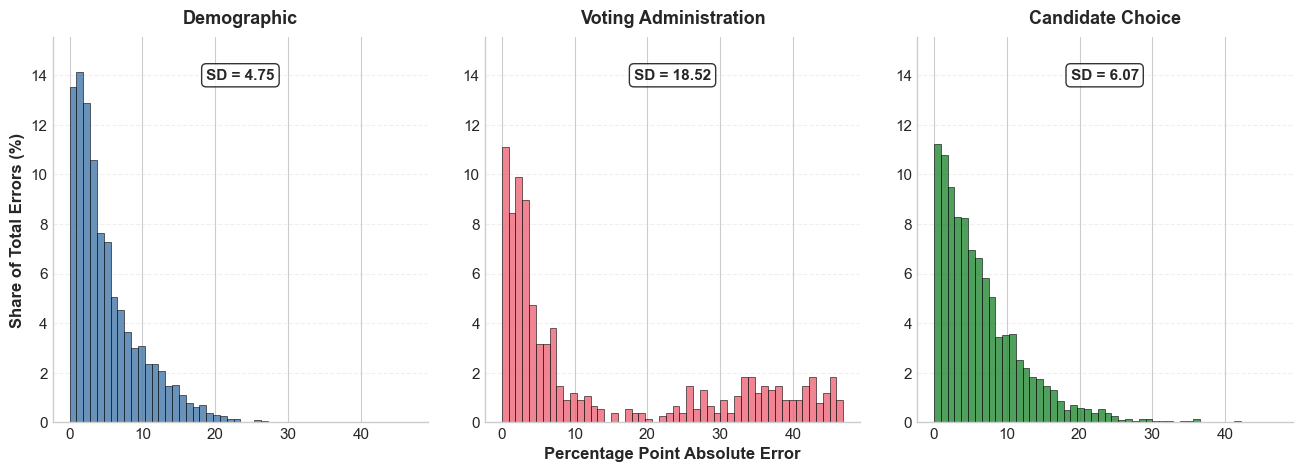


ERROR DISTRIBUTION BY CLASS (SECONDARY VARIABLES ONLY)
Demographic: 9 variables, 2652 observations, SD = 4.75
Voting Administration: 2 variables, 758 observations, SD = 18.52
Candidate Choice: 8 variables, 4381 observations, SD = 6.07


In [270]:
# =============================================================================
# ERROR DISTRIBUTION BY CLASS - SIDE BY SIDE (SECONDARY VARIABLES ONLY)
# =============================================================================

# Filter for Secondary variables only (Matching + Post-Stratification, All validity)
df_hist_classes = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable_Type'] == 'Secondary')
].copy()

# Use global CLASS_COLORS
class_colors_dist = CLASS_COLORS
class_order_dist = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Create figure with 3 subplots - larger size, less horizontal padding
fig, axes = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'wspace': 0.15})

# Get overall min and max for consistent axis limits
all_errors = df_hist_classes['Error'].abs()
x_max = all_errors.quantile(0.99)  # 99th percentile for better visibility
y_max = 0

# First pass: find max y value (in percent) and calculate SDs
class_sds = {}
for class_name in class_order_dist:
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    if len(class_data) > 0:
        weights = np.ones_like(class_data) / len(class_data) * 100  # Convert to percent
        counts, _ = np.histogram(class_data, bins=50, range=(0, x_max), weights=weights)
        y_max = max(y_max, counts.max())
        class_sds[class_name] = class_data.std()

# Plot each class
for idx, class_name in enumerate(class_order_dist):
    ax = axes[idx]
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    
    if len(class_data) > 0:
        # Use weights to convert to percentages
        weights = np.ones_like(class_data) / len(class_data) * 100
        ax.hist(class_data, bins=50, range=(0, x_max), weights=weights,
               color=class_colors_dist[class_name], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Only middle plot gets x-axis label
    if idx == 1:
        ax.set_xlabel('Percentage Point Absolute Error', fontsize=12, fontweight='bold')
    else:
        ax.set_xlabel('')
    
    # Only first plot gets y-axis label
    if idx == 0:
        ax.set_ylabel('Share of Total Errors (%)', fontsize=12, fontweight='bold')
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=True)  # Keep tick labels for reference
    
    # Title
    ax.set_title(class_name, fontsize=13, fontweight='bold', pad=10)
    
    # SD in a box centered below title
    ax.text(0.5, 0.92, f'SD = {class_sds[class_name]:.2f}', 
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            verticalalignment='top', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black', linewidth=1))
    
    ax.set_ylim(0, y_max * 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Style spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
save_figure(fig, 'error_distribution_by_class_sidebyside.png')
plt.show()

print("\n" + "="*70)
print("ERROR DISTRIBUTION BY CLASS (SECONDARY VARIABLES ONLY)")
print("="*70)
for class_name in class_order_dist:
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]
    n_vars = class_data['Variable'].nunique()
    n_obs = len(class_data)
    abs_errors = class_data['Error'].abs()
    std_dev = abs_errors.std()
    print(f"{class_name}: {n_vars} variables, {n_obs} observations, SD = {std_dev:.2f}")

Saved: output/rmse_by_weighting_method_class.png


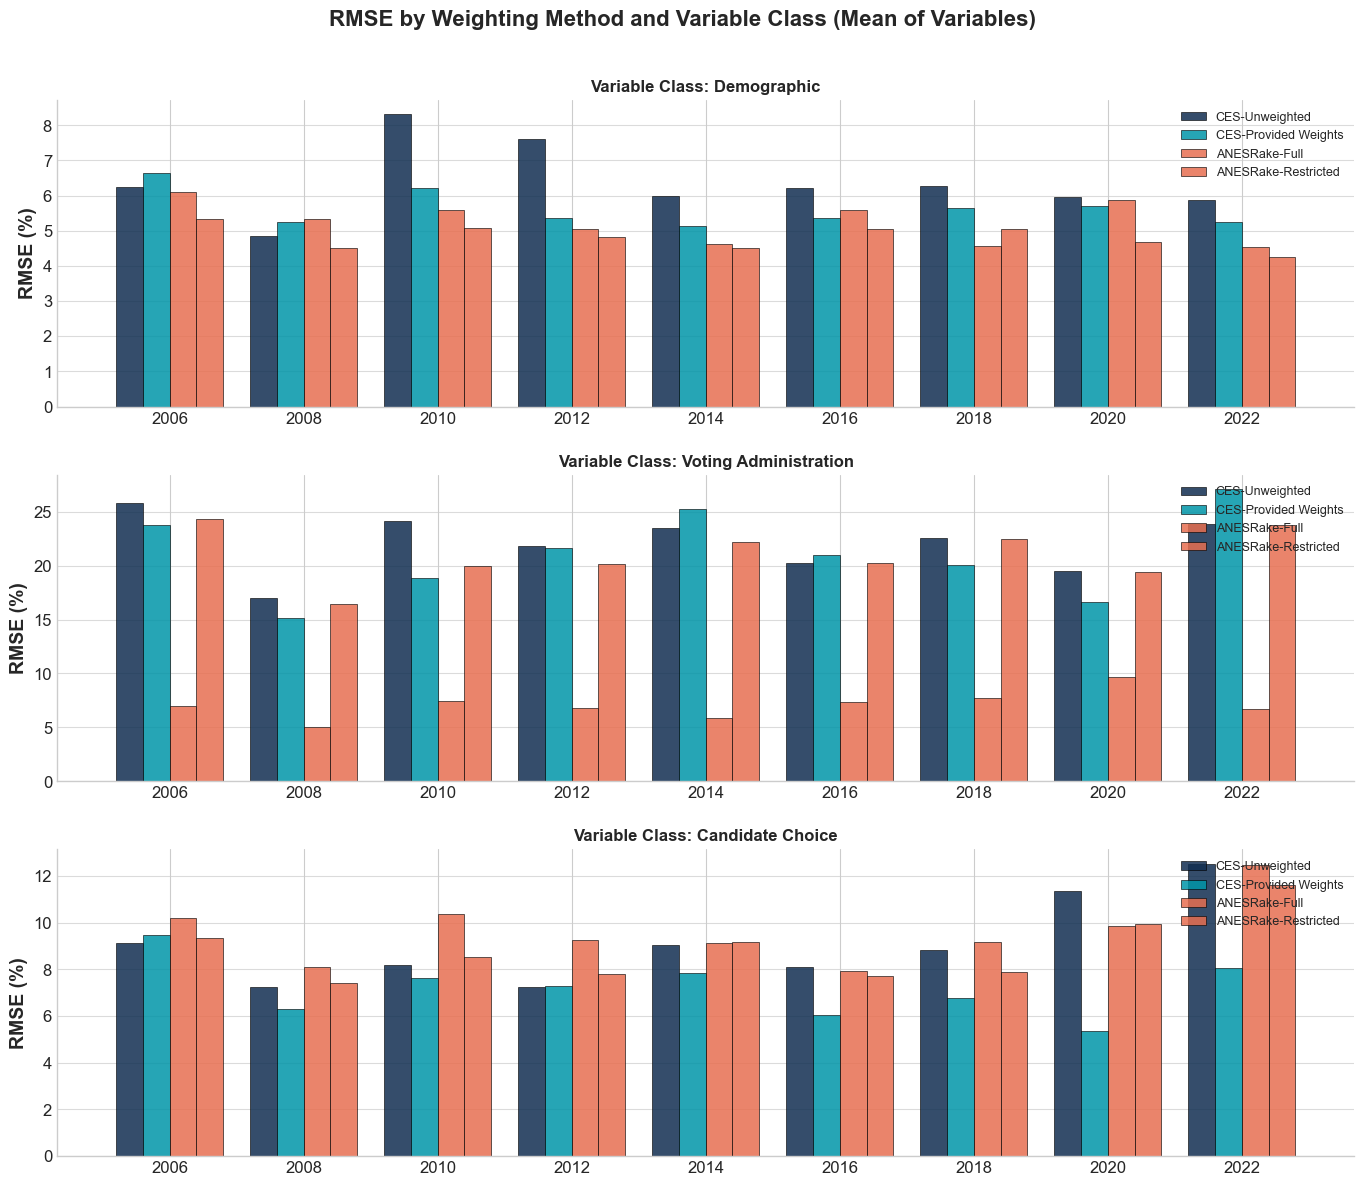

In [271]:
# =============================================================================
# RMSE BY WEIGHTING METHOD (BY VARIABLE CLASS) - MEAN OF MEANS
# =============================================================================

# Mean-of-means approach: calculate variable-level RMSE, then average

class_order_weight = ['Demographic', 'Voting Administration', 'Candidate Choice']
weighting_order = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']
subset_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('RMSE by Weighting Method and Variable Class (Mean of Variables)', 
             fontsize=16, fontweight='bold', y=0.995)

for plot_idx, class_name in enumerate(class_order_weight):
    ax = axes[plot_idx]
    
    class_data = subset_all[subset_all['Class'] == class_name]
    
    # Calculate variable-level RMSE first
    var_rmse = class_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.2
    
    for i, weighting in enumerate(weighting_order):
        weighting_data = rmse_data[rmse_data['Weighting_Method'] == weighting]
        if len(weighting_data) > 0:
            rmse_values = []
            for year in years:
                year_data = weighting_data[weighting_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 1.5) * width, rmse_values, width, 
                   label=weighting, color=WEIGHTING_COLORS[weighting], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Variable Class: {class_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_weighting_method_class.png')

Saved: output/rmse_reduction_by_office.png


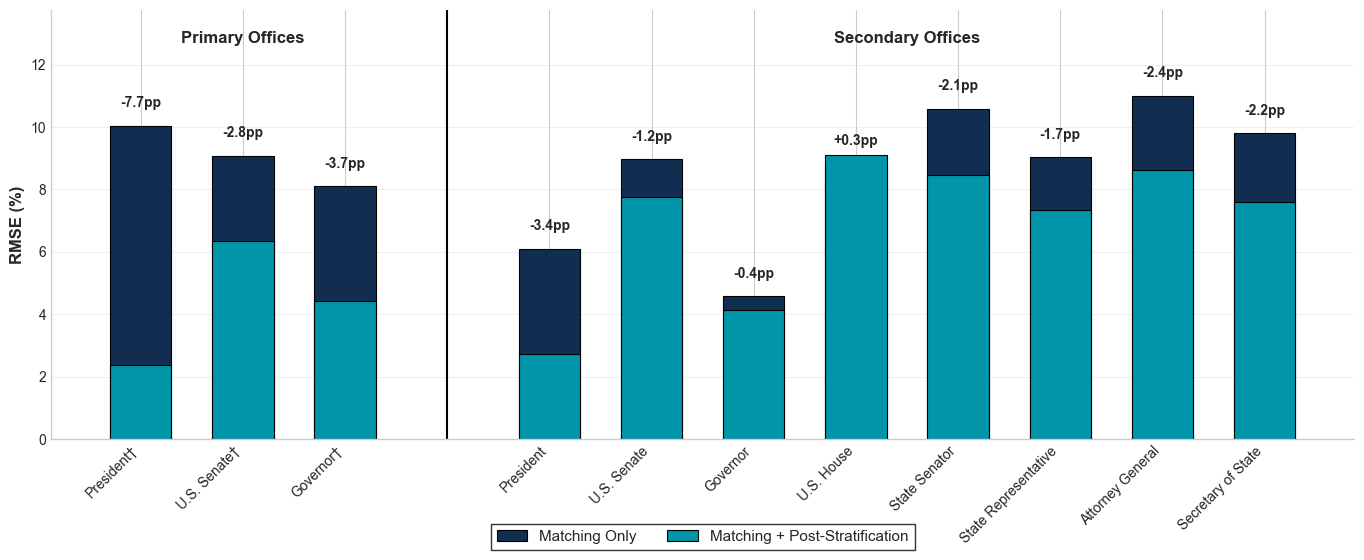

In [272]:
# =============================================================================
# RMSE REDUCTION BY OFFICE (CANDIDATE CHOICE) - SINGLE PLOT WITH PRIMARY/SECONDARY SECTIONS
# =============================================================================

# Mean-of-means: average RMSE per variable across years
# Shows how post-stratification "draws down" error for each office

cc_data = most_specific[most_specific['Class'] == 'Candidate Choice'].copy()

# Calculate RMSE per year per variable first
year_var_rmse = cc_data.groupby(['Year', 'Variable', 'Weighting_Method', 'Variable_Type']).apply(
    lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
    include_groups=False
).reset_index(name='RMSE')

# Average across years (mean-of-means)
var_rmse = year_var_rmse.groupby(['Variable', 'Weighting_Method', 'Variable_Type'])['RMSE'].mean().reset_index()

offices = ['President', 'U.S. Senate', 'Governor', 'U.S. House', 
          'State Senator', 'State Representative', 'Attorney General', 'Secretary of State']

# Separate Primary and Secondary
primary_entries = []
secondary_entries = []

for office in offices:
    office_data = var_rmse[var_rmse['Variable'] == office]
    var_types = sorted(office_data['Variable_Type'].unique())
    
    for var_type in var_types:
        var_data = office_data[office_data['Variable_Type'] == var_type]
        
        unweighted = var_data[var_data['Weighting_Method'] == 'CES-Unweighted']['RMSE'].values
        weighted = var_data[var_data['Weighting_Method'] == 'CES-Provided Weights']['RMSE'].values
        
        if len(unweighted) > 0 and len(weighted) > 0:
            improvement = unweighted[0] - weighted[0]
            
            entry = {
                'office': office,
                'var_type': var_type,
                'unweighted': unweighted[0],
                'weighted': weighted[0],
                'improvement': improvement
            }
            
            if var_type == 'Primary':
                primary_entries.append(entry)
            else:
                secondary_entries.append(entry)

# Use standardized WEIGHTING_COLORS
unweighted_color = WEIGHTING_COLORS['CES-Unweighted']  # Navy
weighted_color = WEIGHTING_COLORS['CES-Provided Weights']  # Teal

# Calculate y-axis max
all_entries = primary_entries + secondary_entries
max_height = max(e['unweighted'] for e in all_entries) if all_entries else 10
y_max = max_height * 1.25

# Create single figure
fig, ax = plt.subplots(figsize=(14, 6))

width = 0.6
label_offset = 0.5
gap = 1.0  # Gap between primary and secondary sections

# Build x positions: primary entries, then gap, then secondary entries
n_primary = len(primary_entries)
n_secondary = len(secondary_entries)

# Primary x positions: 0, 1, 2, ...
primary_x = np.arange(n_primary)
# Secondary x positions: start after primary + gap
secondary_x = np.arange(n_secondary) + n_primary + gap

all_x = list(primary_x) + list(secondary_x)
all_entries_ordered = primary_entries + secondary_entries

# Plot bars
for idx, (x_pos, entry) in enumerate(zip(all_x, all_entries_ordered)):
    # Unweighted bar (base)
    ax.bar(x_pos, entry['unweighted'], width, 
           label='Matching Only' if idx == 0 else '', 
           color=unweighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Weighted bar (overlay)
    ax.bar(x_pos, entry['weighted'], width, 
           label='Matching + Post-Stratification' if idx == 0 else '', 
           color=weighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Improvement label
    improvement_text = f"-{entry['improvement']:.1f}pp" if entry['improvement'] > 0 else f"+{abs(entry['improvement']):.1f}pp"
    ax.text(x_pos, entry['unweighted'] + label_offset, improvement_text,
           ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add separator line between primary and secondary
separator_x = n_primary - 0.5 + gap / 2
ax.axvline(x=separator_x, color='black', linewidth=1.5, linestyle='-', zorder=1)

# Add section labels at top
primary_center = (primary_x[0] + primary_x[-1]) / 2 if n_primary > 0 else 0
secondary_center = (secondary_x[0] + secondary_x[-1]) / 2 if n_secondary > 0 else n_primary + gap

ax.text(primary_center, y_max * 0.95, 'Primary Offices', 
        ha='center', va='top', fontsize=12, fontweight='bold')
ax.text(secondary_center, y_max * 0.95, 'Secondary Offices', 
        ha='center', va='top', fontsize=12, fontweight='bold')

# Create x-axis labels with cross for primary
x_labels = []
for entry in primary_entries:
    x_labels.append(f"{entry['office']}†")  # Cross symbol for primary
for entry in secondary_entries:
    x_labels.append(entry['office'])

ax.set_xticks(all_x)
ax.set_xticklabels(x_labels, fontsize=10, rotation=45, ha='right')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', alpha=0.3, zorder=0)
ax.set_axisbelow(True)

ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax.set_ylim(0, y_max)
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

# Legend at bottom
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.18), 
          ncol=2, fontsize=11, frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'rmse_reduction_by_office.png')
plt.show()


Variables present in all years: ['Age Group', 'Education', 'Employment Status', 'Family Income', 'Governor', 'Sex', 'State Representative', 'State Senator', 'U.S. House', 'U.S. Senate', 'Union Membership', 'Veteran Status', 'Voting Method', 'Voting Turnout']
Consistently Secondary: ['Attorney General', 'Employment Status', 'Family Income', 'Hispanic Origin', 'Residence Duration', 'Secretary of State', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']
Saved: output/rmse_by_year_weighting_comparison.png


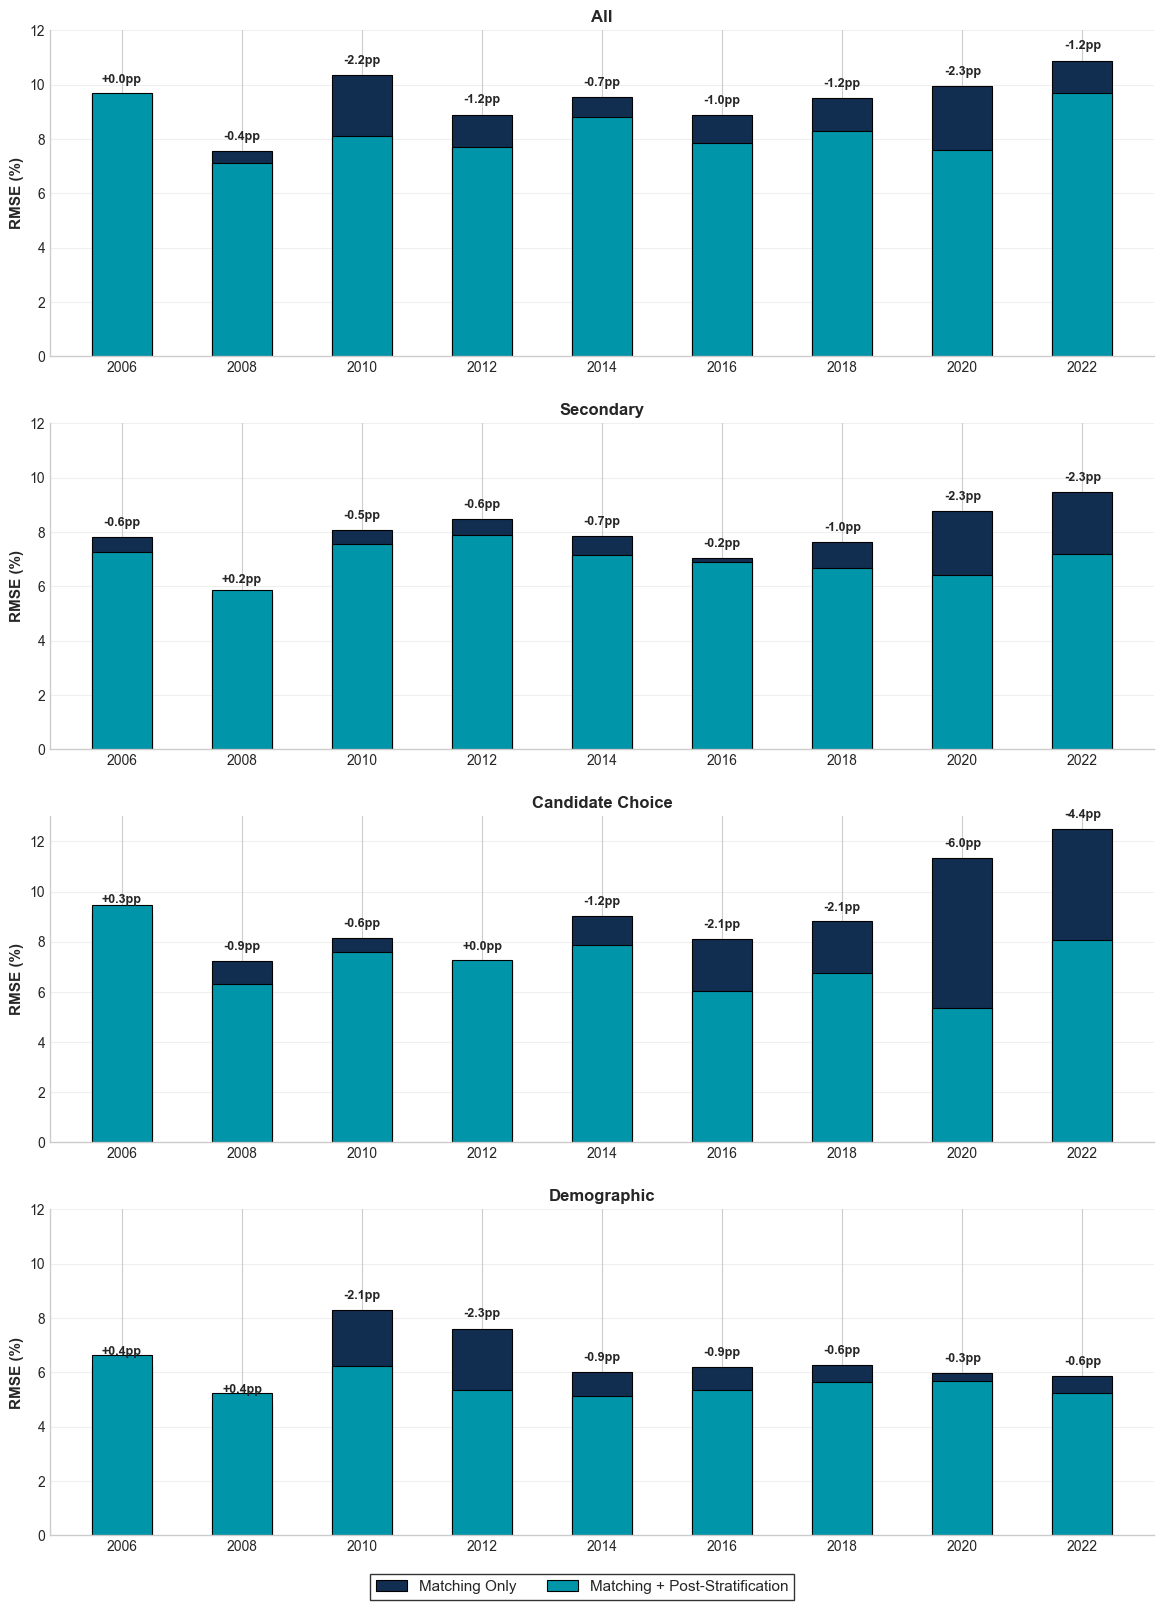

In [273]:
# =============================================================================
# RMSE BY YEAR (WEIGHTING COMPARISON) - 4 SUBPLOTS WITH INLAID DESIGN
# =============================================================================

df_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

# Identify variables present in ALL years
all_years = set(df_all['Year'].unique())
var_years = df_all.groupby('Variable')['Year'].apply(set).to_dict()
vars_in_all_years = [var for var, years in var_years.items() if years == all_years]

print(f"Variables present in all years: {vars_in_all_years}")

# Identify consistently secondary variables
var_types_by_year = df_all.groupby(['Variable', 'Year'])['Variable_Type'].first().reset_index()
var_consistency_secondary = var_types_by_year.groupby('Variable')['Variable_Type'].apply(
    lambda x: (x.nunique() == 1) and (x.iloc[0] == 'Secondary')
).to_dict()
consistent_secondary = [var for var, is_consistent in var_consistency_secondary.items() if is_consistent]

print(f"Consistently Secondary: {consistent_secondary}")

# Shortened titles
variants = [
    ('All', lambda x: x[x['Variable'].isin(vars_in_all_years)]),
    ('Secondary', lambda x: x[x['Variable'].isin(consistent_secondary)]),
    ('Candidate Choice', lambda x: x[x['Class'] == 'Candidate Choice']),
    ('Demographic', lambda x: x[x['Class'] == 'Demographic'])
]

# Use standardized WEIGHTING_COLORS
unweighted_color = WEIGHTING_COLORS['CES-Unweighted']  # Navy
weighted_color = WEIGHTING_COLORS['CES-Provided Weights']  # Teal

# First pass: compute all RMSE data
all_plot_data = []

for plot_idx, (title, filter_func) in enumerate(variants):
    filtered_data = filter_func(df_all)
    
    if len(filtered_data) == 0:
        all_plot_data.append(None)
        continue
    
    # Calculate variable-level RMSE first
    var_rmse = filtered_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    
    # Get unweighted and weighted values
    unweighted_vals = []
    weighted_vals = []
    improvements = []
    
    for year in years:
        unwtd = rmse_data[(rmse_data['Year'] == year) & 
                         (rmse_data['Weighting_Method'] == 'CES-Unweighted')]['RMSE'].values
        wtd = rmse_data[(rmse_data['Year'] == year) & 
                       (rmse_data['Weighting_Method'] == 'CES-Provided Weights')]['RMSE'].values
        
        if len(unwtd) > 0 and len(wtd) > 0:
            unweighted_vals.append(unwtd[0])
            weighted_vals.append(wtd[0])
            improvements.append(unwtd[0] - wtd[0])
        else:
            unweighted_vals.append(np.nan)
            weighted_vals.append(np.nan)
            improvements.append(np.nan)
    
    all_plot_data.append({
        'title': title,
        'years': years,
        'unweighted': unweighted_vals,
        'weighted': weighted_vals,
        'improvements': improvements
    })

# No title, no sharey
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

label_offset = 0.3

for plot_idx, ax in enumerate(axes):
    data = all_plot_data[plot_idx]
    
    if data is None:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title(variants[plot_idx][0], fontsize=12, fontweight='bold')
        continue
    
    years = data['years']
    n_years = len(years)
    
    bar_width = 0.5
    
    x = np.arange(n_years)
    
    # Plot inlaid bars
    ax.bar(x, data['unweighted'], bar_width, 
           label='Matching Only' if plot_idx == 0 else '', 
           color=unweighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    ax.bar(x, data['weighted'], bar_width, 
           label='Matching + Post-Stratification' if plot_idx == 0 else '', 
           color=weighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Add improvement labels
    for j, (year, unwtd_val, improvement) in enumerate(zip(years, data['unweighted'], data['improvements'])):
        if not np.isnan(improvement):
            improvement_text = f"-{improvement:.1f}pp" if improvement > 0 else f"+{abs(improvement):.1f}pp"
            ax.text(x[j], unwtd_val + label_offset, improvement_text,
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(data['title'], fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([int(y) for y in years], fontsize=10)
    
    # Only Candidate Choice (index 2) gets extended ylim for the tall 2022 bar
    if plot_idx == 2:  # Candidate Choice
        ax.set_ylim(0, 13)
    else:
        ax.set_ylim(0, 12)
    ax.set_yticks([0, 2, 4, 6, 8, 10, 12])
    
    # Tighter x limits to reduce space between bars
    ax.set_xlim(-0.6, n_years - 0.4)

# Add shared legend at bottom (moved down)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.01), 
           ncol=2, fontsize=11, frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)
save_figure(fig, 'rmse_by_year_weighting_comparison.png')
plt.show()


In [274]:
# =============================================================================
# ANESRAKE WEIGHTING ANALYSIS - FULL AND RESTRICTED SCHEMES
# Only includes variables present in ALL years within each scheme
# =============================================================================

# =============================================================================
# 1. ANESRake-Full Analysis: Plot + LaTeX Table
# =============================================================================

# Filter for ANESRake-Full validity scheme with valid for accuracy
df_full = most_specific[
    (most_specific['Validity_Scheme'] == 'ANESRake - Full') &
    (most_specific['Valid_for_Accuracy_Full'] == True)
].copy()

# Get all years in this scheme
all_years_full = set(df_full['Year'].unique())
years_full = sorted(all_years_full)

# Find variables present in ALL years
vars_in_all_years_full = []
for var in df_full['Variable'].unique():
    var_years = set(df_full[df_full['Variable'] == var]['Year'].unique())
    if var_years == all_years_full:
        vars_in_all_years_full.append(var)

print(f"ANESRake-Full: {len(vars_in_all_years_full)} variables present in all {len(years_full)} years")
print(f"  Variables: {sorted(vars_in_all_years_full)}")
print()

# Filter to only include these variables
df_full = df_full[df_full['Variable'].isin(vars_in_all_years_full)].copy()

# Calculate RMSE per variable per year per weighting method
def calc_var_year_rmse(df):
    return df.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')

var_rmse_full = calc_var_year_rmse(df_full)

# Pivot to get weighting methods as columns
pivot_full = var_rmse_full.pivot_table(
    index=['Year', 'Variable'], 
    columns='Weighting_Method', 
    values='RMSE'
).reset_index()

# Calculate mean RMSE per year for each weighting method
weighting_methods = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full']

mean_by_year_full = {}
for method in weighting_methods:
    mean_by_year_full[method] = []
    for year in years_full:
        year_data = pivot_full[pivot_full['Year'] == year]
        if method in year_data.columns:
            mean_by_year_full[method].append(year_data[method].mean())
        else:
            mean_by_year_full[method].append(np.nan)

# --- PLOT 1: ANESRake-Full ---
fig1, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years_full))
width = 0.25

colors = {
    'CES-Unweighted': WEIGHTING_COLORS['CES-Unweighted'],
    'CES-Provided Weights': WEIGHTING_COLORS['CES-Provided Weights'],
    'ANESRake-Full': WEIGHTING_COLORS['ANESRake-Full']
}

labels = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Stratification',
    'ANESRake-Full': 'ANESRake'
}

for i, method in enumerate(weighting_methods):
    offset = (i - 1) * width
    ax1.bar(x + offset, mean_by_year_full[method], width, 
            label=labels[method], color=colors[method],
            edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(years_full)
# Legend horizontal at bottom
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), 
           ncol=3, frameon=True, fancybox=False, edgecolor='black', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig1, 'rmse_anesrake_full_by_year.png')
plt.show()

print("="*80)
print("SAVED: output/rmse_anesrake_full_by_year.png")
print("="*80)
print()

# --- LaTeX Table 1: ANESRake-Full ---
variables_full = sorted(vars_in_all_years_full)

latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\caption{RMSE Changes by Weighting Method}")
latex_lines.append(r"\label{tab:rmse_anesrake_full}")
latex_lines.append(r"\begin{threeparttable}")

year_cols = " & ".join([str(y) for y in years_full])
latex_lines.append(r"\begin{tabular}{l" + "c" * len(years_full) + "c}")
latex_lines.append(r"\toprule")
latex_lines.append("Variable & " + year_cols + r" & Mean \\")
latex_lines.append(r"\midrule")

# Unweighted RMSE section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{Matching-Only RMSE (\%)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns:
            val = year_row['CES-Unweighted'].values[0]
            vals.append(f"{val:.1f}" if not np.isnan(val) else "-")
        else:
            vals.append("-")
    var_mean = var_data['CES-Unweighted'].mean() if 'CES-Unweighted' in var_data.columns else np.nan
    mean_str = f"{var_mean:.1f}" if not np.isnan(var_mean) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# Unweighted average
latex_lines.append(r"\addlinespace[0.1em]")
unweighted_avg = [f"{mean_by_year_full['CES-Unweighted'][i]:.1f}" for i in range(len(years_full))]
unweighted_overall = np.mean([v for v in mean_by_year_full['CES-Unweighted'] if not np.isnan(v)])
latex_lines.append(r"~~\textbf{Average} & " + " & ".join([r"\textbf{" + v + "}" for v in unweighted_avg]) + 
                   r" & \textbf{" + f"{unweighted_overall:.1f}" + r"} \\")

latex_lines.append(r"\addlinespace[0.4em]")

# Delta to CES-Provided Weights section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{$\Delta$ to Matching + Post-Strat. (pp)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    deltas = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'CES-Provided Weights' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            ces = year_row['CES-Provided Weights'].values[0]
            if not np.isnan(unw) and not np.isnan(ces):
                delta = ces - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# CES delta average
latex_lines.append(r"\addlinespace[0.1em]")
ces_delta_avg = []
for i, year in enumerate(years_full):
    delta = mean_by_year_full['CES-Provided Weights'][i] - mean_by_year_full['CES-Unweighted'][i]
    ces_delta_avg.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
ces_delta_overall = np.mean(mean_by_year_full['CES-Provided Weights']) - np.mean(mean_by_year_full['CES-Unweighted'])
latex_lines.append(r"~~\textbf{Average} & " + " & ".join([r"\textbf{" + v + "}" for v in ces_delta_avg]) + 
                   r" & \textbf{" + f"{ces_delta_overall:+.1f}" + r"} \\")

latex_lines.append(r"\addlinespace[0.4em]")

# Delta to ANESRake-Full section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{$\Delta$ to ANESRake (pp)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    deltas = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'ANESRake-Full' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            anes = year_row['ANESRake-Full'].values[0]
            if not np.isnan(unw) and not np.isnan(anes):
                delta = anes - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# ANESRake delta average
latex_lines.append(r"\addlinespace[0.1em]")
anes_delta_avg = []
for i, year in enumerate(years_full):
    delta = mean_by_year_full['ANESRake-Full'][i] - mean_by_year_full['CES-Unweighted'][i]
    anes_delta_avg.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
anes_delta_overall = np.mean(mean_by_year_full['ANESRake-Full']) - np.mean(mean_by_year_full['CES-Unweighted'])
latex_lines.append(r"~~\textbf{Average} & " + " & ".join([r"\textbf{" + v + "}" for v in anes_delta_avg]) + 
                   r" & \textbf{" + f"{anes_delta_overall:+.1f}" + r"} \\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} Deltas show change in RMSE percentage points (pp) from Matching-Only. The three variables shown were the only variables present in all years and not used in either YouGov post-stratification or ANESRake.")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

with open('output/rmse_anesrake_full_table.tex', 'w') as f:
    f.write("\n".join(latex_lines))

print("SAVED: output/rmse_anesrake_full_table.tex")


In [275]:
# =============================================================================
# COMPARISON: CALCULATED vs CES-REPORTED RMSE
# =============================================================================

# Read CES-reported errors
ces_reported = pd.read_excel('/Users/jdpruett/Desktop/CES Accuracy Analysis/data/misc./CES_Reported_Errors.xlsx')
print("CES-Reported Errors:")
print(ces_reported.head(10))
print()

# Calculate RMSE from our analysis for the same races
races_of_interest = ['President', 'Governor', 'U.S. Senate', 'Attorney General', 'Secretary of State']

df_ces_races = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable'].isin(races_of_interest))
].copy()

# Calculate RMSE by Year and Race
calculated_rmse = df_ces_races.groupby(['Year', 'Variable'])['Error'].apply(
    lambda x: np.sqrt(np.mean(x**2))
).reset_index()
calculated_rmse.columns = ['Year', 'Race', 'RMSE_Calc']

# Merge CES-reported with calculated
comparison = pd.merge(
    calculated_rmse,
    ces_reported,
    on=['Year', 'Race'],
    how='outer'
)
comparison.rename(columns={'RMSE': 'RMSE_CES'}, inplace=True)
comparison['Delta'] = comparison['RMSE_Calc'] - comparison['RMSE_CES']

all_years = sorted(comparison['Year'].unique())
all_races = ['President', 'Governor', 'U.S. Senate', 'Attorney General', 'Secretary of State']

# =============================================================================
# CREATE LATEX TABLE WITH YEAR MEAN COLUMN
# =============================================================================

latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\caption{CES-Reported RMSEs vs. RMSEs Calculated in This Study}")
latex_lines.append(r"\label{tab:ces_comparison}")
latex_lines.append(r"\begin{threeparttable}")

col_format = "l" + "ccc" * len(all_races) + "ccc"
latex_lines.append(r"\begin{tabular}{" + col_format + "}")
latex_lines.append(r"\toprule")

header1 = " & " + " & ".join([r"\multicolumn{3}{c}{" + race + "}" for race in all_races])
header1 += r" & \multicolumn{3}{c}{Year Mean} \\"
latex_lines.append(header1)

cmidrules = ""
for i in range(len(all_races)):
    start = 2 + i*3
    end = start + 2
    cmidrules += r"\cmidrule(lr){" + str(start) + "-" + str(end) + "} "
start = 2 + len(all_races)*3
end = start + 2
cmidrules += r"\cmidrule(lr){" + str(start) + "-" + str(end) + "}"
latex_lines.append(cmidrules)

header2 = "Year"
for race in all_races:
    header2 += r" & Study & CES & $\Delta$"
header2 += r" & Study & CES & $\Delta$"
header2 += r" \\"
latex_lines.append(header2)
latex_lines.append(r"\midrule")

# Store year means for column-wise averaging
year_study_means = []
year_ces_means = []
year_delta_means = []

for year in all_years:
    row = str(int(year))
    year_study_vals = []
    year_ces_vals = []
    year_delta_vals = []
    
    for race in all_races:
        year_race = comparison[(comparison['Year'] == year) & (comparison['Race'] == race)]
        
        if len(year_race) > 0:
            calc_val = year_race['RMSE_Calc'].iloc[0]
            ces_val = year_race['RMSE_CES'].iloc[0]
            delta_val = year_race['Delta'].iloc[0]
            
            calc_str = f"{calc_val:.1f}" if pd.notna(calc_val) else "-"
            ces_str = f"{ces_val:.1f}" if pd.notna(ces_val) else "-"
            if pd.notna(delta_val):
                delta_str = f"{delta_val:+.1f}"
                year_delta_vals.append(delta_val)
            else:
                delta_str = "-"
            
            if pd.notna(calc_val):
                year_study_vals.append(calc_val)
            if pd.notna(ces_val):
                year_ces_vals.append(ces_val)
        else:
            calc_str = "-"
            ces_str = "-"
            delta_str = "-"
        
        row += f" & {calc_str} & {ces_str} & {delta_str}"
    
    # Year mean columns
    if year_study_vals:
        ysm = np.mean(year_study_vals)
        year_study_mean = f"{ysm:.1f}"
        year_study_means.append(ysm)
    else:
        year_study_mean = "-"
    
    if year_ces_vals:
        ycm = np.mean(year_ces_vals)
        year_ces_mean = f"{ycm:.1f}"
        year_ces_means.append(ycm)
    else:
        year_ces_mean = "-"
    
    if year_delta_vals:
        ydm = np.mean(year_delta_vals)
        year_delta_mean = f"{ydm:+.1f}"
        year_delta_means.append(ydm)
    else:
        year_delta_mean = "-"
    
    row += f" & {year_study_mean} & {year_ces_mean} & {year_delta_mean}"
    row += r" \\"
    latex_lines.append(row)

# Mean row
latex_lines.append(r"\midrule")
avg_row = r"\textbf{Mean}"

for race in all_races:
    race_data = comparison[comparison['Race'] == race]
    calc_vals = race_data['RMSE_Calc'].dropna()
    ces_vals = race_data['RMSE_CES'].dropna()
    delta_vals = race_data['Delta'].dropna()
    
    calc_mean = f"{calc_vals.mean():.1f}" if len(calc_vals) > 0 else "-"
    ces_mean = f"{ces_vals.mean():.1f}" if len(ces_vals) > 0 else "-"
    delta_mean = f"{delta_vals.mean():+.1f}" if len(delta_vals) > 0 else "-"
    
    avg_row += f" & \\textbf{{{calc_mean}}} & \\textbf{{{ces_mean}}} & \\textbf{{{delta_mean}}}"

# Column-wise means for Year Mean column (mean of the year means)
overall_study_mean = f"{np.mean(year_study_means):.1f}" if year_study_means else "-"
overall_ces_mean = f"{np.mean(year_ces_means):.1f}" if year_ces_means else "-"
overall_delta_mean = f"{np.mean(year_delta_means):+.1f}" if year_delta_means else "-"

avg_row += f" & \\textbf{{{overall_study_mean}}} & \\textbf{{{overall_ces_mean}}} & \\textbf{{{overall_delta_mean}}}"
avg_row += r" \\"
latex_lines.append(avg_row)

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item - indicates data not available for that year-office combination.")
latex_lines.append(r"\item \textit{Note:} All RMSEs are computed using CES-provided post-stratification weights. ``Study'' shows RMSEs calculated in this analysis; ``CES'' shows RMSEs reported by the CES team. $\Delta$ = Study $-$ CES; positive values indicate this study calculated higher error than CES reported.")
latex_lines.append(r"\item \textit{Source:} CES-reported RMSEs from publicly-available CES data guides published alongside each year's primary dataset (\url{https://cces.gov.harvard.edu/}).")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)

save_latex(latex_table, 'ces_comparison.tex')

print("Saved: output/ces_comparison.tex")


CES-Reported Errors:
   Year                Race  RMSE
0  2006            Governor  2.24
1  2006         U.S. Senate  4.29
2  2006    Attorney General  4.31
3  2006  Secretary of State  4.36
4  2008           President  2.43
5  2008        U.S. Senate   4.65
6  2008            Governor  3.22
7  2010            Governor  2.22
8  2010         U.S. Senate  1.30
9  2010    Attorney General  5.04

Saved: output/ces_comparison.tex
Saved: output/ces_comparison.tex


In [276]:
# =============================================================================
# RESPONDENT COUNTS BY STATE AND YEAR
# =============================================================================

# Filter for CES-Provided Weights, All validity scheme, statewide observations only
df_state = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['District'].isna() | (most_specific['District'] == 'statewide'))
].copy()

# Get unique state-year respondent counts (n_respondents is same per state-year)
state_year_n = df_state.groupby(['State', 'Year'])['n_respondents'].first().unstack()

# Add row totals
state_year_n['Total'] = state_year_n.sum(axis=1)

# Add column totals  
state_year_n.loc['TOTAL'] = state_year_n.sum()

# Save to Excel
state_year_n.to_excel('output/respondent_counts_by_state.xlsx', sheet_name='Respondents by State-Year')

print("Saved: output/respondent_counts_by_state.xlsx")
print(f"\nRespondent counts by State and Year:")
print(state_year_n)
print(f"\nTotal respondents across all states and years: {int(state_year_n.loc['TOTAL', 'Total']):,}")

Saved: output/respondent_counts_by_state.xlsx

Respondent counts by State and Year:
Year                   2006   2008   2010   2012   2014   2016   2018   2020  \
State                                                                          
ALABAMA                 295    253    394    609    378    480    320    536   
ALASKA                  103     46     88     86     65     72     77     75   
ARIZONA                 318    564   1041    996    934    970   1175   1109   
ARKANSAS                215    167    297    308    290    271    315    296   
CALIFORNIA             1553   1892   3838   3066   3273   3566   3591   3574   
COLORADO                258    348    718    706    731    729    759    807   
CONNECTICUT             252    308    524    361    421    432    422    463   
DELAWARE                 63     87    139    176    123    189    157    177   
DISTRICT OF COLUMBIA     18     44    135     75     63    154    109    154   
FLORIDA                1212   1400  

---
# ANESRake Variables Accuracy Table

Shows RMSE for variables used in ANESRake weighting:
- Top section: Variables used in ANESRake Full weighting (all available demographic + voting variables)
- Bottom section: Variables used in ANESRake Restricted weighting (demographics only, no voting variables)

In [277]:
# =============================================================================
# ANESRAKE VARIABLES ACCURACY TABLE
# =============================================================================

print("="*100)
print("ANESRAKE VARIABLES ACCURACY TABLE")
print("="*100)

def calc_anesrake_rmse(weighting_method, used_column):
    """Calculate RMSE pivot table for ANESRake variables."""
    df = most_specific[
        (most_specific['Weighting_Method'] == weighting_method) &
        (most_specific['Validity_Scheme'] == 'All') &
        (most_specific[used_column] == True)
    ].copy()
    
    rmse = df.groupby(['Year', 'Variable', 'Class']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False
    ).reset_index(name='RMSE')
    
    pivot = rmse.pivot_table(index='Variable', columns='Year', values='RMSE')
    class_map = rmse.groupby('Variable')['Class'].first().to_dict()
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    
    years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    pivot['Average'] = pivot[years].mean(axis=1)
    
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    print(f"\n{weighting_method}: {len(df):,} obs, {df['Variable'].nunique()} variables")
    print(f"  Variables: {sorted(df['Variable'].unique())}")
    
    return pivot, pivot_with_avg, class_map, years

# Calculate for both weighting methods
rmse_full_pivot, rmse_full_with_avg, class_map_full, years = calc_anesrake_rmse(
    'ANESRake-Full', 'Used_in_ANESRake_Full')
rmse_restricted_pivot, rmse_restricted_with_avg, class_map_restricted, _ = calc_anesrake_rmse(
    'ANESRake-Restricted', 'Used_in_ANESRake_Restricted')

# Build LaTeX table
def build_section_latex(pivot, pivot_with_avg, class_map, section_title, rmse_label):
    """Build LaTeX lines for one section of the table."""
    lines = []
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
    
    # Calculate class subtotals
    class_subtotals = {}
    for cls in class_order:
        class_subtotals[cls] = {}
        vals_by_year = {y: [] for y in years}
        for var in pivot.index:
            if class_map.get(var) == cls:
                for y in years:
                    if not pd.isna(pivot.loc[var, y]):
                        vals_by_year[y].append(pivot.loc[var, y])
        for y in years:
            class_subtotals[cls][y] = np.mean(vals_by_year[y]) if vals_by_year[y] else float('nan')
        valid_avgs = [class_subtotals[cls][y] for y in years if not pd.isna(class_subtotals[cls][y])]
        class_subtotals[cls]['row_avg'] = np.mean(valid_avgs) if valid_avgs else float('nan')
    
    # Add rows by class
    first_class = True
    for cls in class_order:
        vars_in_class = [v for v in pivot.index if class_map.get(v) == cls]
        if not vars_in_class:
            continue
        
        if not first_class:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        first_class = False
        
        for var in pivot.index:
            if class_map.get(var) != cls:
                continue
            row = ["~~" + var] + [f"{pivot.loc[var, y]:.1f}" if not pd.isna(pivot.loc[var, y]) else "-" for y in years]
            row.append(f"{pivot_with_avg.loc[var, 'Average']:.1f}" if not pd.isna(pivot_with_avg.loc[var, 'Average']) else "-")
            lines.append(" & ".join(row) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        fmt = r"{\fontseries{sb}\selectfont\textcolor{black!85}{%s}}"
        row = [fmt % ("~~" + cls + " Avg.")]
        for y in years:
            v = class_subtotals[cls][y]
            row.append(fmt % f"{v:.1f}" if not pd.isna(v) else "-")
        row.append(fmt % f"{class_subtotals[cls]['row_avg']:.1f}" if not pd.isna(class_subtotals[cls]['row_avg']) else "-")
        lines.append(" & ".join(row) + r" \\")
    
    # Yearly RMSE row
    lines.append(r"\midrule")
    row = [r"\textbf{" + rmse_label + "}"]
    yearly_vals = []
    for y in years:
        v = pivot_with_avg.loc['Average', y]
        if not pd.isna(v):
            row.append(r"\textbf{" + f"{v:.1f}" + "}")
            yearly_vals.append(v)
        else:
            row.append("-")
    overall = np.mean(yearly_vals) if yearly_vals else float('nan')
    row.append(r"\textbf{" + f"{overall:.1f}" + "}" if not pd.isna(overall) else "-")
    lines.append(" & ".join(row) + r" \\")
    
    return lines, overall

# Build complete table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{ANESRake-Weighted RMSE for Variables Used in Weighting}")
latex.append(r"\label{tab:anesrake_variables_accuracy}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * (len(years) + 1) + "}")
latex.append(r"\toprule")
latex.append("Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\")
latex.append(r"\midrule")

full_lines, overall_full = build_section_latex(rmse_full_pivot, rmse_full_with_avg, class_map_full, 
                                                "ANESRake Full Variables", "Yearly RMSE (Full)")
latex.extend(full_lines)
latex.append(r"\midrule")

restricted_lines, overall_restricted = build_section_latex(rmse_restricted_pivot, rmse_restricted_with_avg, 
                                                            class_map_restricted, "ANESRake Restricted Variables", 
                                                            "Yearly RMSE (Restricted)")
latex.extend(restricted_lines)

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE in percentage points. ANESRake Full uses all available demographic and voting administration variables. ANESRake Restricted uses a subset (Education, Employment Status, Voter Registration, Voting Turnout).")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'anesrake_variables_accuracy.tex')

print(f"\n{'='*80}")
print(f"SUMMARY: Full RMSE={overall_full:.1f}%, Restricted RMSE={overall_restricted:.1f}%")
print("="*80)

ANESRAKE VARIABLES ACCURACY TABLE

ANESRake-Full: 4,682 obs, 11 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income', 'Hispanic Origin', 'Residence Duration', 'Sex', 'Union Membership', 'Veteran Status', 'Voting Method', 'Voting Turnout']

ANESRake-Restricted: 1,836 obs, 4 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income']
Saved: output/anesrake_variables_accuracy.tex

SUMMARY: Full RMSE=5.6%, Restricted RMSE=4.2%


---
# Number of States and Respondents by Office

In [278]:
# =============================================================================
# NUMBER OF STATES AND AVERAGE RESPONDENTS BY OFFICE AND YEAR
# =============================================================================

print("="*100)
print("NUMBER OF STATES AND AVERAGE RESPONDENTS BY OFFICE AND YEAR")
print("="*100)

df_office = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

office_order = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 
                'Attorney General', 'Secretary of State', 'State Senator', 'State Representative']
years_office = sorted(df_office['Year'].unique())
presidential_years = [2008, 2012, 2016, 2020]

num_states = {}
avg_respondents = {}

for office in office_order:
    office_df = df_office[df_office['Variable'] == office]
    
    if office == 'U.S. House':
        state_agg = office_df.groupby(['Year', 'State'])['n_respondents'].sum().reset_index()
        num_states[office] = state_agg.groupby('Year')['State'].nunique()
        avg_respondents[office] = state_agg.groupby('Year')['n_respondents'].mean()
    else:
        num_states[office] = office_df.groupby('Year')['State'].nunique()
        avg_respondents[office] = office_df.groupby('Year')['n_respondents'].mean()

num_states_df = pd.DataFrame(num_states).reindex(years_office)
avg_resp_df = pd.DataFrame(avg_respondents).reindex(years_office)

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{Number of States with CES Respondents and Average Respondents per State, by Office and Year}")
latex.append(r"\label{tab:states_respondents_by_office}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * len(office_order) + "}")
latex.append(r"\toprule")

header_abbrev = {
    'President': 'President', 'U.S. Senate': 'U.S. Senate', 'U.S. House': 'U.S. House',
    'Governor': 'Governor', 'Attorney General': 'Atty. Gen.', 'Secretary of State': 'Sec. of State',
    'State Senator': 'State Sen.', 'State Representative': 'State Rep.'
}
latex.append("Year & " + " & ".join([header_abbrev[o] for o in office_order]) + r" \\")
latex.append(r"\midrule")

# Section 1: Number of States with CES Respondents
latex.append(r"\multicolumn{" + str(len(office_order) + 1) + r"}{c}{Number of States with CES Respondents} \\")
latex.append(r"\midrule")

for year in years_office:
    row = [str(year)]
    for office in office_order:
        val = num_states_df.loc[year, office] if office in num_states_df.columns else 0
        if pd.isna(val) or val == 0:
            if office == 'President' and year not in presidential_years:
                row.append("*")
            else:
                row.append("-")
        else:
            row.append(str(int(val)))
    latex.append(" & ".join(row) + r" \\")

latex.append(r"\midrule")

# Section 2: Average Number of CES Respondents per State
latex.append(r"\multicolumn{" + str(len(office_order) + 1) + r"}{c}{Average Number of CES Respondents per State} \\")
latex.append(r"\midrule")

for year in years_office:
    row = [str(year)]
    for office in office_order:
        val = avg_resp_df.loc[year, office] if office in avg_resp_df.columns else np.nan
        if pd.isna(val):
            if office == 'President' and year not in presidential_years:
                row.append("*")
            else:
                row.append("-")
        else:
            row.append(f"{val:.0f}")
    latex.append(" & ".join(row) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item * Office not on ballot that year.")
latex.append(r"\item - CES did not measure vote choice for that office that year.")
latex.append(r"\item \textit{Note:} For U.S. House, respondent counts are summed across congressional districts within each state before averaging.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'states_respondents_by_office.tex')

print("\nTable saved to output/states_respondents_by_office.tex")


NUMBER OF STATES AND AVERAGE RESPONDENTS BY OFFICE AND YEAR
Saved: output/states_respondents_by_office.tex

Table saved to output/states_respondents_by_office.tex


In [279]:
# =============================================================================
# NATIONAL ANESRAKE VARIABLES ACCURACY TABLE
# =============================================================================

print("="*100)
print("NATIONAL ANESRAKE VARIABLES ACCURACY TABLE")
print("="*100)

# Load national-level errors (country as unit of observation)
national_errors = pd.read_excel('input_tables/national_errors.xlsx')

def calc_national_anesrake_rmse(weighting_method, used_column):
    """Calculate RMSE pivot table for national ANESRake variables."""
    df = national_errors[
        (national_errors['Weighting_Method'] == weighting_method) &
        (national_errors[used_column] == True)
    ].copy()
    
    rmse = df.groupby(['Year', 'Variable', 'Class']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False
    ).reset_index(name='RMSE')
    
    pivot = rmse.pivot_table(index='Variable', columns='Year', values='RMSE')
    class_map = rmse.groupby('Variable')['Class'].first().to_dict()
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    
    years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    pivot['Average'] = pivot[years].mean(axis=1)
    
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    print(f"\n{weighting_method}: {len(df):,} obs, {df['Variable'].nunique()} variables")
    print(f"  Variables: {sorted(df['Variable'].unique())}")
    
    return pivot, pivot_with_avg, class_map, years

def build_section_latex_with_years(pivot, pivot_with_avg, class_map, section_title, rmse_label, years):
    """Build LaTeX lines for one section of the table using explicit years list."""
    lines = []
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
    
    # Calculate class subtotals
    class_subtotals = {}
    for cls in class_order:
        class_subtotals[cls] = {}
        vals_by_year = {y: [] for y in years}
        for var in pivot.index:
            if class_map.get(var) == cls:
                for y in years:
                    if not pd.isna(pivot.loc[var, y]):
                        vals_by_year[y].append(pivot.loc[var, y])
        for y in years:
            class_subtotals[cls][y] = np.mean(vals_by_year[y]) if vals_by_year[y] else float('nan')
        valid_avgs = [class_subtotals[cls][y] for y in years if not pd.isna(class_subtotals[cls][y])]
        class_subtotals[cls]['row_avg'] = np.mean(valid_avgs) if valid_avgs else float('nan')
    
    # Add rows by class
    first_class = True
    for cls in class_order:
        vars_in_class = [v for v in pivot.index if class_map.get(v) == cls]
        if not vars_in_class:
            continue
        
        if not first_class:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        first_class = False
        
        for var in pivot.index:
            if class_map.get(var) != cls:
                continue
            row = ["~~" + var] + [f"{pivot.loc[var, y]:.1f}" if not pd.isna(pivot.loc[var, y]) else "-" for y in years]
            row.append(f"{pivot_with_avg.loc[var, 'Average']:.1f}" if not pd.isna(pivot_with_avg.loc[var, 'Average']) else "-")
            lines.append(" & ".join(row) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        fmt = r"{\fontseries{sb}\selectfont\textcolor{black!85}{%s}}"
        row = [fmt % ("~~" + cls + " Avg.")]
        for y in years:
            v = class_subtotals[cls][y]
            row.append(fmt % f"{v:.1f}" if not pd.isna(v) else "-")
        row.append(fmt % f"{class_subtotals[cls]['row_avg']:.1f}" if not pd.isna(class_subtotals[cls]['row_avg']) else "-")
        lines.append(" & ".join(row) + r" \\")
    
    # Yearly RMSE row
    lines.append(r"\midrule")
    row = [r"\textbf{" + rmse_label + "}"]
    yearly_vals = []
    for y in years:
        v = pivot_with_avg.loc['Average', y]
        if not pd.isna(v):
            row.append(r"\textbf{" + f"{v:.1f}" + "}")
            yearly_vals.append(v)
        else:
            row.append("-")
    overall = np.mean(yearly_vals) if yearly_vals else float('nan')
    row.append(r"\textbf{" + f"{overall:.1f}" + "}" if not pd.isna(overall) else "-")
    lines.append(" & ".join(row) + r" \\")
    
    return lines, overall

# Calculate for both weighting methods (national)
n_full_pivot, n_full_with_avg, n_class_map_full, n_years = calc_national_anesrake_rmse(
    'ANESRake-Full', 'Used_in_ANESRake_Full')
n_restricted_pivot, n_restricted_with_avg, n_class_map_restricted, _ = calc_national_anesrake_rmse(
    'ANESRake-Restricted', 'Used_in_ANESRake_Restricted')

# Build LaTeX table (national)
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{National ANESRake-Weighted RMSE for Variables Used in Weighting}")
latex.append(r"\label{tab:national_anesrake_variables_accuracy}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * (len(n_years) + 1) + "}")
latex.append(r"\toprule")
latex.append("Variable & " + " & ".join([str(int(y)) for y in n_years]) + r" & Yearly Mean \\")
latex.append(r"\midrule")

full_lines, overall_full = build_section_latex_with_years(
    n_full_pivot, n_full_with_avg, n_class_map_full,
    "ANESRake Full Variables", "Yearly RMSE (Full)", n_years
)
latex.extend(full_lines)
latex.append(r"\midrule")

restricted_lines, overall_restricted = build_section_latex_with_years(
    n_restricted_pivot, n_restricted_with_avg, n_class_map_restricted,
    "ANESRake Restricted Variables", "Yearly RMSE (Restricted)", n_years
)
latex.extend(restricted_lines)

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE in percentage points. National-level errors. ANESRake Full uses all available demographic and voting administration variables. ANESRake Restricted uses a subset (Education, Employment Status, Voter Registration, Voting Turnout).")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'national_anesrake_variables_accuracy.tex')

print(f"\n{'='*80}")
print(f"SUMMARY (NATIONAL): Full RMSE={overall_full:.1f}%, Restricted RMSE={overall_restricted:.1f}%")
print("="*80)


NATIONAL ANESRAKE VARIABLES ACCURACY TABLE

ANESRake-Full: 92 obs, 11 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income', 'Hispanic Origin', 'Residence Duration', 'Sex', 'Union Membership', 'Veteran Status', 'Voting Method', 'Voting Turnout']

ANESRake-Restricted: 36 obs, 4 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income']
Saved: output/national_anesrake_variables_accuracy.tex

SUMMARY (NATIONAL): Full RMSE=0.8%, Restricted RMSE=0.8%


---
# U.S. House RMSE by Respondent Threshold

In [280]:
# ============================================================
# U.S. HOUSE RMSE BY RESPONDENT THRESHOLD
# ============================================================

print("="*100)
print("U.S. HOUSE RMSE BY RESPONDENT THRESHOLD")
print("="*100)

# Filter for U.S. House, CES-weighted, All validity
df_house = most_specific[
    (most_specific['Variable'] == 'U.S. House') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

years = sorted(df_house['Year'].unique())
cutoffs = [('All', 0), ('30+', 30), ('60+', 60), ('90+', 90), ('120+', 120)]

# Calculate RMSE for each cutoff and year
results = {}
obs_counts = {}

for label, min_n in cutoffs:
    results[label] = {}
    obs_counts[label] = {}
    for year in years:
        year_data = df_house[(df_house['Year'] == year) & (df_house['n_respondents'] >= min_n)]
        if len(year_data) > 0:
            rmse = np.sqrt(np.mean(year_data['Error'] ** 2))
            results[label][year] = rmse
            obs_counts[label][year] = len(year_data)
        else:
            results[label][year] = np.nan
            obs_counts[label][year] = 0

# Build LaTeX table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{U.S. House RMSE by Minimum Respondent Threshold and Year}")
latex.append(r"\label{tab:us_house_rmse_by_respondents}")
latex.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 2)
latex.append(r"\begin{tabular}{" + col_format + "}")
latex.append(r"\toprule")

header = "Min. Respondents & " + " & ".join([str(int(y)) for y in years]) + r" & Mean & SD \\"
latex.append(header)
latex.append(r"\midrule")

# Data rows
for label, min_n in cutoffs:
    row_vals = [label]
    year_values = []
    for year in years:
        val = results[label][year]
        if pd.isna(val):
            row_vals.append("-")
        else:
            row_vals.append(f"{val:.1f}")
            year_values.append(val)
    # Mean and SD
    if year_values:
        row_mean = np.mean(year_values)
        row_sd = np.std(year_values)
        row_vals.append(f"{row_mean:.1f}")
        row_vals.append(f"{row_sd:.1f}")
    else:
        row_vals.append("-")
        row_vals.append("-")
    latex.append(" & ".join(row_vals) + r" \\")

# Add observation counts section
latex.append(r"\midrule")
latex.append(r"\multicolumn{" + str(len(years) + 3) + r"}{l}{\textit{Number of Congressional Districts}} \\")
latex.append(r"\addlinespace[0.2em]")

for label, min_n in cutoffs:
    row_vals = [label]
    for year in years:
        count = obs_counts[label][year]
        row_vals.append(str(count))
    row_vals.append("")  # No mean for counts
    row_vals.append("")  # No SD for counts
    latex.append(" & ".join(row_vals) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE calculated for congressional districts meeting the minimum respondent threshold. Mean and SD are computed across years.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'us_house_rmse_by_respondents.tex')

print("\nTable saved to output/us_house_rmse_by_respondents.tex")

# Print summary
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
for label, min_n in cutoffs:
    year_vals = [results[label][y] for y in years if not pd.isna(results[label][y])]
    if year_vals:
        print(f"{label}: Mean RMSE = {np.mean(year_vals):.1f}%, n districts = {sum(obs_counts[label].values())}")


U.S. HOUSE RMSE BY RESPONDENT THRESHOLD
Saved: output/us_house_rmse_by_respondents.tex

Table saved to output/us_house_rmse_by_respondents.tex

SUMMARY
All: Mean RMSE = 9.1%, n districts = 2889
30+: Mean RMSE = 8.8%, n districts = 2835
60+: Mean RMSE = 8.2%, n districts = 2330
90+: Mean RMSE = 7.8%, n districts = 1247
120+: Mean RMSE = 7.1%, n districts = 410


---
# U.S. House RMSE Grid: Respondents x Competitiveness

In [281]:
# ============================================================
# U.S. HOUSE RMSE GRID: RESPONDENTS x COMPETITIVENESS
# ============================================================

print("="*100)
print("U.S. HOUSE RMSE GRID: RESPONDENTS x COMPETITIVENESS")
print("="*100)

# Filter for U.S. House, CES-weighted, All validity
df_house = most_specific[
    (most_specific['Variable'] == 'U.S. House') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Define cutoffs
respondent_cutoffs = [('All', 0), ('30+', 30), ('60+', 60), ('90+', 90), ('120+', 120)]
competitiveness_ranges = [
    ('20--40', 20, 40),
    ('40--60', 40, 60),
    ('60--80', 60, 80),
    ('80--90', 80, 90),
    ('90--100', 90, 100)
]

# Calculate RMSE for each combination (averaged across all years)
results = {}
obs_counts = {}

for resp_label, min_n in respondent_cutoffs:
    results[resp_label] = {}
    obs_counts[resp_label] = {}
    
    for comp_label, comp_min, comp_max in competitiveness_ranges:
        # Filter by respondent threshold and competitiveness range
        filtered = df_house[
            (df_house['n_respondents'] >= min_n) &
            (df_house['Benchmark'] > comp_min) &
            (df_house['Benchmark'] <= comp_max)
        ]
        
        if len(filtered) > 0:
            rmse = np.sqrt(np.mean(filtered['Error'] ** 2))
            results[resp_label][comp_label] = rmse
            obs_counts[resp_label][comp_label] = len(filtered)
        else:
            results[resp_label][comp_label] = np.nan
            obs_counts[resp_label][comp_label] = 0

# Build LaTeX table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{U.S. House RMSE by Respondent Threshold and Competitiveness}")
latex.append(r"\label{tab:us_house_rmse_grid}")
latex.append(r"\begin{threeparttable}")

col_format = "l" + "c" * len(competitiveness_ranges)
latex.append(r"\begin{tabular}{" + col_format + "}")
latex.append(r"\toprule")

header = r"& \multicolumn{" + str(len(competitiveness_ranges)) + r"}{c}{Winner's Vote Share (\%)} \\"
latex.append(header)
latex.append(r"\cmidrule(lr){2-" + str(len(competitiveness_ranges) + 1) + "}")
header2 = "Min. Respondents & " + " & ".join([cr[0] for cr in competitiveness_ranges]) + r" \\"
latex.append(header2)
latex.append(r"\midrule")

# Data rows
for resp_label, min_n in respondent_cutoffs:
    row_vals = [resp_label]
    for comp_label, _, _ in competitiveness_ranges:
        val = results[resp_label][comp_label]
        if pd.isna(val):
            row_vals.append("-")
        else:
            row_vals.append(f"{val:.1f}")
    latex.append(" & ".join(row_vals) + r" \\")

# Add observation counts section
latex.append(r"\midrule")
latex.append(r"\multicolumn{" + str(len(competitiveness_ranges) + 1) + r"}{l}{\textit{Number of District-Years}} \\")
latex.append(r"\addlinespace[0.2em]")

for resp_label, min_n in respondent_cutoffs:
    row_vals = [resp_label]
    for comp_label, _, _ in competitiveness_ranges:
        count = obs_counts[resp_label][comp_label]
        row_vals.append(str(count))
    latex.append(" & ".join(row_vals) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE calculated across all years (2006--2022) for congressional districts meeting both criteria. Winner's vote share indicates the benchmark two-party vote share of the winning candidate.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'us_house_rmse_grid.tex')

print("\nTable saved to output/us_house_rmse_grid.tex")

# Print summary
print("\n" + "="*80)
print("RMSE GRID SUMMARY")
print("="*80)
print("\nRMSE values:")
for resp_label, _ in respondent_cutoffs:
    vals = [f"{results[resp_label][cr[0]]:.1f}" if not pd.isna(results[resp_label][cr[0]]) else "-" for cr in competitiveness_ranges]
    print(f"{resp_label:8s}: {vals}")

print("\nObservation counts:")
for resp_label, _ in respondent_cutoffs:
    counts = [str(obs_counts[resp_label][cr[0]]) for cr in competitiveness_ranges]
    print(f"{resp_label:8s}: {counts}")


U.S. HOUSE RMSE GRID: RESPONDENTS x COMPETITIVENESS
Saved: output/us_house_rmse_grid.tex

Table saved to output/us_house_rmse_grid.tex

RMSE GRID SUMMARY

RMSE values:
All     : ['10.0', '8.9', '9.5', '11.2', '10.4']
30+     : ['10.0', '8.8', '9.3', '11.2', '9.9']
60+     : ['4.3', '8.2', '8.8', '10.3', '10.6']
90+     : ['-', '7.4', '7.4', '10.5', '13.0']
120+    : ['-', '6.8', '6.7', '8.9', '20.3']

Observation counts:
All     : ['5', '1076', '1502', '157', '149']
30+     : ['5', '1068', '1470', '150', '142']
60+     : ['3', '915', '1222', '105', '85']
90+     : ['0', '575', '608', '39', '25']
120+    : ['0', '216', '184', '8', '2']
